<div style="color:white;display:fill;border-radius:8px;
            background-color:#a7d5ed;font-size:170%;
            font-family:Nexa;letter-spacing:4.5px;">    
    <h1 style="padding:15px;color:black;text-align: center"> Ponto de partida (EDA) </h1> 
</div>

![](img/header.png?t=2021-04-09-00-57-05)

As lojas concorrentes da Kaggle que vimos no Tabular Playground de janeiro estão de volta, desta vez, eles estão vendendo livros!

A tarefa para as competições deste mês é um pouco mais complicada,  não apenas há seis países e quatro livros para prever, mas você está sendo solicitado a prever as vendas durante o tumultuado ano de 2021. Você pode usar suas habilidades de ciência de dados para prever as vendas de livros quando as condições estão longe do comum? 



<div style="color:white;border-radius:8px;background-color:#a7d5ed">    
    <h1 style="padding:12px;color:black;"> OBJETIVO </h1>    
</div>

Neste notebook vamos fazer uma análise (EDA) para conhencer os dados e estabelecer uma linha de base, mostrarei as etapas iniciais de uma competição do Kaggle - desde a compreensão do conjunto de dados até a preparação dos dados para serem usados em um modelo machine learning. Vamos passar pelas seguintes tarefas:

- Leitura no conjunto de dados;
- Calculando estatísticas sobre o conjunto de dados;
- Visualização univariada;
- Visualizando multivariada;
- Pré-processamento. 

Outros pontos que vou abordar em relação ao entendimento dos dados: 
- Variação por estação e dia da semana;
- O efeito da Páscoa;
- Zoom no pico de fim de ano;
- Crescimento anual.

---

<div style="color:white;border-radius:8px;background-color:#a7d5ed">    
    <h1 style="padding:12px;color:black;"> 1. IMPORTAÇÕES </h1>    
</div>

## 1.1. Instalações

In [1]:
# https://pub.towardsai.net/use-google-colab-like-a-pro-39a97184358d
COLAB = 'google.colab' in str(get_ipython()) 

if COLAB:        
    !pip install --q scikit-plot
    !pip install --q category_encoders
    !pip install --q shap
    !pip install --q inflection    
    !pip install --q catboost
    !pip install --q holidays
    #!pip install --q optbinning
    #!pip install --q catboost
    #!pip install --q pandas-profiling
    #!pip install --q pycaret
        
    from google.colab import drive
    drive.mount('/content/drive')

## 1.2. Bibliotecas 

In [2]:
import warnings
import random
import os
import gc
import torch
import sklearn.exceptions
import datetime
import multiprocessing
import holidays

In [3]:
import pandas            as pd
import numpy             as np
import matplotlib.pyplot as plt 
import seaborn           as sns
import joblib            as jb
import xgboost           as xgb
import scipy.stats       as stats
import statsmodels.api   as sm
import dateutil.easter   as easter
import plotly.express    as px

d:\virtualenv\kaggle\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
d:\virtualenv\kaggle\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


In [4]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing   import StandardScaler, MinMaxScaler, power_transform
from sklearn.preprocessing   import PowerTransformer, RobustScaler, normalize
from sklearn.preprocessing   import MaxAbsScaler, QuantileTransformer, LabelEncoder
#from sklearn.linear_model    import LinearRegression
#from sklearn.compose         import TransformedTargetRegressor
#from sklearn.linear_model    import LinearRegression, HuberRegressor, Ridge, Lasso

In [5]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

In [6]:
from datetime                import datetime
from pylab                   import rcParams
from matplotlib.ticker       import MaxNLocator, FormatStrFormatter, PercentFormatter

In [504]:
from scipy.stats             import skew, norm
from matplotlib.axes._axes      import _log as matplotlib_axes_logger

from catboost import CatBoostRegressor,Pool
import lightgbm as lgb

from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.linear_model import Ridge

#from sklearn.ensemble        import RandomForestRegressor, ExtraTreesRegressor
#from yellowbrick.regressor   import ResidualsPlot

## 1.3. Funções
Aqui centralizamos todas as funções desenvolvidas durante o projeto para melhor organização do código.

In [8]:
class Utility():
        
    def __init__(self):
        self.name_ =''
       
    def jupyter_setting():
    
        %matplotlib inline

        #os.environ["WANDB_SILENT"] = "true" 
        #plt.style.use('bmh') 
        #plt.rcParams['figure.figsize'] = [20,15]
        #plt.rcParams['font.size']      = 13

        matplotlib_axes_logger.setLevel('ERROR')

        pd.options.display.max_columns = None
        #pd.set_option('display.expand_frame_repr', False)

        warnings.filterwarnings(action='ignore')
        warnings.simplefilter('ignore')
        warnings.filterwarnings('ignore')
        warnings.filterwarnings('ignore', category=DeprecationWarning)
        warnings.filterwarnings('ignore', category=FutureWarning)
        warnings.filterwarnings('ignore', category=RuntimeWarning)
        warnings.filterwarnings('ignore', category=UserWarning)
        warnings.filterwarnings("ignore", category=sklearn.exceptions.UndefinedMetricWarning)
        warnings.filterwarnings("ignore", category= sklearn.exceptions.UndefinedMetricWarning)

        pd.set_option('display.max_rows', 200)
        pd.set_option('display.max_columns', 500)
        pd.set_option('display.max_colwidth', 200)

        icecream = ["#00008b", "#960018","#008b00", "#00468b", "#8b4500", "#582c00"]
        #sns.palplot(sns.color_palette(icecream))

        colors = ["lightcoral", "sandybrown", "darkorange", "mediumseagreen",
              "lightseagreen", "cornflowerblue", "mediumpurple", "palevioletred",
              "lightskyblue", "sandybrown", "yellowgreen", "indianred",
              "lightsteelblue", "mediumorchid", "deepskyblue"]

        # Colors
        dark_red   = "#b20710"
        black      = "#221f1f"
        green      = "#009473"
        myred      = '#CD5C5C'
        myblue     = '#6495ED'
        mygreen    = '#90EE90'    
        color_cols = [myred, myblue,mygreen]

        return icecream, colors, color_cols

    def missing_zero_values_table(self, df):
        
        mis_val         = df.isnull().sum()
        mis_val_percent = round(df.isnull().mean().mul(100), 2)
        mz_table        = pd.concat([mis_val, mis_val_percent], axis=1)
        mz_table        = mz_table.rename(columns = {df.index.name:'col_name', 
                                                     0 : 'Valores ausentes', 
                                                     1 : '% de valores totais'})
        
        mz_table['Tipo de dados'] = df.dtypes
        mz_table                  = mz_table[mz_table.iloc[:,1] != 0 ]. \
                                     sort_values('% de valores totais', ascending=False)
        
        msg = "Seu dataframe selecionado tem {} colunas e {} " + \
              "linhas. \nExistem {} colunas com valores ausentes."
            
        print (msg.format(df.shape[1], df.shape[0], mz_table.shape[0]))
        
        return mz_table.reset_index()
    
    def reduce_memory_usage(self, df, verbose=True):
    
        numerics = ["int8", "int16", "int32", "int64", "float16", "float32", "float64"]
        start_mem = df.memory_usage().sum() / 1024 ** 2

        for col in df.columns:

            col_type = df[col].dtypes

            if col_type in numerics:
                c_min = df[col].min()
                c_max = df[col].max()

                if str(col_type)[:3] == "int":
                    if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                        df[col] = df[col].astype(np.int8)
                    elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                        df[col] = df[col].astype(np.int16)
                    elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                        df[col] = df[col].astype(np.int32)
                    elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                        df[col] = df[col].astype(np.int64)
                else:
                    if (
                        c_min > np.finfo(np.float16).min
                        and c_max < np.finfo(np.float16).max
                    ):
                        df[col] = df[col].astype(np.float16)
                    elif (
                        c_min > np.finfo(np.float32).min
                        and c_max < np.finfo(np.float32).max
                    ):
                        df[col] = df[col].astype(np.float32)
                    else:
                        df[col] = df[col].astype(np.float64)
        end_mem = df.memory_usage().sum() / 1024 ** 2
        if verbose:
            print(
                "Mem. usage decreased to {:.2f} Mb ({:.1f}% reduction)".format(
                    end_mem, 100 * (start_mem - end_mem) / start_mem
                )
            )

        return df
    
    def graf_label(self, ax, total):

         for i in ax.patches:
            # get_width pulls left or right; get_y pushes up or down
            width, height = i.get_width() -.2 , i.get_height()

            x, y  = i.get_xy()  
            color = 'white'
            alt   = .5
            soma  = 0 

            if height < 70:
                color = 'black'
                alt   = 1
                soma  = 10

            ax.annotate(str(round((i.get_height() * 100.0 / total), 1) )+'%', 
                        (i.get_x()+.55*width, 
                         i.get_y()+soma + alt*height),
                         color   = color,
                         weight = 'bold',
                         size   = 14)
            
    def graf_bar(self, df, col, title, xlabel, ylabel, tol = 0):
    
        #ax    = df.groupby(['churn_cat'])['churn_cat'].count()
        ax     = df    
        colors = col

        if tol == 0: 
            total  = sum(ax)
            ax = (ax).plot(kind    ='bar',
                           stacked = True,
                           width   = .5,
                           rot     = 0,
                           color   = colors, 
                           grid    = False)
        else:
            total  = tol     
            ax = (ax).plot(kind    ='bar',
                           stacked = True,
                           width   = .5,
                           rot     = 0,
                           figsize = (10,6),
                           color   = colors,
                           grid    = False)

        title   = title #+ ' \n'
        xlabel  = '\n ' + xlabel 
        ylabel  = ylabel + ' \n'

        ax.set_title(title  , fontsize=22)
        ax.set_xlabel(xlabel, fontsize=12)
        ax.set_ylabel(ylabel, fontsize=12)    

        min = [0,23000000]
        #ax.set_ylim(min)
        self.graf_label(ax, total)

    def correlation(self, df_, threshold_):
        col_corr    = set()  
        corr_matrix = df_.corr()
        
        for i in range(len(corr_matrix.columns)):
            for j in range(i):
                if abs(corr_matrix.iloc[i, j]) > threshold_: 
                    colname = corr_matrix.columns[i]  
                    col_corr.add(colname)
                    
        return col_corr

    def __graf_fature_corr(df_, annot_=False, threshold_=.8, print_var_=False, 
                         print_graf_=True, mask_=True, title_='', method_='pearson'):
        
        msg_title = '\n Correlação das variável {} -{} \n'.format(title_, 'method_')
        
        df = df_.copy().corr(method =method_).round(5)
        
        if print_graf_: 
            # Máscara para ocultar a parte superior direita do gráfico, pois é uma duplicata
            mask = np.zeros_like(df)
            mask[np.triu_indices_from(mask)] = mask_
            
            # Making a plot
            ax = sns.heatmap(df, annot=annot_, 
                             mask=mask, 
                             cmap="RdBu", 
                             annot_kws={"weight": "bold", "fontsize":13}                              
                            )

            ax.set_title(msg_title, fontsize=17)
            
            plt.setp(ax.get_xticklabels(), 
                     rotation      = 90, 
                     ha            = "right",
                     rotation_mode = "anchor", 
                     weight        = "normal", style = 'whitegrid', palette= 'pastel')

            plt.setp(ax.get_yticklabels(), 
                     weight        = "normal",
                     rotation_mode = "anchor", 
                     rotation      = 0, 
                     ha            = "right", style = 'whitegrid', palette= 'pastel')
            
            
            
            plt.show();
            
            
            
        if print_var_:         
            df_corr = df[abs(df)>threshold_][df!=1.0].unstack().dropna().reset_index()
            if len(df_corr)>0:            
                print('Variáveis autocorrelacionadas threshold={:2.2f}'.format(threshold_))
                df_corr.columns =  ['var_1', 'var_2', 'corr']
                display(df_corr)
            else: 
                print('Não tem variáveis autocorrelacionadas threshold={:2.2f}'.format(threshold_))
        
        #sns.set(style="darkgrid")
        plt.show();
                        
    def describe(self, df):
        var = df.columns

        # Medidas de tendência central, média e mediana 
        ct1 = pd.DataFrame(df[var].apply(np.mean)).T
        ct2 = pd.DataFrame(df[var].apply(np.median)).T

        # Dispensão - str, min , max range skew, kurtosis
        d1 = pd.DataFrame(df[var].apply(np.std)).T
        d2 = pd.DataFrame(df[var].apply(min)).T
        d3 = pd.DataFrame(df[var].apply(max)).T
        d4 = pd.DataFrame(df[var].apply(lambda x: x.max() - x.min())).T
        d5 = pd.DataFrame(df[var].apply(lambda x: x.skew())).T
        d6 = pd.DataFrame(df[var].apply(lambda x: x.kurtosis())).T
        d7 = pd.DataFrame(df[var].apply(lambda x: (3 *( np.mean(x) - np.median(x)) / np.std(x) ))).T

        # concatenete 
        m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6, d7]).T.reset_index()
        m.columns = ['attrobutes', 'min', 'max', 'range', 'mean', 'median', 'std','skew', 'kurtosis','coef_as']

        return m

    def graf_outlier(self, df, feature):
        col = [(0,4), (5,9)]

        df_plot = ((df[feature] - df[feature].min())/
                   (df[feature].max() - df[feature].min()))

        fig, ax = plt.subplots(len(col), 1, figsize=(15,7))

        for i, (x) in enumerate(col): 
            sns.boxplot(data = df_plot.iloc[:, x[0]:x[1] ], ax = ax[i]); 

    def diff(self, t_a, t_b):
        from dateutil.relativedelta import relativedelta
        t_diff = relativedelta(t_b, t_a)  # later/end time comes first!
        return '{h}h {m}m {s}s'.format(h=t_diff.hours, m=t_diff.minutes, s=t_diff.seconds)

    def free_gpu_cache(self):

        # https://www.kaggle.com/getting-started/140636
        #print("Initial GPU Usage")
        #gpu_usage()                             

        #cuda.select_device(0)
        #cuda.close()
        #cuda.select_device(0)   

        gc.collect()
        torch.cuda.empty_cache()

    def graf_eval(self):

        results     = model.evals_result()
        ntree_limit = model.best_ntree_limit

        plt.figure(figsize=(20,7))

        for i, error in  enumerate(['mlogloss', 'merror']):#

            plt.subplot(1,2,i+1)
            plt.plot(results["validation_0"][error], label="Treinamento")
            plt.plot(results["validation_1"][error], label="Validação")

            plt.axvline(ntree_limit, 
                        color="gray", 
                        label="N. de árvore ideal {}".format(ntree_limit))


            title_name ='\n' + error.upper() + ' PLOT \n'
            plt.title(title_name)
            plt.xlabel("Número de árvores")
            plt.ylabel(error)
            plt.legend();

    def linear_fit_slope(self, y):
        """Return the slope of a linear fit to a series."""
        y_pure = y.dropna()
        length = len(y_pure)
        x = np.arange(0, length)
        slope, intercept = np.polyfit(x, y_pure.values, deg=1)
        return slope

    def linear_fit_intercept(self, y):
        """Return the intercept of a linear fit to a series."""
        y_pure = y.dropna()
        length = len(y_pure)
        x = np.arange(0, length)
        slope, intercept = np.polyfit(x, y_pure.values, deg=1)
        return intercept

    def cromer_v(self, x, y):
        cm       = pd.crosstab(x, y).to_numpy()        
        n        = cm.sum()
        r, k     = cm.shape
        chi2     = stats.chi2_contingency(cm)[0]
        chi2corr = max(0, chi2 - (k-1) * (r-1) /(n-1))
        kcorr    = k - (k-1) **2/(n-1)
        rcorr    = r - (r-1) **2/(n-1)    
        v        = np.sqrt((chi2corr/n) / (min(kcorr-1, rcorr-1)))        
        return v  

    def generate_category_table(self, data):

        cols    = data.select_dtypes(include='object').columns
        dataset = pd.DataFrame()

        for i in cols:
            corr = []
            for x in cols: 
                corr.append(self.cromer_v(data[i],data[x]))

            aux     = pd.DataFrame({i:corr})
            dataset = pd.concat([dataset, aux], axis=1) 

        return dataset.set_index(dataset.columns)
            
    def graf_feature_corr(self, df_, annot_=False, threshold_=.8, print_var_=False, 
                          print_graf_=True, mask_=True, title_='', method_='pearson'):

        df = df_.corr(method=method_).round(5)

        if print_graf_: 
            # Máscara para ocultar a parte superior direita do gráfico, pois é uma duplicata
            mask = np.zeros_like(df)
            mask[np.triu_indices_from(mask)] = mask_

            sns.set(style="whitegrid", palette="pastel") 
            
            # Making a plot
            ax = sns.heatmap(df, annot = annot_, 
                             mask      = mask, 
                             cmap      = "RdBu", 
                             fmt       = ".2f",
                             annot_kws = {"weight": "bold", "fontsize":10}
                            )
            
            ax.set_title("\n Correlação das variável {} - {} \n".format(title_, method_.upper()), fontsize=17)

            plt.setp(ax.get_xticklabels(), 
                     rotation      = 90, 
                     ha            = "right",
                     rotation_mode = "anchor", 
                     weight        = "normal")

            plt.setp(ax.get_yticklabels(), 
                     weight        = "normal",
                     rotation_mode = "anchor", 
                     rotation      = 0, 
                     ha            = "right")
            
            sns.set(style="darkgrid")

            plt.show();

        if print_var_:         
            df_corr = df[abs(df)>threshold_][df!=1.0].unstack().dropna().reset_index()
            if len(df_corr)>0:            
                print('Variáveis autocorrelacionadas threshold={:2.2f}'.format(threshold_))
                df_corr.columns =  ['var_1', 'var_2', 'corr']
                display(df_corr)
            else: 
                print('Não tem variáveis autocorrelacionadas threshold={:2.2f}'.format(threshold_))
                
        return self.correlation(df_, threshold_)

    def plot_roc_curve(self, fpr, tpr, label=None):
        fig, ax = plt.subplots()
        ax.plot(fpr, tpr, "r-", label=label)
        ax.plot([0, 1], [0, 1], transform=ax.transAxes, ls="--", c=".3")
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.0])
        plt.rcParams['font.size'] = 12
        plt.title('ROC curve for FLAI 08')
        plt.xlabel('False Positive Rate (1 - Specificity)')
        plt.ylabel('True Positive Rate (Sensitivity)')
        plt.legend(loc="lower right")
        plt.grid(True)

    def feature_engineering(self, df_):

        var_f27 = ''
        for col in df_['f_27']: 
            var_f27 +=col

        var_f27 = list(set(var_f27))
        var_f27.sort()

        df_["fe_f_27_unique"] = df_["f_27"].apply(lambda x: len(set(x)))

        for letra in var_f27:             
            df_['fe_' + letra.lower() + '_count'] = df2_train["f_27"].str.count(letra)

        return df_ 

    def identifies_outliers(self, df):

        cols_num = df.select_dtypes(np.number).columns

        for col in cols_num: 
            if col != 'unnamed':            
                Q1  = df[col].quantile(0.25)
                Q3  = df[col].quantile(0.75)
                IQR = Q3-Q1
                lowqe_bound=Q1 - 1.5 * IQR
                upper_bound=Q3 + 1.5 * IQR

                df['outliers_'+ col] = 0
                df['outliers_'+ col][(df[col]<=lowqe_bound)|(df[col]>=upper_bound)] = 1    

                df[col] = np.where(df[col] > df[col].quantile(0.95),
                                                df[col].median(),
                                                df[col])

    def evaluation(self, y_, predictions_, smape_base_=100):
        from sklearn import metrics
        mae   = metrics.mean_absolute_error(y_, predictions_)
        mse   = metrics.mean_squared_error(y_, predictions_)
        rmse  = metrics.mean_squared_error(y_, predictions_, squared=False) 
        mape  = metrics.mean_absolute_percentage_error(y_, predictions_)
        smape = self.smape(y_, predictions_, smape_base_)
        r2    = metrics.r2_score(y_, predictions_)    
        return rmse, mae, mse, mape, r2, smape
    
    def feature_statistic(self, df, feature_float, feature_cat=None):
        df['fe_mean']        = df[feature_float].mean(axis=1)   
        df['fe_std']         = df[feature_float].std(axis=1)   
        df['fe_median']      = df[feature_float].median(axis=1)   
        df['fe_var']         = df[feature_float].var(axis=1) 
        df['fe_min']         = df[feature_float].min(axis=1)   
        df['fe_max']         = df[feature_float].max(axis=1)   
        df['fe_skew']        = df[feature_float].skew(axis=1)   
        df['fe_quantile_25'] = df[feature_float].quantile(q=.25, axis=1)
        df['fe_quantile_50'] = df[feature_float].quantile(q=.5, axis=1)
        df['fe_quantile_75'] = df[feature_float].quantile(q=.75, axis=1)
        
        if feature_cat is not None:
            df['fe_dammy_count'] = df[feature_cat].sum(axis=1)   
        
        return df
    
    def gridSearchCV(self, model_, params_, X_train_, y_train_):
        """
        @param    model: sklearn estimator
        @param    params (dict): Dictionary of possible parameters

        @return   cv_results (DataFrame)
        """
        model_cv = GridSearchCV(model_, param_grid=params_, scoring='roc_auc', cv=5)
        model_cv.fit(X_train_, y_train_)
        cv_results = pd.DataFrame(model_cv.cv_results_)[['params', 'mean_test_score']]

        return cv_results
    
    def evaluate(self, model,X_train_, y_train_, X_test_, plotROC=False):

        model.fit(X_train_, y_train_)
        probs = model.predict_proba(X_train_)
        preds = probs[:,1]
        fpr, tpr, threshold = roc_curve(y_train_, preds)
        roc_auc = auc(fpr, tpr)
        print(f'AUC: {roc_auc:.4f}')

        rocDf = pd.DataFrame({'fpr': fpr, 'tpr':tpr, 'threshold':threshold})
        rocDf['tpr - fpr'] = rocDf.tpr - rocDf.fpr
        optimalThreshold = rocDf.threshold[rocDf['tpr - fpr'].idxmax()]

        y_pred = np.where(preds >= optimalThreshold, 1, 0)

        # Plot ROC AUC
        if plotROC:
            plt.title('Receiver Operating Characteristic')
            plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
            plt.legend(loc = 'lower right')
            plt.plot([0, 1], [0, 1],'r--')
            plt.xlim([0, 1])
            plt.ylim([0, 1])
            plt.ylabel('True Positive Rate')
            plt.xlabel('False Positive Rate')
            plt.show()    

    def iqr_outliers(self, df,ft):

        q1  = df[ft].quantile(0.25)
        q3  = df[ft].quantile(0.75)
        iqr = q3-q1
        c   = 0 

        Lower_tail = q1 - 1.5 * iqr
        Upper_tail = q3 + 1.5 * iqr

        for i in range(len(df[ft])):
            if df[ft][i] > Upper_tail or df[ft][i] < Lower_tail:
                c+=1
        return c
    
    def outlier_create_feature_check(self, df_tr_, df_ts_, cols_=[], qt_inferior_=.25, qt_superior_=.75, 
                                     flg_ts_=True, input_limete_=False, verbose_=True):
    
        col_oltlier         = 'fe_outlier'
        df_tr_[col_oltlier] = 0 
        df_ts_[col_oltlier] = 0 

        for c in cols_:

            percentil25 = df_tr_[c].quantile(qt_inferior_)
            percentil75 = df_tr_[c].quantile(qt_superior_)

            iqr= percentil75 - percentil25 

            limite_inferior = percentil25 - 1.5 * iqr
            limite_superior = percentil75 + 1.5 * iqr

            df_tr_[col_oltlier][df_tr_[c]>limite_superior] = -1
            df_tr_[col_oltlier][df_tr_[c]<limite_inferior] = -1

            if input_limete_:
                df_tr_[c][df_tr_[c]>limite_superior] = limite_superior
                df_tr_[c][df_tr_[c]<limite_inferior] = limite_inferior

            if flg_ts_:
                df_ts_[col_oltlier][df_ts_[c]>limite_superior] = -1
                df_ts_[col_oltlier][df_ts_[c]<limite_inferior] = -1
                
                if input_limete_:
                    df_ts_[c][df_ts_[c]>limite_superior] = limite_superior
                    df_ts_[c][df_ts_[c]<limite_inferior] = limite_inferior

            if verbose_:
                print('Com a variável {}'.format(c))
                print(df_tr_[col_oltlier].value_counts())
                print()

        return df_tr_, df_ts_
        
    def calibrated_classifier_graf_model(self, mdl_list_, X_, y_, seed_=12359, figsize_=(10, 10), verbose_=False): 

        fig = plt.figure(1, figsize=figsize_)
        ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
        
        if verbose_: ax2 = plt.subplot2grid((3, 1), (2, 0))

        ax1.plot([0, 1], [0, 1], "k:", label="Perfeitamente calibrado")

        for name, mdl1 in mdl_list_:  
            model_pipeline  = Pipeline(steps=[
                ('preprocessor', preprocessor_1),
                #('sampler_over', over), 
                #('sampler_under', under),    
                ('variancethreshold', VarianceThreshold(threshold=0.1)),    
                ('selectpercentile', SelectPercentile(f_classif, percentile=90)), 
                ('model', mdl1)
                ])

            X_train, X_val, y_train, y_val = train_test_split(X_, y_, test_size=0.5, random_state=seed_)

            model_calibrated = CalibratedClassifierCV(model_pipeline, method='isotonic', cv=2) 
            # method='isotonic' sigmoid

            model_calibrated.fit(X_train, y_train)

            if hasattr(model_calibrated, "predict_proba"):
                prob_pos = model_calibrated.predict_proba(X_val)[:, 1]
            else:  
                prob_pos = model_calibrated.decision_function(X_val)
                prob_pos = (prob_pos-prob_pos.min()) / (prob_pos.max()-prob_pos.min())

            score = brier_score_loss(y_val, prob_pos, pos_label=y_val.max())

            frac_of_pos, mean_pred_value = calibration_curve(y_val, prob_pos, n_bins=15, normalize=True)      

            ax1.plot(mean_pred_value, frac_of_pos, "s-", label="%s (%1.3f)" % (name, score))

            ax1.set_ylabel('Fração de positivos')
            ax1.set_ylim([-0.05, 1.05])
            ax1.legend(loc='upper left' )
            ax1.set_title('\nGráficos de calibração (curva de confiabilidade)\n', fontsize=18)

            if verbose_: 
                ax2.hist(prob_pos, range=(0, 1), bins=100, label=name, histtype="step", lw=2)    
                ax2.set_xlabel('Valor médio previsto')
                ax2.set_ylabel('Quantidade')
                ax2.legend(loc="upper left", ncol=1)

                plt.tight_layout()

                msg = 'AUC: {:2.5f} - F1: {:2.5f} - Perda: {:2.3f} -> {}'
                auc = roc_auc_score(y_val, prob_pos)
                f1  = f1_score(y_val, (prob_pos>.5).astype(int))
                print(msg.format(auc,f1, score, name))

        plt.show()

    def describe(df):
        var = df.columns

        # Medidas de tendência central, média e mediana 
        ct1 = pd.DataFrame(df[var].apply(np.mean)).T
        ct2 = pd.DataFrame(df[var].apply(np.median)).T

        # Dispensão - str, min , max range skew, kurtosis
        d1 = pd.DataFrame(df[var].apply(np.std)).T
        d2 = pd.DataFrame(df[var].apply(min)).T
        d3 = pd.DataFrame(df[var].apply(max)).T
        d4 = pd.DataFrame(df[var].apply(lambda x: x.max() - x.min())).T
        d5 = pd.DataFrame(df[var].apply(lambda x: x.skew())).T
        d6 = pd.DataFrame(df[var].apply(lambda x: x.kurtosis())).T
        d7 = pd.DataFrame(df[var].apply(lambda x: (3 *( np.mean(x) - np.median(x)) / np.std(x) ))).T

        # concatenete 
        m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6, d7]).T.reset_index()
        m.columns = ['attrobutes', 'min', 'max', 'range', 'mean', 'median', 'std','skew', 'kurtosis','coef_as']
        
        return m
        
    def smape(self, y_true, y_pred, base_=100.):
        denominator          = (np.abs(y_true)+np.abs(y_pred))/base_
        diff                 = np.abs(y_true-y_pred)/denominator
        diff[denominator==0] = 0.0
        return np.nanmean(diff)
    
    def smape_loss(y_true, y_pred):
        """SMAPE Loss"""
        return np.abs(y_true - y_pred) / (y_true + np.abs(y_pred)) * 200
    
    def calc_erro(y, y_pred, outros=True, ruturn_score=False):
        erro   = smape(y, y_pred)    
        
        
        if outros:        
            rmse = metrics.mean_squared_error(y, y_pred, squared=False)
            mape = metrics.mean_absolute_percentage_error(y, y_pred)
            mae  = metrics.mean_absolute_error(y, y_pred)
            
            print('RMSE : {:2.5f}'.format(rmse))
            print('MAE  : {:2.5f}'.format(mae))
            print('MAPE : {:2.5f}'.format(mape))
            
            
        if ruturn_score: 
            return erro
        else: 
            print('SMAPE: {:2.5f}'.format(erro))
            
    def graf_outlier(df, feature):
        col = [(0,4), (5,9)]

        df_plot = ((df[feature] - df[feature].min())/
                (df[feature].max() - df[feature].min()))

        fig, ax = plt.subplots(len(col), 1, figsize=(15,7))

        for i, (x) in enumerate(col): 
            sns.boxplot(data = df_plot.iloc[:, x[0]:x[1] ], ax = ax[i]); 
            
    def diff(t_a, t_b):
        from dateutil.relativedelta import relativedelta
        t_diff = relativedelta(t_b, t_a)  # later/end time comes first!
        return '{h}h {m}m {s}s'.format(h=t_diff.hours, m=t_diff.minutes, s=t_diff.seconds)
        
    def graf_eval():

        results     = model.evals_result()
        ntree_limit = model.best_ntree_limit

        plt.figure(figsize=(20,7))

        for i, error in  enumerate(['mlogloss', 'merror']):#
            
            plt.subplot(1,2,i+1)
            plt.plot(results["validation_0"][error], label="Treinamento")
            plt.plot(results["validation_1"][error], label="Validação")

            plt.axvline(ntree_limit, 
                        color="gray", 
                        label="N. de árvore ideal {}".format(ntree_limit))
                        
            
            title_name ='\n' + error.upper() + ' PLOT \n'
            plt.title(title_name)
            plt.xlabel("Número de árvores")
            plt.ylabel(error)
            plt.legend();
        
    def linear_fit_slope(y):
        """Return the slope of a linear fit to a series."""
        y_pure = y.dropna()
        length = len(y_pure)
        x = np.arange(0, length)
        slope, intercept = np.polyfit(x, y_pure.values, deg=1)
        return slope
        
    def linear_fit_intercept(y):
        """Return the intercept of a linear fit to a series."""
        y_pure = y.dropna()
        length = len(y_pure)
        x = np.arange(0, length)
        slope, intercept = np.polyfit(x, y_pure.values, deg=1)
        return intercept
    
    def create_fold(self, path_): 

        paths = ['img', 'Data', 'Data/pkl', 'Data/submission', 'Data/tunning', 
                 'model', 'model/preds', 'model/optuna','model/preds/test', 'Data/shap',
                 'model/preds/test/n1', 'model/preds/test/n2', 'model/preds/test/n3', 
                 'model/preds/train', 'model/preds/train/n1', 'model/preds/train/n2', 
                 'model/preds/train/n3', 'model/preds/param', 'model/mdl', 'model/preds/folds' ]

        for p in paths:
            try:
                os.mkdir(path_+p)       
            except:
                #print('Erro ao criar pasta: {} '.format(path+p))
                pass 
        
utility = Utility()

In [9]:
icecream, colors, color_cols = Utility.jupyter_setting()
n_threads = multiprocessing.cpu_count()

## 1.4. Dataset
Esse conjunto de dados é completamente fictício, mas contém muitos efeitos que você vê em dados do mundo real, por exemplo, efeito de fim de semana e feriado, sazonalidade etc. O conjunto de dados é pequeno o suficiente para permitir que você experimente várias abordagens de modelagem diferentes.

### 1.4.1. Descrição de dados
- **row_id**: identificação da amostra;
- **date**: data da vendad do item; 
- **country**: cidade;  
- **store**: loja; 	
- **product**: produto; 
- **num_sold**: quantidade  vendida, variável alvo. 

### 1.4.2. Arquivos 
- <b>train.csv:</b> os dados de treinamento, que incluem a variável alvo(failure);
- <b>test.csv:</b> o conjunto de teste; a tarefa é prever a probabilidade de uma falha;
- <b>sample_submission.csv:</b> um arquivo de envio de amostra no formato correto

### 1.4.3. Estrutura de pasta
A finalidade é criar um estrutura de pasta para armazenar os artefatos criados no processo de análise e modelagem.

In [10]:
path        =  '/content/drive/MyDrive/kaggle/Tabular Playground Series/2022/09 - Setembro/' if COLAB else ''      
path_data   = 'Data/'  
path_automl = 'automl/'
target      = 'num_sold'

utility.create_fold(path)

In [11]:
df1_train     = pd.read_csv(path + 'Data/train.csv')
df1_test      = pd.read_csv(path + 'Data/test.csv')
df_submission = pd.read_csv(path + 'Data/sample_submission.csv')

df1_train.shape, df1_test.shape, df_submission.shape

((70128, 6), (17520, 5), (17520, 2))

In [12]:
df1_train.head()

row_id        date  country       store                           product  \
0       0  2017-01-01  Belgium  KaggleMart        Kaggle Advanced Techniques   
1       1  2017-01-01  Belgium  KaggleMart            Kaggle Getting Started   
2       2  2017-01-01  Belgium  KaggleMart                Kaggle Recipe Book   
3       3  2017-01-01  Belgium  KaggleMart  Kaggle for Kids: One Smart Goose   
4       4  2017-01-01  Belgium  KaggleRama        Kaggle Advanced Techniques   

   num_sold  
0       663  
1       615  
2       480  
3       710  
4       240

In [13]:
df1_test.head()

row_id        date  country       store                           product
0   70128  2021-01-01  Belgium  KaggleMart        Kaggle Advanced Techniques
1   70129  2021-01-01  Belgium  KaggleMart            Kaggle Getting Started
2   70130  2021-01-01  Belgium  KaggleMart                Kaggle Recipe Book
3   70131  2021-01-01  Belgium  KaggleMart  Kaggle for Kids: One Smart Goose
4   70132  2021-01-01  Belgium  KaggleRama        Kaggle Advanced Techniques

<div class="alert alert-block alert-info">
<p style="color: black; font-family: Arial Black">NOTA:</p>
    
- Existem 3 colunas categóricas que juntas descrevem uma série temporal univariada. País, Loja e Produto.

Vamos fazer a excluisaão da coluna row_id. <p> <br>

</div>

In [14]:
df1_train.drop('row_id', axis=1, inplace=True)
df1_test.drop('row_id', axis=1, inplace=True)

### 1.3.1. Redução dos datasets

In [15]:
df1_train = utility.reduce_memory_usage(df1_train)
df1_test  = utility.reduce_memory_usage(df1_test)

Mem. usage decreased to 2.27 Mb (15.0% reduction)
Mem. usage decreased to 0.53 Mb (0.0% reduction)


<div class="alert alert-block alert-info">
<p style="color: black; font-family: Arial Black">NOTA:</p>

Tivemos uma redução de 15% no dataset de treino.
    
</div>

---

<div style="color:white;border-radius:8px;background-color:#a7d5ed">    
    <h1 style="padding:12px;color:black;"> 2. Análise Exploratória de Dados (EDA) </h1>    
</div>

Antes de trabalhar com qualquer tipo de dados é importante entendê-los. Um passo crucial para esse objetivo é a Análise Exploratória de Dados (EDA): uma combinação de visualizações e análise estatística (uni, bi e multivariada) que nos ajude a entender melhor os dados com os quais estamos trabalhando e obter insights sobre seus relacionamentos.


## 2.1. Dimensão do DataSet

In [16]:
df2_train = df1_train.copy()
df2_test  = df1_test.copy()

del df1_train, df1_test

In [17]:
print('TREINO')
print('Número de linhas : {}'.format(df2_train.shape[0]))
print('Número de colunas: {}'.format(df2_train.shape[1]))
print('Primeiro dia     :', df2_train.date.min(), "   Último dia:", df2_train.date.max())
print("Número de dias em quatro anos:", 365 * 4 + 1, end='\n\n') # four years including one leap year

print('TESTE')
print('Número de linhas : {}'.format(df2_test.shape[0]))
print('Número de colunas: {}'.format(df2_test.shape[1]))
print('Primeiro dia     :', df2_test.date.min(), "   Último dia:", df2_test.date.max(), end='\n\n')

print(df2_train.groupby(['country', 'store', 'product']).date.count(), end='\n\n\n')

print('VENDA DOS PRODUTO')
print(df2_train.groupby(['country', 'store', 'product']).num_sold.agg(['min', 'max', 'mean']))

TREINO
Número de linhas : 70128
Número de colunas: 5
Primeiro dia     : 2017-01-01    Último dia: 2020-12-31
Número de dias em quatro anos: 1461

TESTE
Número de linhas : 17520
Número de colunas: 4
Primeiro dia     : 2021-01-01    Último dia: 2021-12-31

country  store       product                         
Belgium  KaggleMart  Kaggle Advanced Techniques          1461
                     Kaggle Getting Started              1461
                     Kaggle Recipe Book                  1461
                     Kaggle for Kids: One Smart Goose    1461
         KaggleRama  Kaggle Advanced Techniques          1461
                     Kaggle Getting Started              1461
                     Kaggle Recipe Book                  1461
                     Kaggle for Kids: One Smart Goose    1461
France   KaggleMart  Kaggle Advanced Techniques          1461
                     Kaggle Getting Started              1461
                     Kaggle Recipe Book                  1461
         

<div class="alert alert-block alert-info">
<p style="color: black; font-family: Arial Black">NOTA:</p>
    
No resumo acima, temos 6 países, 3 lojas e 5 produtos. Para todas as 90 combinações, temos os dados de vendas de 1461 dias, que são dos quatros anos (2017, 2018, 2019 e 2020), que serão utilizados para prever o ano de 2021 da base de teste, todos os produto são vendidos em todos os países e lojas. Isso nos dá <b>48 séries temporais univariadas</b> todas com <b>comprimento 1461</b>.</b> <p> <br>
    
    
</div>

---

## 2.2. Tipo de dados

In [18]:
df2_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70128 entries, 0 to 70127
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      70128 non-null  object
 1   country   70128 non-null  object
 2   store     70128 non-null  object
 3   product   70128 non-null  object
 4   num_sold  70128 non-null  int16 
dtypes: int16(1), object(4)
memory usage: 2.3+ MB


In [19]:
df2_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70128 entries, 0 to 70127
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      70128 non-null  object
 1   country   70128 non-null  object
 2   store     70128 non-null  object
 3   product   70128 non-null  object
 4   num_sold  70128 non-null  int16 
dtypes: int16(1), object(4)
memory usage: 2.3+ MB


In [20]:
print(f'{3*"="} For Pandas {10*"="}\n{(df2_train.dtypes).value_counts()}')

=== For Pandas ==========
object    4
int16     1
dtype: int64


<div class="alert alert-block alert-info">
<p style="color: black; font-family: Arial Black">NOTA:</p>

Vamos transformar a variável <b>date</b> em data, pois estamos trabalhando com dados dependete de temporariedade (serie temporal), onde o tempo é fundamental para as previsões, pois podemos identificar sazonanaridade, finais de semana, feriados e outros eventos relacionados ao tempo.  <p> <br>
    
</div>

In [21]:
df2_train.date  = df2_train['date'].astype(np.datetime64)
df2_test.date   = df2_test['date'].astype(np.datetime64)

In [22]:
df2_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70128 entries, 0 to 70127
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      70128 non-null  datetime64[ns]
 1   country   70128 non-null  object        
 2   store     70128 non-null  object        
 3   product   70128 non-null  object        
 4   num_sold  70128 non-null  int16         
dtypes: datetime64[ns](1), int16(1), object(3)
memory usage: 2.3+ MB


---

## 2.3. Identificar NA

In [23]:
missing = utility.missing_zero_values_table(df2_train)
missing[:].style.background_gradient(cmap='Reds')

Seu dataframe selecionado tem 5 colunas e 70128 linhas. 
Existem 0 colunas com valores ausentes.


In [24]:
missing = utility.missing_zero_values_table(df2_test)
missing[:].style.background_gradient(cmap='Reds')

Seu dataframe selecionado tem 4 colunas e 17520 linhas. 
Existem 0 colunas com valores ausentes.


<div class="alert alert-block alert-info">
<p style="color: black; font-family: Arial Black">NOTA:</p>

Não temos dados faltantes nos datasets. <p><br>
    
</div>

---

## 2.4 Estatística Descritiva
Abaixo estão as estatísticas básicas para cada variável que contém informações sobre contagem, média, desvio padrão, mínimo, 1º quartil, mediana, 3º quartil e máximo.

### 2.4.1. Consolidado

In [25]:
cmap= 'icefire_r'
df2_train.describe().T.style.background_gradient(cmap=cmap)

<div class="alert alert-block alert-info">
<p style="color: black; font-family: Arial Black">NOTA:</p>

No consolidado dos dados temos uma média de 194 com uma mediana de 148, identificamos que a variável <b>num_sold</b> tem uma distribuição assimétria positiva, com desvio padrão de 126, uma transformação nesta variável pode melhorar a assimetria e consequentemente ajudar nas previsões, não temos valores negativos para a variável. <p><br>
    
    
Vamos fazer a estatística de cada pais/loja/produto. <p><br>
    
</div>

---

### 2.4.2.  Country

In [26]:
df_aux = df2_train.copy()

df_aux['product'] = df_aux['country']

df_aux = pd.pivot_table(df_aux, 
                        values = 'num_sold', 
                        index  = ['date'],
                        columns= ['product'], 
                        aggfunc= np.sum)

df_aux.describe().T.style.background_gradient(cmap=cmap)

<div class="alert alert-block alert-info">
<p style="color: black; font-family: Arial Black">NOTA:</p>

Observamos os seguintes pontos: 
- A Bélgica e Itália tem aproximadamente o mesmo padrão de vendas quando olhamos para o desvio padrão; 
- O mesmo acontece com a Alemanha e Espanha. <p><br>
    
    
</div>

---

### 2.4.3. Country / Store

In [27]:
df_aux = df2_train.copy()

df_aux['product'] = df_aux['country'].str[:3]+'_' + \
                    df_aux['store'].str.replace('Kaggle', '')

df_aux = pd.pivot_table(df_aux, 
                        values = 'num_sold', 
                        index  = ['date'],
                        columns= ['product'], 
                        aggfunc= np.sum)

df_aux.describe().T.style.background_gradient(cmap=cmap)

### 2.4.4. Product 

In [28]:
df_aux = df2_train.copy()

df_aux['product'] = df_aux['country'].str[:3]+'_' + \
                    df_aux['store'].str.replace('Kaggle', '')+'_' + \
                    ((df_aux['product'].str.replace('for Kids: ', '')).str.replace('Kaggle ', '')). \
                    str.replace(' ', '_') 

df_aux = pd.pivot_table(df_aux, 
                        values = 'num_sold', 
                        index  = ['date'],
                        columns= ['product'], 
                        aggfunc= np.sum)

df_aux.describe().T.style.background_gradient(cmap=cmap)

<div class="alert alert-block alert-info">
<p style="color: black; font-family: Arial Black">NOTA:</p>
 
Observamos que alguns grupos de produto tem um padrão na loclidade (Pais), são poucos os produtos comessa caracteristica, pois a maioria tem padrões diverentes, o que nos levar a crer que uma modelagem especifica a nível de: pais, loja e produto pode resultar boa performance. <p><br>
    
</div>

---

## 2.6. Distribuição

### 2.6.1. Train / Test

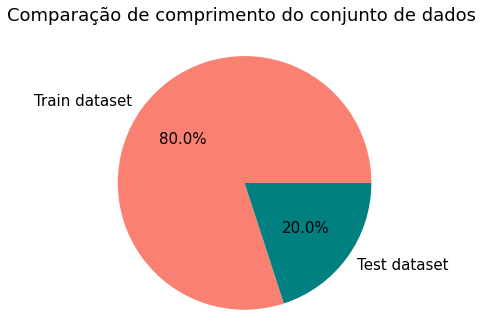

In [29]:
fig, ax = plt.subplots(figsize=(5, 5))

pie = ax.pie([len(df2_train), len(df2_test)],
             labels   = ["Train dataset", "Test dataset"],
             colors   = ["salmon", "teal"],
             textprops= {"fontsize": 15},
             autopct  = '%1.1f%%')

ax.axis("equal")
ax.set_title("Comparação de comprimento do conjunto de dados \n", fontsize=18)
fig.set_facecolor('white')
plt.show();

---

### 2.6.2. Distribuição da target

In [30]:
sns.set(style="darkgrid") 

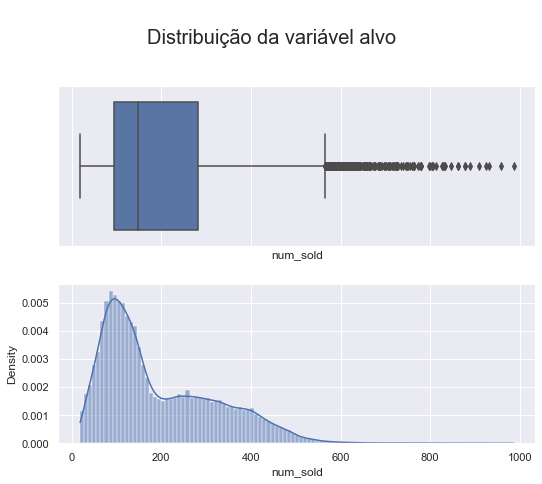

In [31]:

f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, figsize=(8, 7))

sns.boxplot(data=df2_train, x=target, ax=ax_box)
sns.histplot(data=df2_train, x=target, ax=ax_hist, kde=True, stat='density')

plt.suptitle('\nDistribuição da variável alvo', fontsize=20)
plt.tight_layout(pad=2.0);

<div class="alert alert-block alert-info">
<p style="color: black; font-family: Arial Black">NOTA:</p>
     
Observando o gráfico acima, notamos que a distribuição dos dados não são normalmente distribuidos, segue uma distribuição assimétrica positiva com outliners, uma sugestão é fazer uma normalização de log ou raiz quadrada, pode ajuda a resuzir a assemetria, vamos fazer essas duas normalizações.
    
</div>

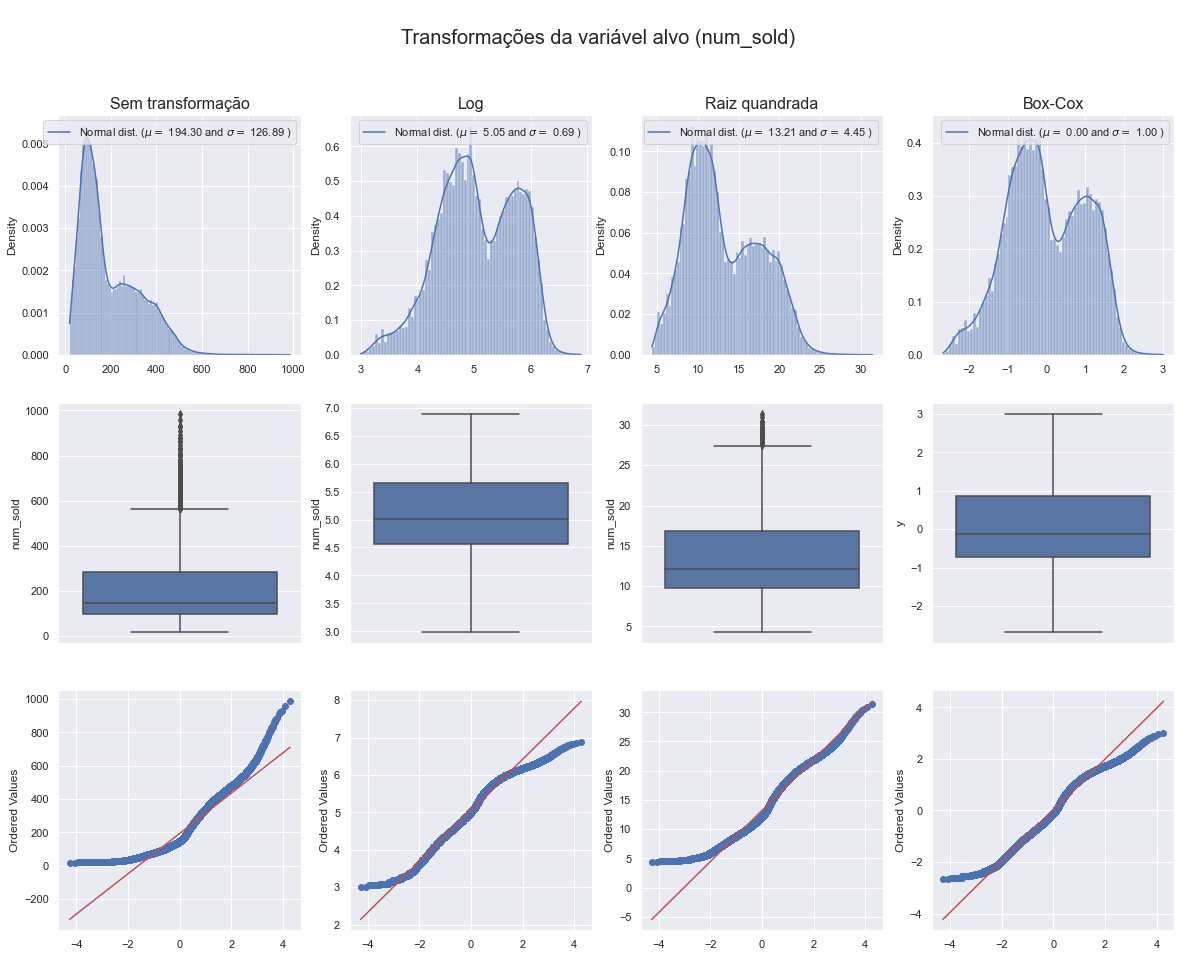

In [32]:
power  = PowerTransformer(method='box-cox') # 
y_ori  = df2_train[target] 
y_log  = np.log1p(y_ori)
y_sqr  = np.sqrt(y_ori)
y_bcox = pd.DataFrame(power.fit_transform(pd.DataFrame(y_ori)), columns=['y'])['y']
label  = ['Sem transformação','Log','Raiz quandrada', 'Box-Cox']

list_feature_trans = [y_ori, y_log, y_sqr, y_bcox]

plt.figure(figsize=(20,15))

msg = 'Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'

for i, v in enumerate(list_feature_trans):
    plt.subplot(3,4,i+1)
    (mu, sigma) = norm.fit(v)        
    #sns.distplot(v, kde=True, hist=True, fit=norm)    
    sns.histplot(x=v, kde=True, stat='density')
    
    plt.legend([msg.format(mu, sigma)],loc='best')
    plt.xlabel('')
    plt.title('{}'.format(label[i]), fontsize=16)
    
    plt.subplot(3,4,i+5)
    sns.boxplot(y=v)
    
    plt.subplot(3,4,i+9)
    res = stats.probplot(v, plot=plt)
    plt.xlabel('')
    plt.title('')

plt.suptitle('\nTransformações da variável alvo ({})'.format(target), fontsize=20)
fig.tight_layout(pad=1.0);

<div class="alert alert-block alert-info">
<p style="color: black; font-family: Arial Black">NOTA:</p>
    
Acima fizemos três transformações na variável alvo: log, raiz quadrada e box-cox, a primeira coluna é a variável sem tranformação, que tem uma distribuição assimétrica positiva com muitos outliers, no gráfico de probabilidade observamos que os valores não se comportam muito bem, indicado a não normalidade dos dados, em relação as transformações temos:   
 
- Todas as transformações tem um distribuíção bimodal; 
    
- As transformações log e box-cox conseguem lidar melhor com os outliers. <p><br>
    
</div>

- **<p style='font-size:18px'> Store</p>**

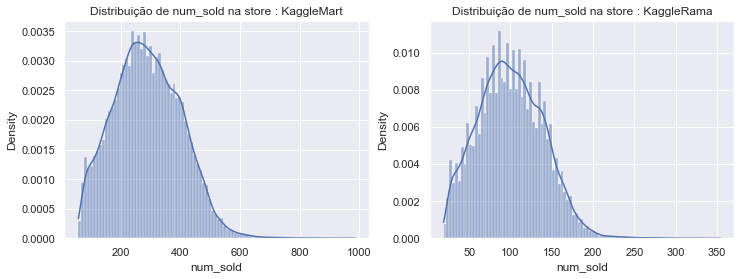

In [33]:
plt.figure(figsize=(12,4))
for i, store in enumerate(df2_train.store.unique()):    
    plt.subplot(1,2,i+1)
    plt.title("Distribuição de num_sold na store : {}".format(store))
    sns.histplot(data=df2_train[df2_train['store']==store], x=target,  kde=True, stat='density')

<div class="alert alert-block alert-info">
<p style="color: black; font-family: Arial Black">NOTA:</p>
       
Notamos nos gráficos acima que a filial <b>KaggleMart</b> tem o maior volume de vendas, com valor máximo de  1000 e a loja <b>KaggleRoma</b> com menor volume de venda, porém com valor máximo que pode chegar a  350, pode ser um indicativo que a variável <b>store</b> pode ser de alta relevancia na modelagem.  <p><br>
    
</div>

- **<p style='font-size:18px'> Product</p>**

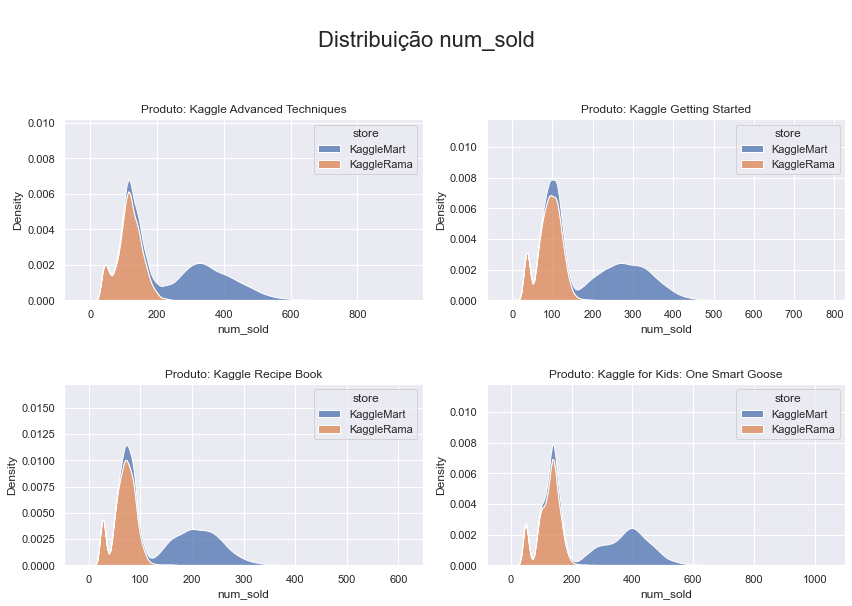

In [34]:
plt.figure(figsize=(12,8))
      
for c, product in enumerate(df2_train['product'].unique()):
    df_aux = df2_train[(df2_train['product']==product)]
    plt.subplot(2,2,c+1,  ymargin=0.5)
    plt.title("Produto: {}".format(product))
    ax = sns.kdeplot(data     = df_aux,
                     x        = target, 
                     hue      = 'store',
                     multiple = 'stack', 
                     legend   = True, 
                     shade    = True )  
    c+=1
    
plt.suptitle('\nDistribuição num_sold', y=1.05, fontsize=22);
plt.tight_layout(h_pad=3.0);

<div class="alert alert-block alert-info">
<p style="color: black; font-family: Arial Black">NOTA:</p>
   
Observando os gráficos acima, constatamos que os produtos tem a mesma distribuição em ambas lojas, porém a loja **KaggleRama** tem o volume de venda menor que a loja **KaggleMart**. <p><br>
    
</div>

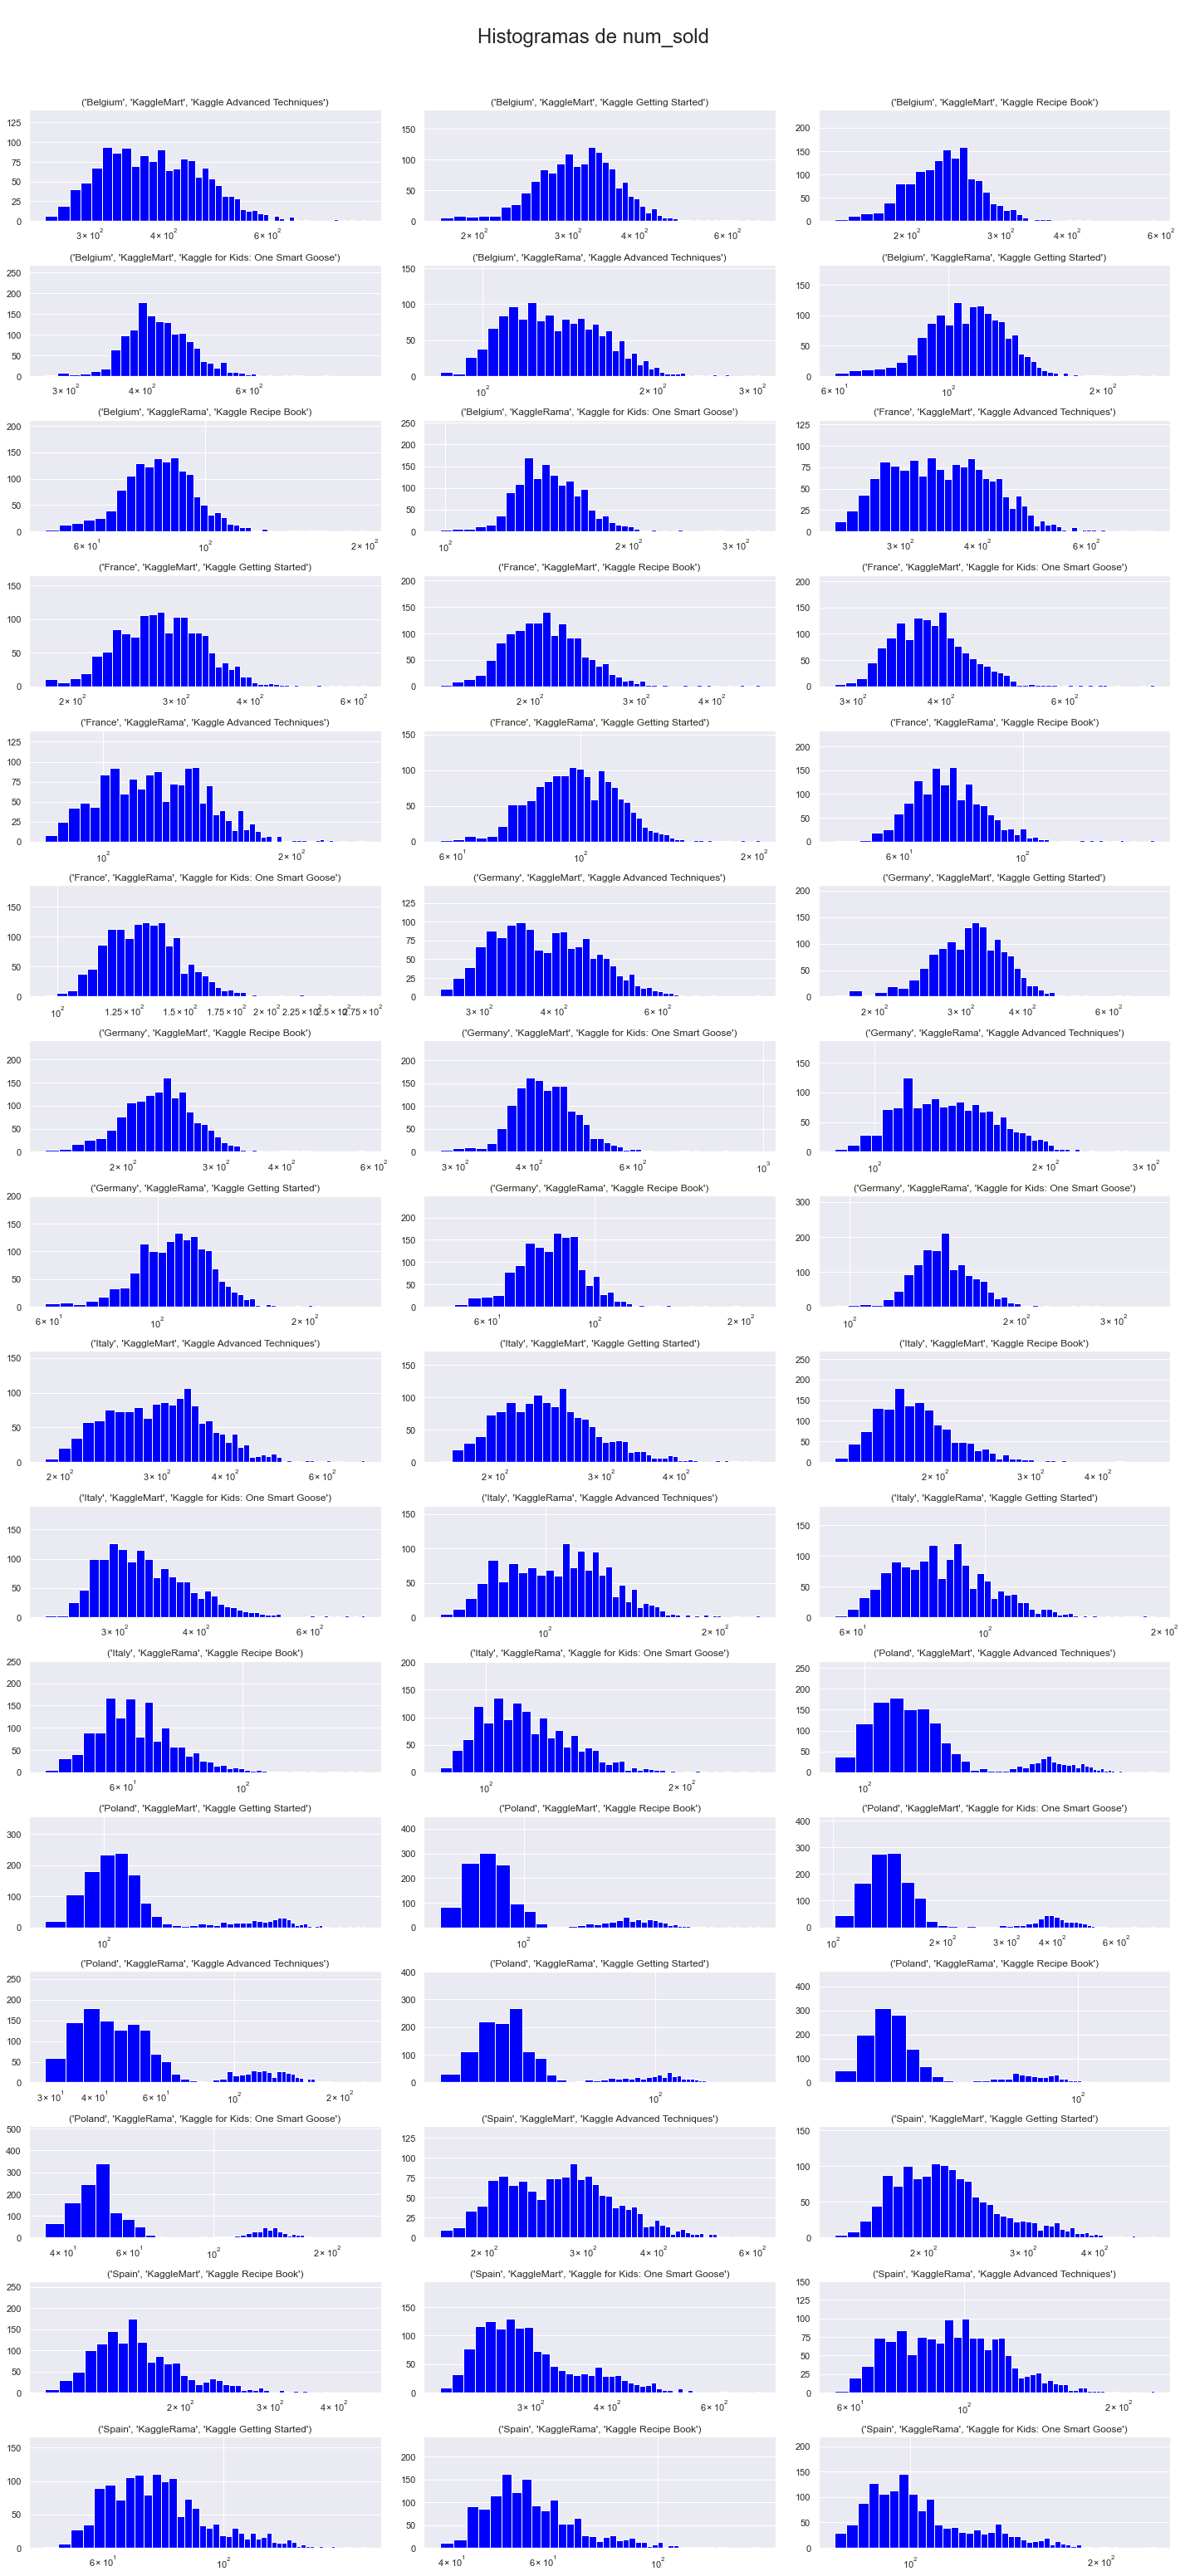

In [35]:
plt.figure(figsize=(20, 50))

for i, (combi, df) in enumerate(df2_train.groupby(['country', 'store', 'product'])):
    ax = plt.subplot(19, 3, i+1, ymargin=0.5)
    ax.hist(df.num_sold, bins=50, color='blue')    
    ax.set_xscale('log')
    ax.set_title(combi)
    
plt.suptitle('\nHistogramas de num_sold', y=1.01 , fontsize=24)
plt.tight_layout(h_pad=1.0)
plt.show()

<div class="alert alert-block alert-info">
<p style="color: black; font-family: Arial Black">NOTA:</p>
   

Os histogramas para cada combinação país-loja-produto mostram que todos os histogramas são distorcidos. Para cada produto, há alguns dias com vendas muito acima da média. Para esses valores discrepantes, as previsões serão muito menos precisas do que para os dias normais. É por isso que a competição é pontuada por erro percentual absoluto médio simétrico ([SMAPE](https://en.wikipedia.org/wiki/Symmetric_mean_absolute_percentage_error)) em vez de MAE ou MSE.

Claro, em uma competição pontuada pelo SMAP, temos que escolher cuidadosamente uma função de perda para treinar nossos modelos. MSE ou MAE não são as funções de perda ideais aqui.

O histograma de cada produto tem uma forma ligeiramente diferente. Os histogramas do **Kaggle Hat** parecem mais amplos do que os histogramas dos outros dois produtos. <p> <br>

<b>OBSERVAÇÕES:</b>
- A escolha de uma função de perda adequada é importante.
- Pode ser vantajoso prever log(num_sold) em vez de num_sold diretamente.
- Precisamos de mais análises para entender por que os histogramas têm formas diferentes. Talvez seja por causa das variações sazonais, talvez haja algo mais. <p><br>

</div>

## 2.7. Análise bivariada

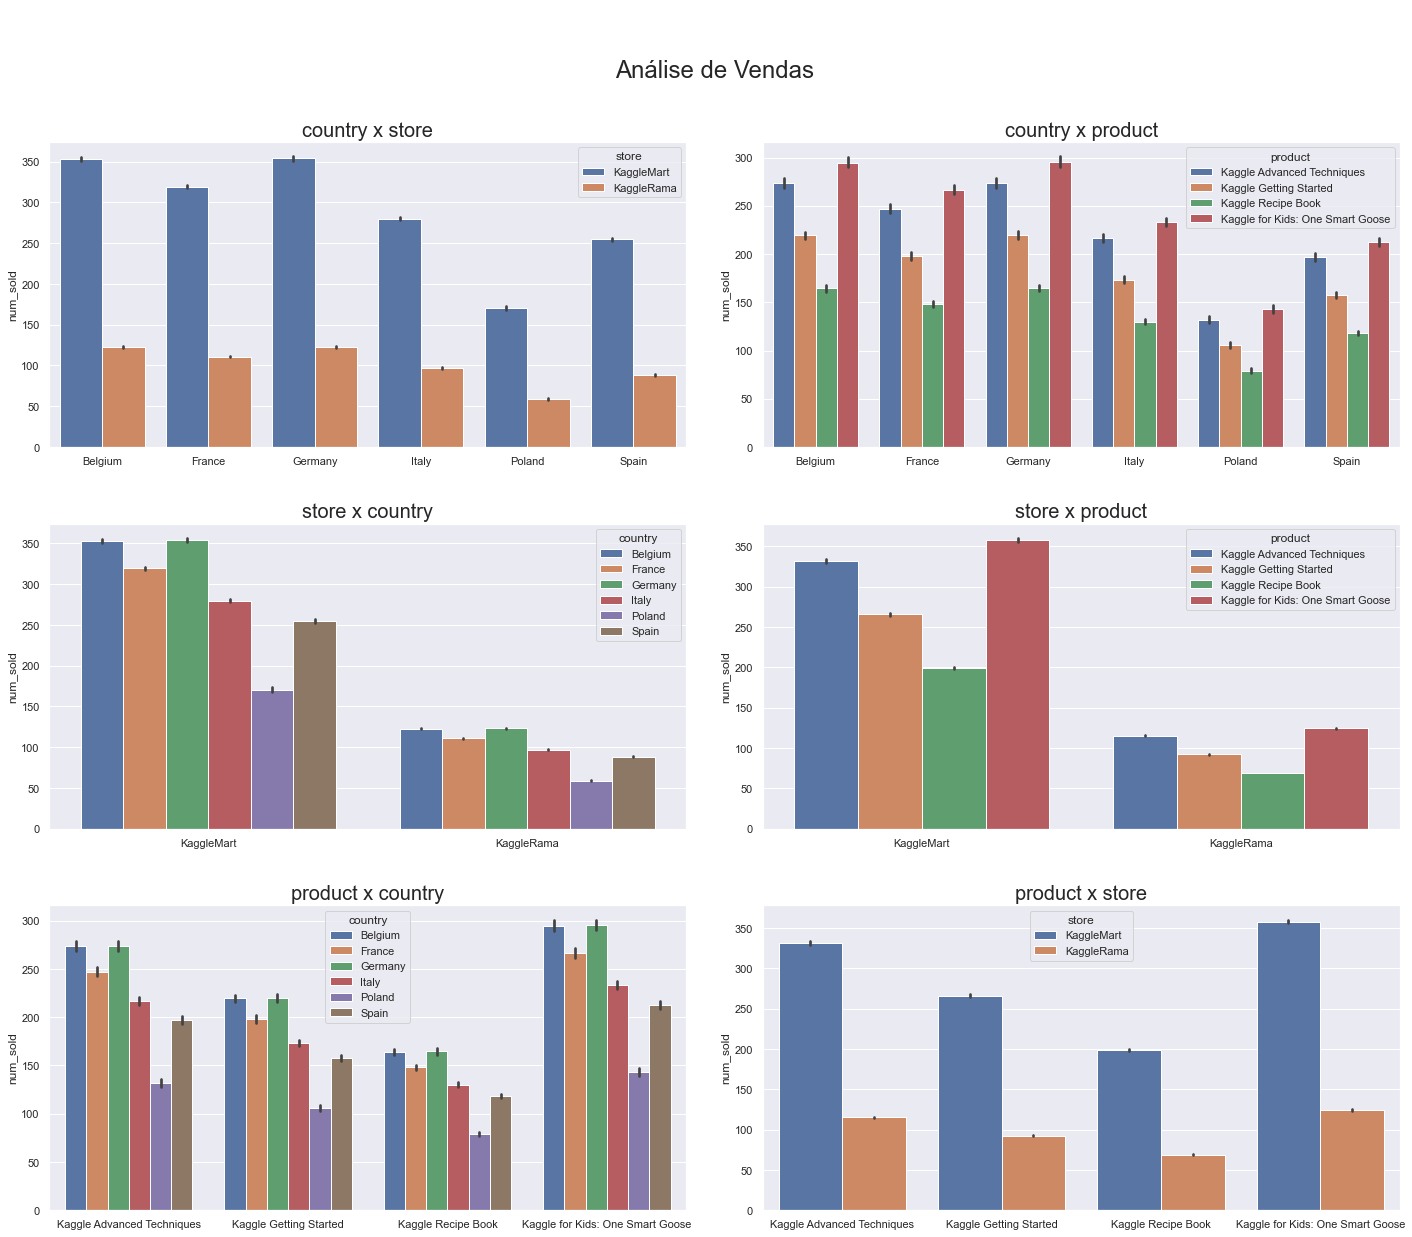

In [36]:
i=1
sns.set(style="darkgrid")
plt.figure(figsize=(20,17))

feature_cat = df2_train.select_dtypes(object)

for col1 in (feature_cat):
    for x, col2 in enumerate(feature_cat):
        if col1!=col2:            
            plt.subplot(3,2, i)    
            sns.barplot(data=df2_train, x=col1, y=target, hue=col2, estimator=np.mean);            
            plt.title('{} x {}'.format(col1, col2), fontsize=20)
            plt.xlabel('')
            i+=1

plt.suptitle('\n\nAnálise de Vendas', y=1.01, fontsize=24);
plt.tight_layout(h_pad=3.0)

<div class="alert alert-block alert-info">
<p style="color: black; font-family: Arial Black">NOTA:</p>
   
Podemos destacar os seguintes pontos nos gráficos acima:
- A Poland é o pais com menor venda, tendo o produto Kaggle Recipe Book com menor venda e Kaggle for Kids com maior venda; 

- Belgium e Germany são os pais que tem as maiores vendas, praticamente empatados; 

- A loja KaggleMart é a que mais venda em todos os paises, uma observação que as vendas de todos os paises são superiores KaggleRama; 

- O produto que mais vende em ambas lojas é Kaggle for Kids com uma pequena diferença do Kaggle Advenced Techniques e o com menor venda é Kaggle Racipe Book; 
    
<b>OBSERVAÇÃO:</b> <br> 
Neste primeiro momento podemos destacar as variáveis <b>country e store</b> como principais variáveis relevantes, talvez uma modelagem para cada pais e loja seja mais eficiente, pois cada pais e lojas tem suas particularidades que podem ser observadas acima.   
    
</div>

## 2.8. Detecção de Outlier

- **<p style='font-size:18px'> Country / Store / Product</p>**

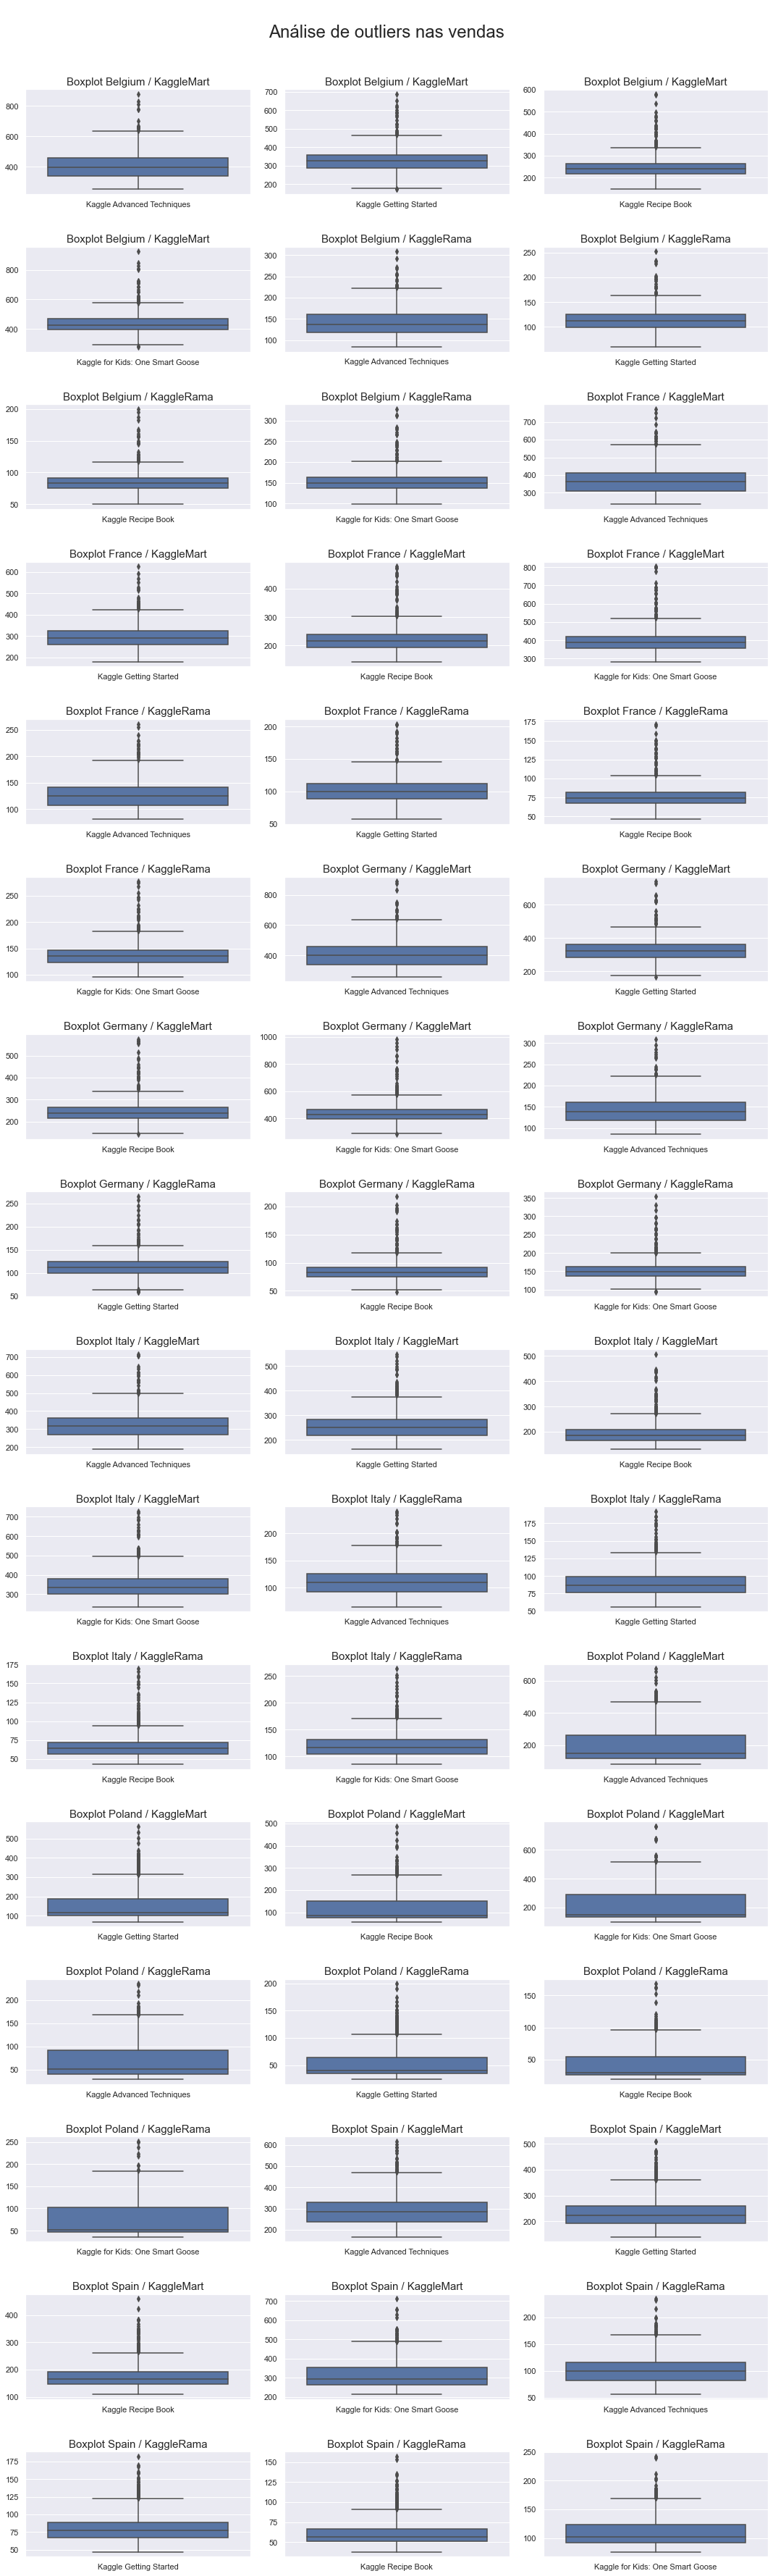

In [37]:
plt.figure(figsize=(15,60))

i = 1 

for country in df2_train['country'].unique():        
    filtro_country = (df2_train['country']==country)
    
    for store in df2_train[filtro_country]['store'].unique():          
        df_products = df2_train[(df2_train['country']==country) & (df2_train['store']==store)] 
        
        for product in df_products['product'].unique():             
            df_product = df_products[df_products['product']==product]     
            plt.subplot(20, 3, i);            
            sns.boxplot(x='product', y=target, data=df_product)  
            plt.xlabel('')
            plt.ylabel('')
            plt.title('Boxplot {} / {}'.format(country, store), loc="center", fontsize=15)           
            i +=1        
            
        plt.tight_layout(h_pad=3.0);
    
plt.suptitle('\nAnálise de outliers nas vendas', y=1.02, fontsize=24);

del df_product, df_products, filtro_country

<div class="alert alert-block alert-info">
<p style="color: black; font-family: Arial Black">NOTA:</p>
   
Notamos nos gráficos acima, que temos muitos outliers em todos os produto, provavelmente isso ocorre por motivo do aumento das vendas em determinadas épocas, podemos considerar fenomeno da sazonalidade. <p>
    
Um ponto importante a destacar, é estrutura individualizada do produto, isso é um indicativo que temos capturar essa individualização com a criação de variáveis, mais à frente vamos identicar os padrões de sazonalidade. <p><br>
    
</div>

---

## 2.9. Análise de Séries Temporais
Nesta etapa do processo de análise, como estamos trabalhando com dados temporais, vamos fazer algumas análises dos dados em relação ao tempo (dia, semana, mes, ano, feriado, etc), com o intuito de identificarmos alguns padrões como: sazonalidade, clico, tendência e outros pontos relevantes para a modelagem. 

### 2.9.1 Crescimento
Para ter uma noção rapida das vendas por ano vamos comerça com o gráfico de barra. 

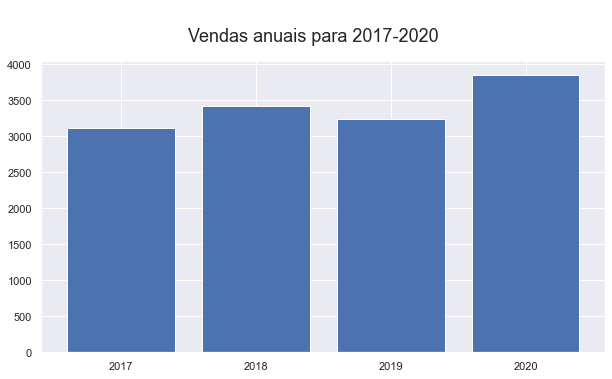

In [570]:
plt.figure(figsize=(9, 5))

resampled = df2_train.set_index('date').resample('Y').sum()/1000
year      = ['2017', '2018','2019', '2020']

plt.bar(x=year, height=resampled['num_sold'])             
plt.suptitle('\nVendas anuais para 2017-2020\n', y=1.03, fontsize=18);
plt.bar_label(ax.containers[0],fmt="%.0f", padding=2, fontsize=15);

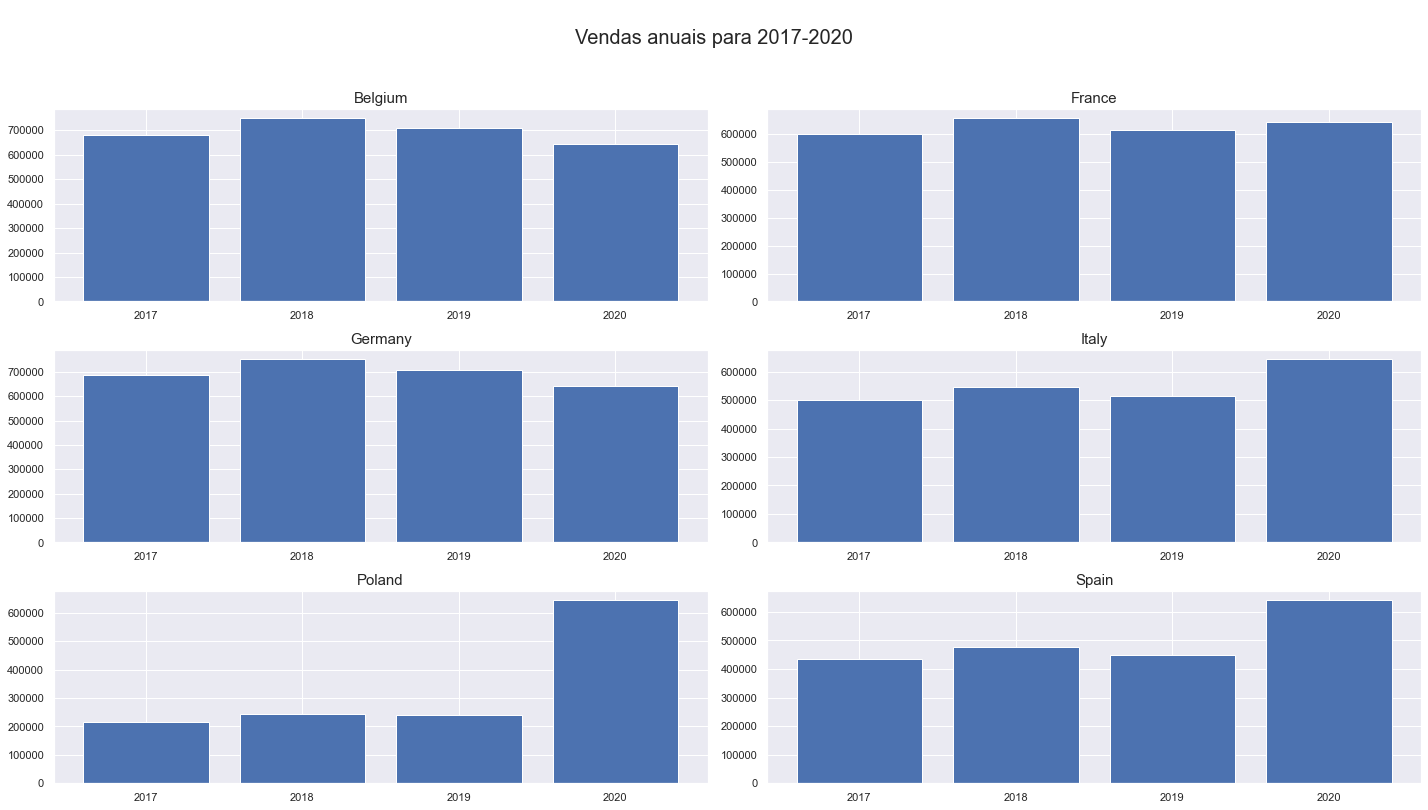

In [597]:
year       = ['2017', '2018','2019', '2020']
df_country = df2_train.groupby(["country", pd.Grouper(key="date", freq="Y")])\
             ["num_sold"].sum().rename("num_sold").reset_index()

plt.figure(figsize=(20, 20))

for i , country in enumerate(df_country['country'].unique()):
    plt.subplot(6,2, i+1)
    plt.bar(x=year, height=df_country[df_country['country']==country]['num_sold']) 
    plt.title(country, loc="center", fontsize=15)
    plt.tight_layout(h_pad=1.0);

plt.suptitle('\nVendas anuais para 2017-2020\n', y=1.05, fontsize=20);

<div class="alert alert-block alert-info">
<p style="color: black; font-family: Arial Black">NOTA:</p>
    
A agregação das vendas por ano mostra a tendência de crescimento para alguns pais e a queda para outros, algumas pequenas diferenças sutis e outros não, que podemos destacar:
    
- Na Bélgica vem decaído a venda apartir de 2018 quando tever uma aumento das venda em relação ao ano de 2017, podemos observar que o patamar das vendas em 2019 é o menor de toda a série; <p>
- A França tem um crescimento em 2018, tem uma caída em 2019 e volta a subir em 2020; <p>
- A Alemanhã vem sucessiva queda deste 2018 que foi a melhor ano de venda; <p>
- A Itália teve apenas o ano 2019 sem crescimento, no último no ano teve um aumento significativo; <p>
- A Polânia e a Espanha tiveram um supreedente crescimento no 2020, com destaque a Polônia. <p><br>
   

<b>OBSERVAÇOES:</b><br>
- Temos que modelar uma taxa de crescimento  que depende do país;
- O crescimento não é linear nem exponencial, <b>exceto para Polônia no último ano</b>;

Para uma análise mais ampla do tópico, consulte [esta discussão](https://www.kaggle.com/c/tabular-playground-series-jan-2022/discussion/298318). O resultado foi que os números de vendas do Kaggle dependem do PIB do país. <p><br>

Vamos analisar a venda em  relação ao tempo (semana e anos): <p> <br>
    
</div>

### 2.9.1. Country / Store

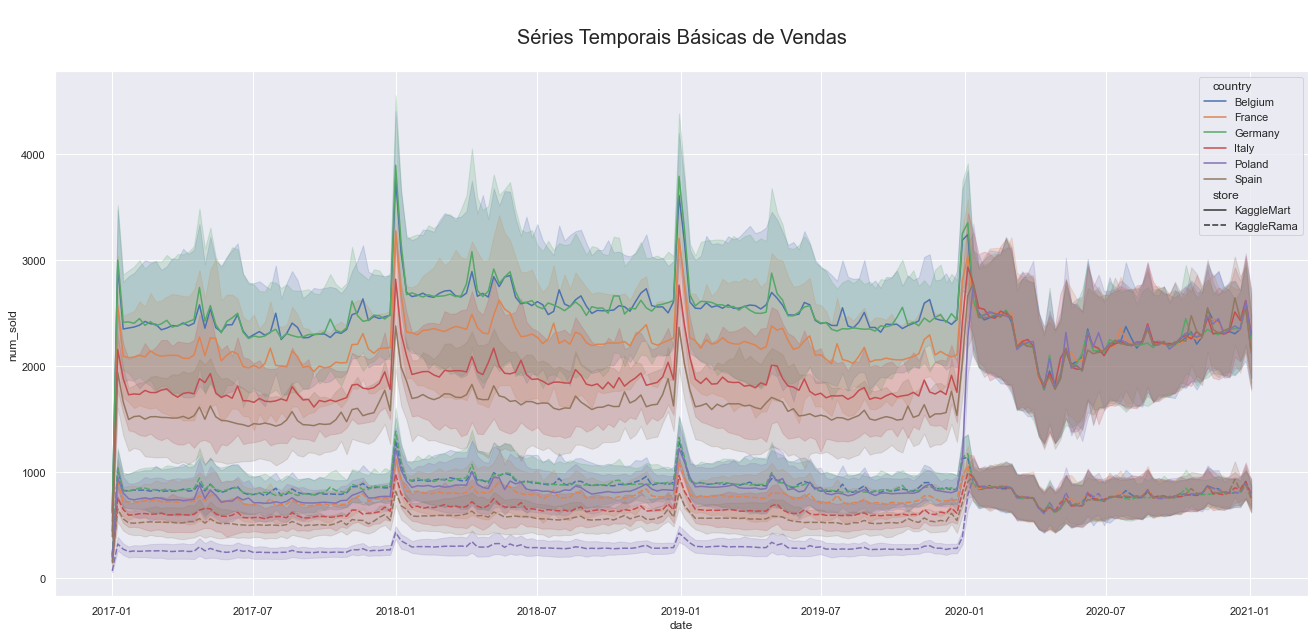

In [404]:
plt.figure(figsize=(20,9))
plt.tight_layout()

df_week = df2_train.groupby(["country","store", "product", pd.Grouper(key="date", freq="W")])\
              ["num_sold"].sum().rename("num_sold").reset_index()

sns.lineplot(data  = df_week, 
             x     ='date', 
             y     = 'num_sold', 
             hue   = 'country', 
             style = 'store');

plt.title("\nSéries Temporais Básicas de Vendas\n",fontsize=20);

del df_week

<div class="alert alert-block alert-info">
<p style="color: black; font-family: Arial Black">NOTA:</p>

- Entre o anos de 2017 à 2019, obsevamos que cada país tem um padrão de venda diferente;   
- O ano de 2020 é significativamente diferente dos outros anos, sendo as vendas quase idênticas entre países e lojas.<p> <br>
    
Vamo olhar o produto por poríodo semanal e mensal. <p> <br> 
    
</div>

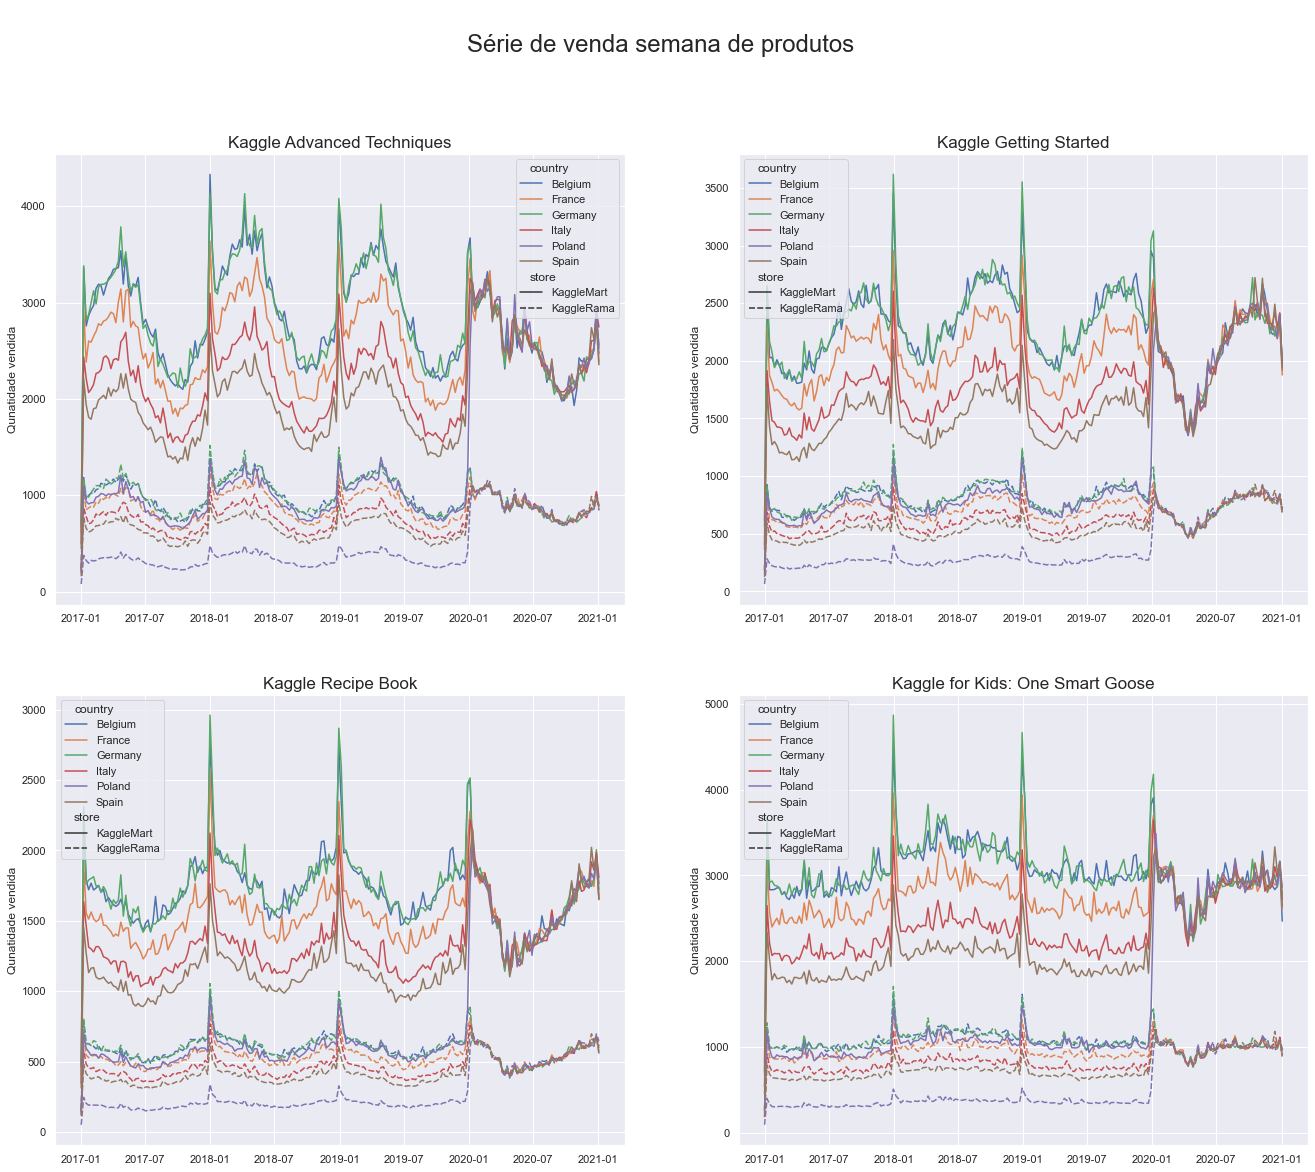

In [448]:
plt.figure(figsize=(20,17))
plt.tight_layout()

df_week = df2_train.groupby(["country","store", "product", pd.Grouper(key="date", freq="W")])\
              ["num_sold"].sum().rename("num_sold").reset_index()

for i, product in enumerate(df_week['product'].unique()):
    plt.subplot(2, 2, i+1)
    sns.lineplot(data  = df_week[df_week['product']==product], 
                 x     ='date', 
                 y     = 'num_sold', 
                 hue   = 'country', 
                 style = 'store')
    
    plt.title(product, loc="center", fontsize=17)
    plt.ylabel('Qunatidade vendida')
    plt.xlabel('')
    
plt.suptitle('\nSérie de venda semana de produtos', y=1.0, fontsize=24);

del df_week

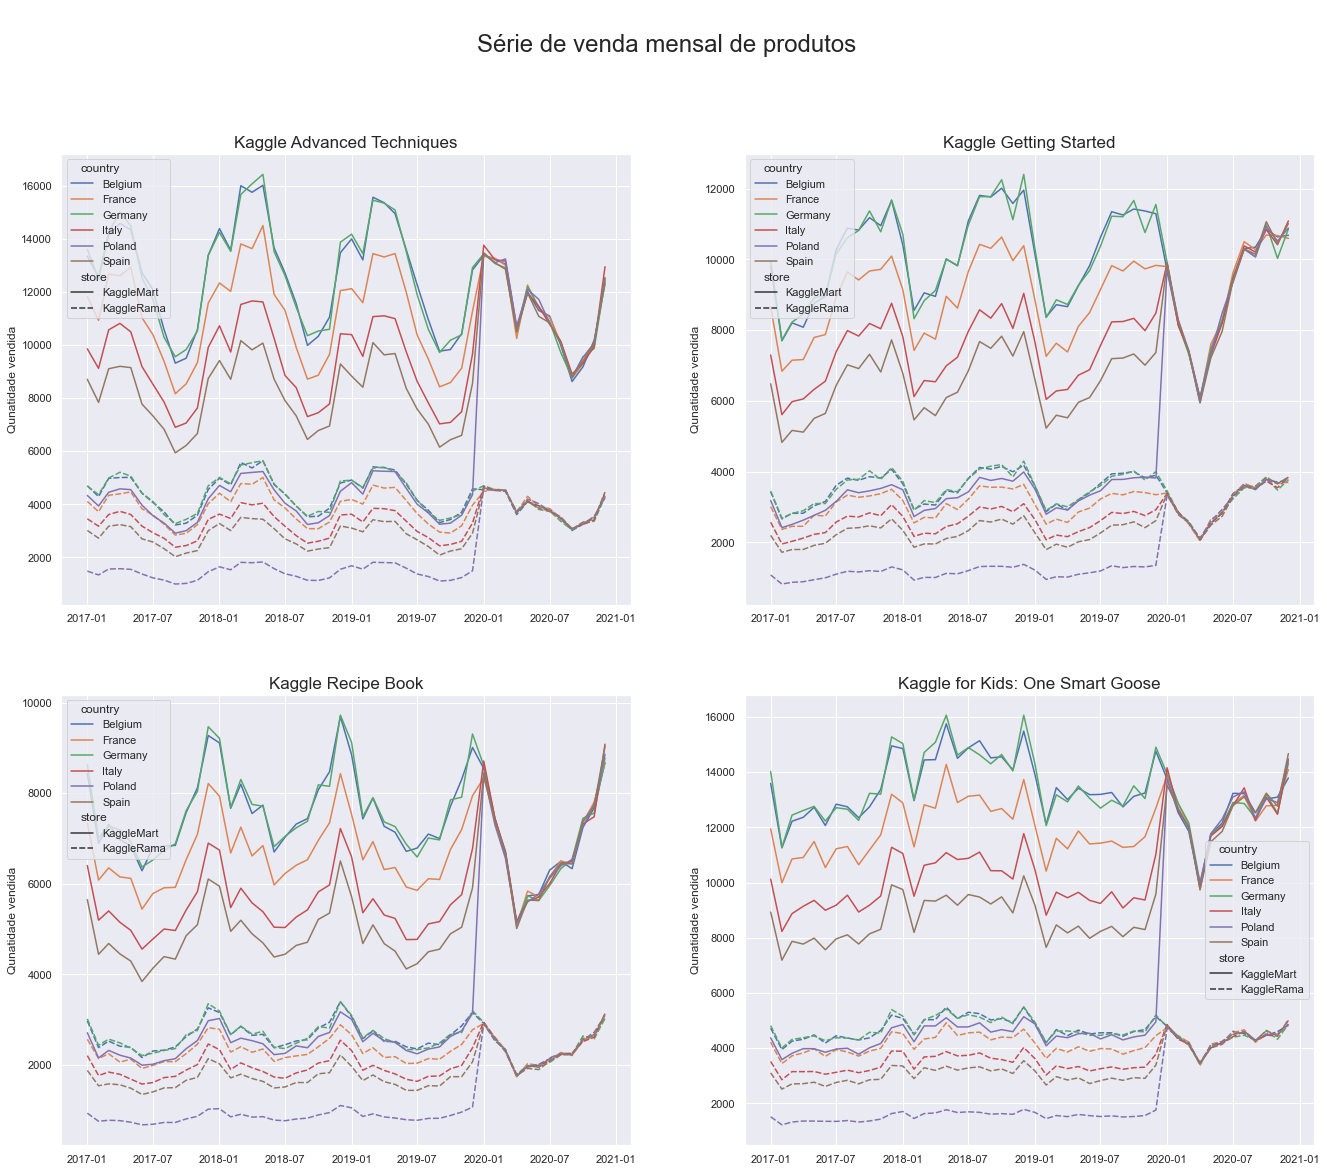

In [449]:
plt.figure(figsize=(20,17))
plt.tight_layout()

df_week = df2_train.groupby(["country","store", "product", pd.Grouper(key="date", freq="MS")])\
              ["num_sold"].sum().rename("num_sold").reset_index()

for i, product in enumerate(df_week['product'].unique()):
    plt.subplot(2, 2, i+1)
    sns.lineplot(data  = df_week[df_week['product']==product], 
                 x     ='date', 
                 y     = 'num_sold', 
                 hue   = 'country', 
                 style = 'store')
    
    plt.title(product, loc="center", fontsize=17)
    plt.ylabel('Qunatidade vendida')
    plt.xlabel('')
    
plt.suptitle('\nSérie de venda mensal de produtos', y=1.0, fontsize=24);

del df_week

<div class="alert alert-block alert-info">
<p style="color: black; font-family: Arial Black">NOTA:</p>

Podemos destacar os seguintes ponto: 

- Cada produto tem um padrão diferente em número de venda, existe um forte componente sazonal/tendência para cada produto/loja;    
- Quando olhamos para a sazonalidade e o ciclo de venda, observamos que seguem o mesmo padrão entre as lojas, mas com KaggleRama tendo menos vendas;     
- Da mesma forma, parece que o padrão de vendas entre todos os países são idênticos, com a magnitude das vendas sendo diferente. <p> <br>
    
<b>REFERÊNCIA DO GRÁFICO</b>: [ehekatlact](https://www.kaggle.com/code/ehekatlact/tps2209-ridge-lgbm-eda-topdownapproach) <p> <br>    
    
</div>

---

### 2.9.1. Pico de venda de final de ano

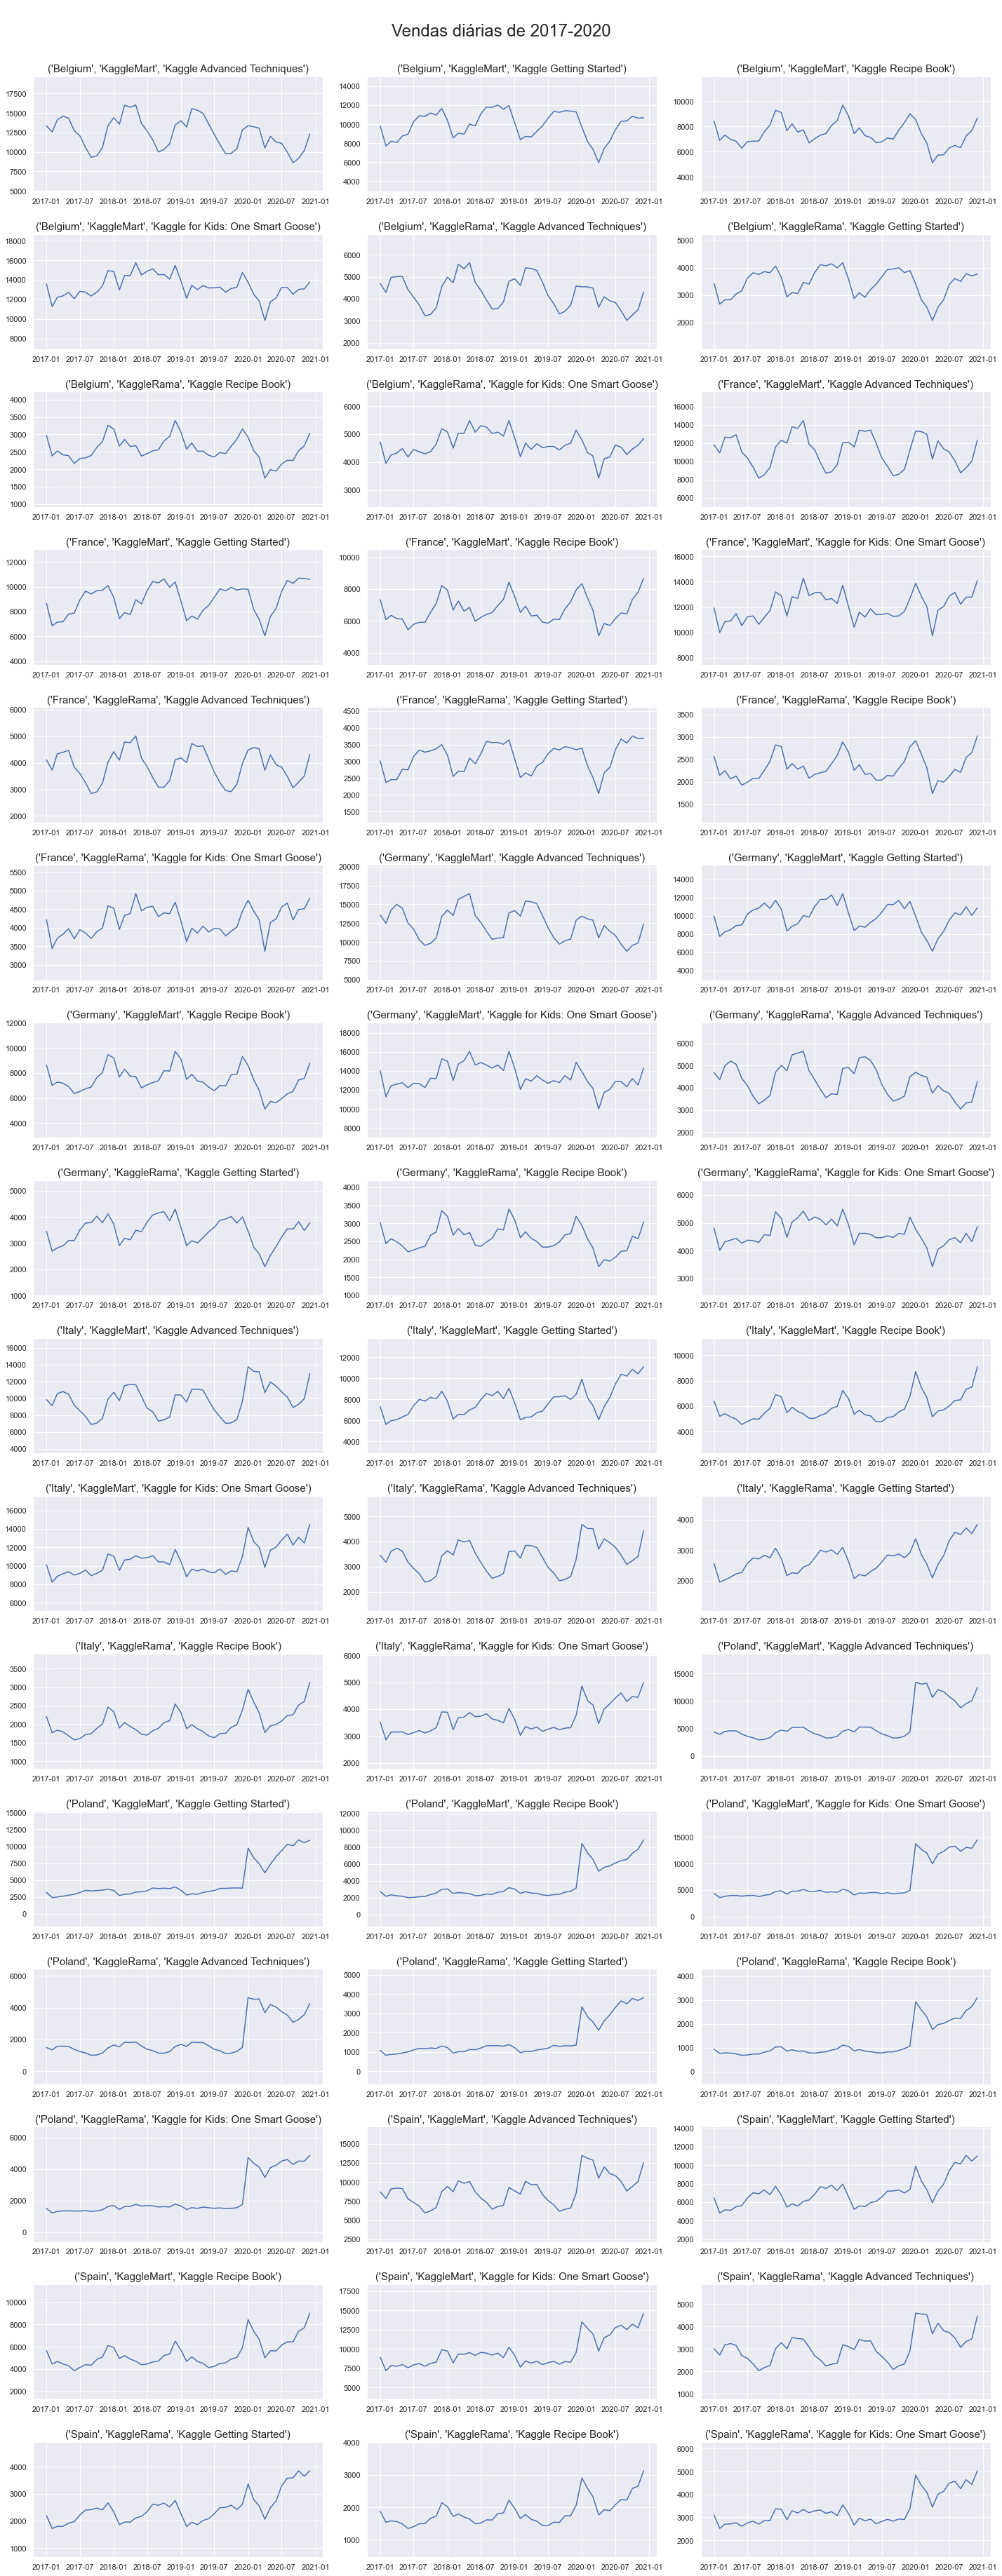

In [513]:
plt.figure(figsize=(20, 50))

df_week = df2_train.groupby(["country","store", "product", pd.Grouper(key="date", freq="MS")])\
              ["num_sold"].sum().rename("num_sold").reset_index()

df_week.set_index('date', inplace=True)

for i, (combi, df) in enumerate(df_week.groupby(['country', 'store', 'product'])):
    ax = plt.subplot(16, 3, i+1, ymargin=.5)    
    ax.plot(df.num_sold)
    ax.set_title(combi, loc="center", fontsize=15)
    plt.tight_layout(h_pad=2.0)

plt.suptitle('\nVendas mensais de 2017-2020', y=1.02, fontsize=24);

<div class="alert alert-block alert-info">
<p style="color: black; font-family: Arial Black">NOTA:</p>
    
Podemos observar nos gráficos acima os valores diários das 48 séries temporais dos quatro anos, claramente um picos altos no final de cada ano, se olharmos os gráficos de perto veremos leves formas de onda que podem ser o efeitos sazonais. <p><br>   
    
<b>OBSERVAÇÕES:</b>
- Temos que modelar efeitos sazonais que dependem do produto; 
- Temos que modelar ondas com comprimento de onda de um ano, bem como picos curtos;
- As lojas da Polond, podemos observar que as vendas até o ponto 5000 segue um padrão abaixo de 100, elendo-se acima de 150 em diante em alguns produtos chegando a 400, precisamos entende melhor essa mudança de padrão na Polond. 
    
Vamos ampliar o pico de fim de ano. Traçamos apenas os 31 dias de dezembro, em média ao longo dos quatro anos. 

</div>

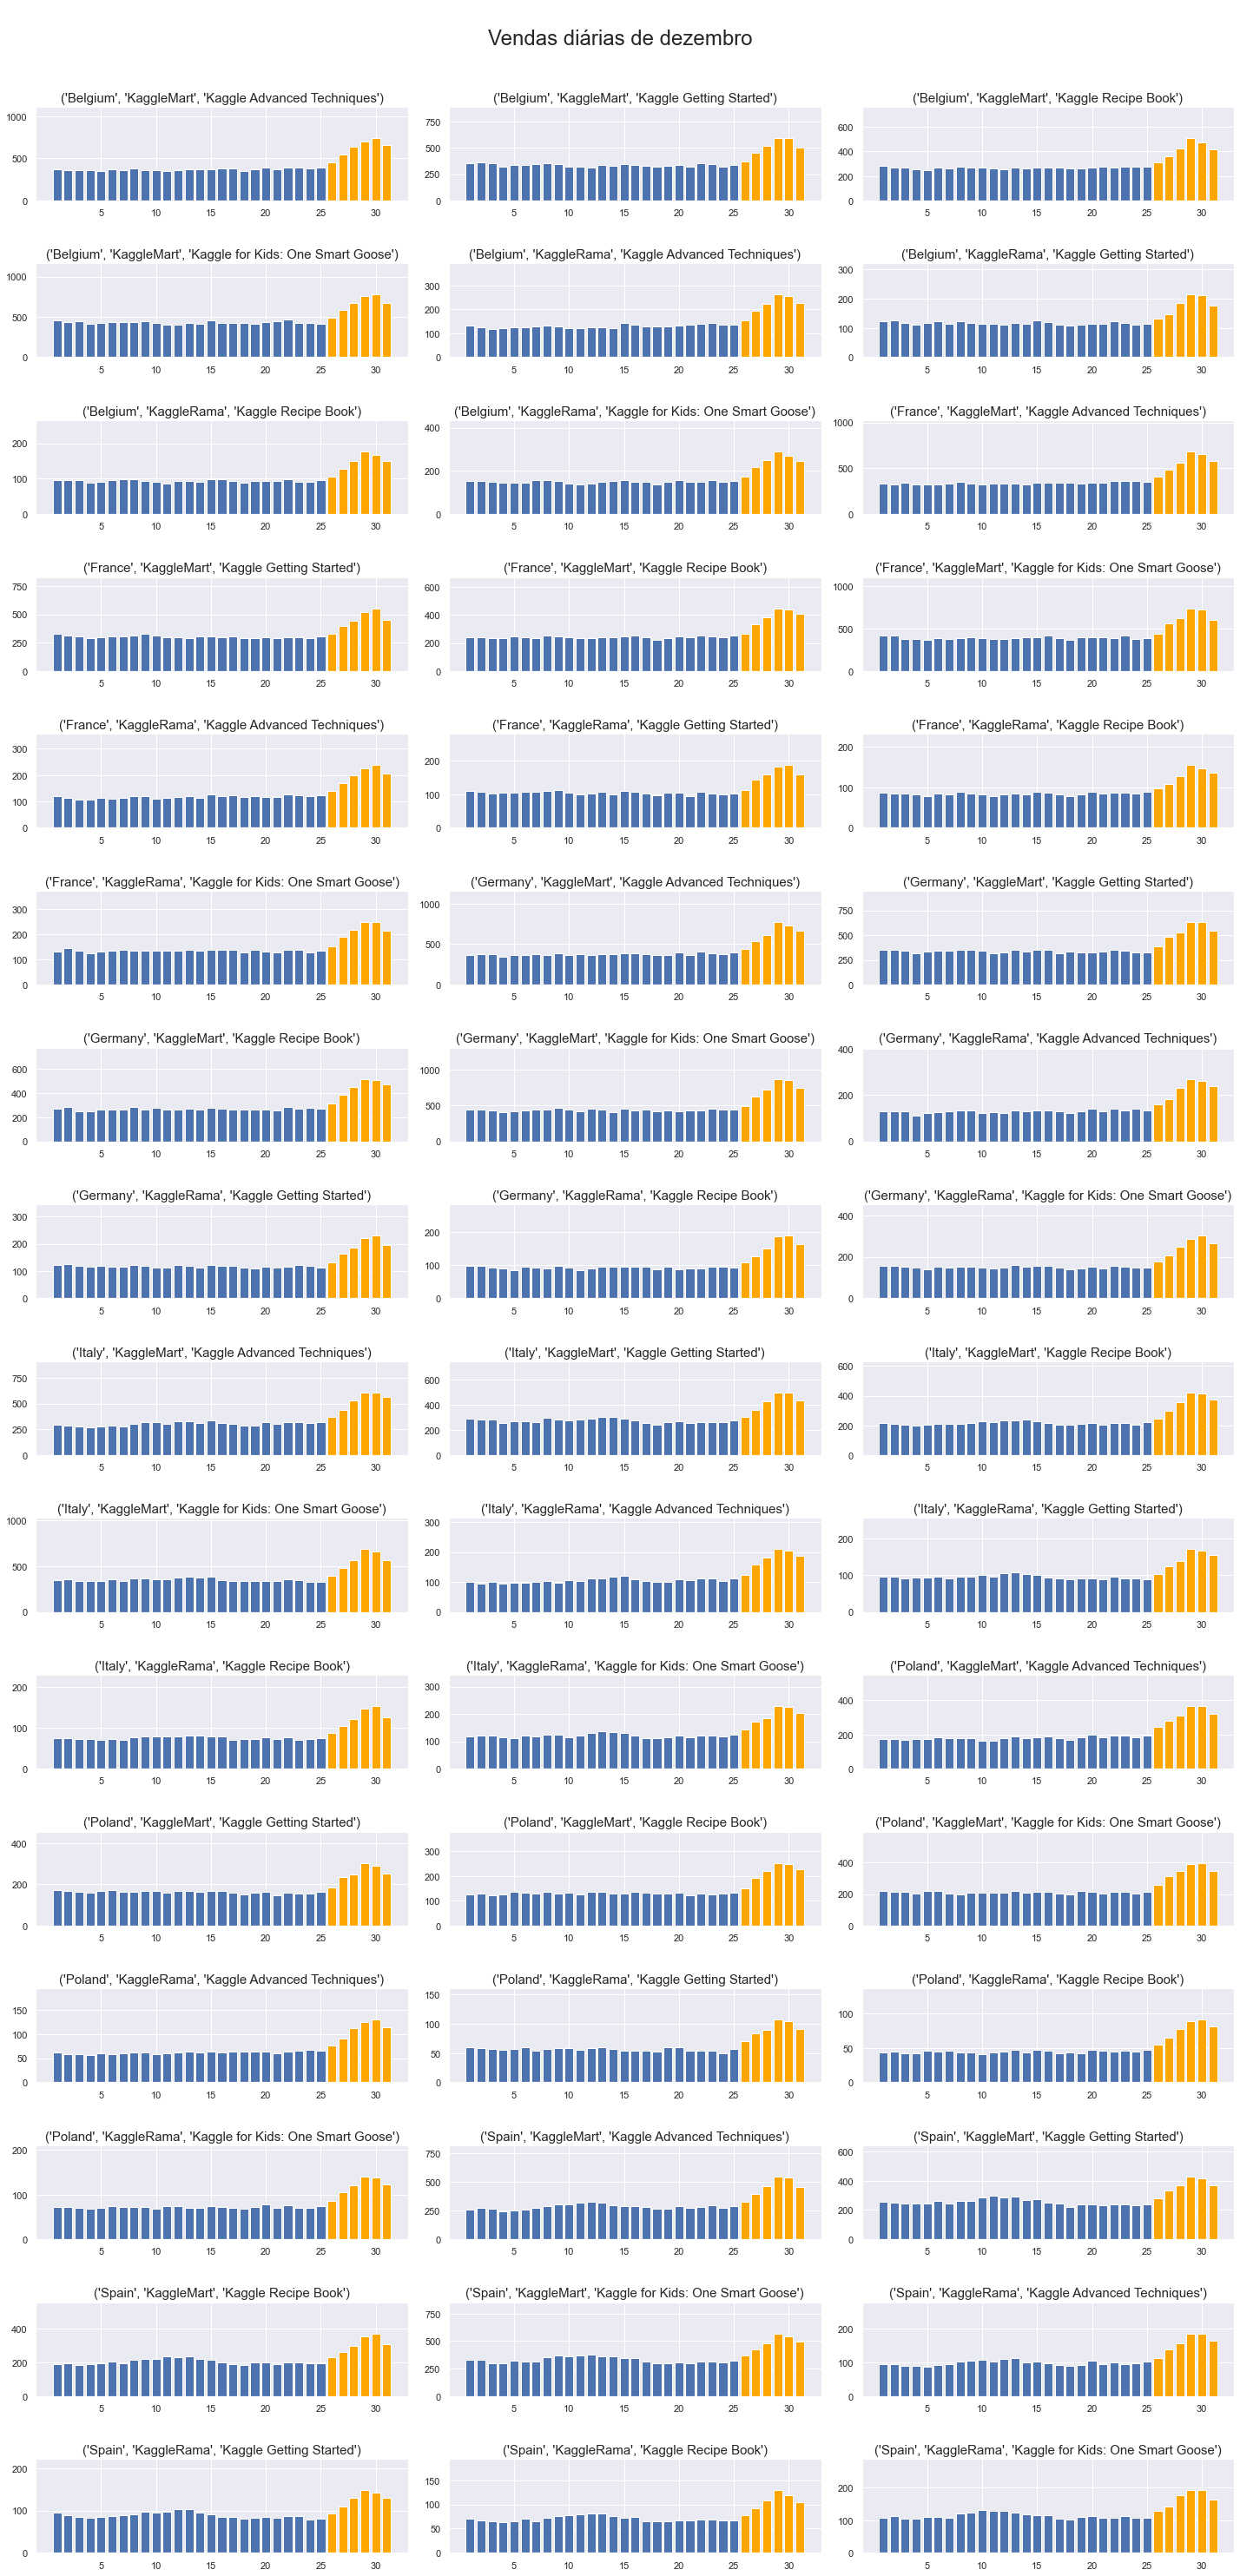

In [514]:
plt.figure(figsize=(20, 40))

for i, (combi, df) in enumerate(df2_train.groupby(['country', 'store', 'product'])):
    df_aux = df.num_sold[df.date.dt.month==12].groupby(df.date.dt.day).mean()
    ax = plt.subplot(16, 3, i+1, ymargin=0.5)    
    ax.bar(range(1, 32), df_aux, color=['b']*25+['orange']*6)    
    ax.set_title(combi, loc="center", fontsize=15)
    ax.set_xticks(ticks=range(5, 31, 5))    
    plt.tight_layout(h_pad=3.0)
    
plt.suptitle('\nVendas diárias de dezembro', y=1.03, fontsize=24);
del df_aux

<div class="alert alert-block alert-info">
<p style="color: black; font-family: Arial Black">NOTA:</p>

Os gráficos mostram que as vendas começam a crescer depois do Natal e atingem o pico no dia 29 de dezembro, temos que modelar a ocorrência desse pico, com a criação de novas variáveis. 
   

</div>

---

### 2.9.2. Vendas mensais e variação sazonal

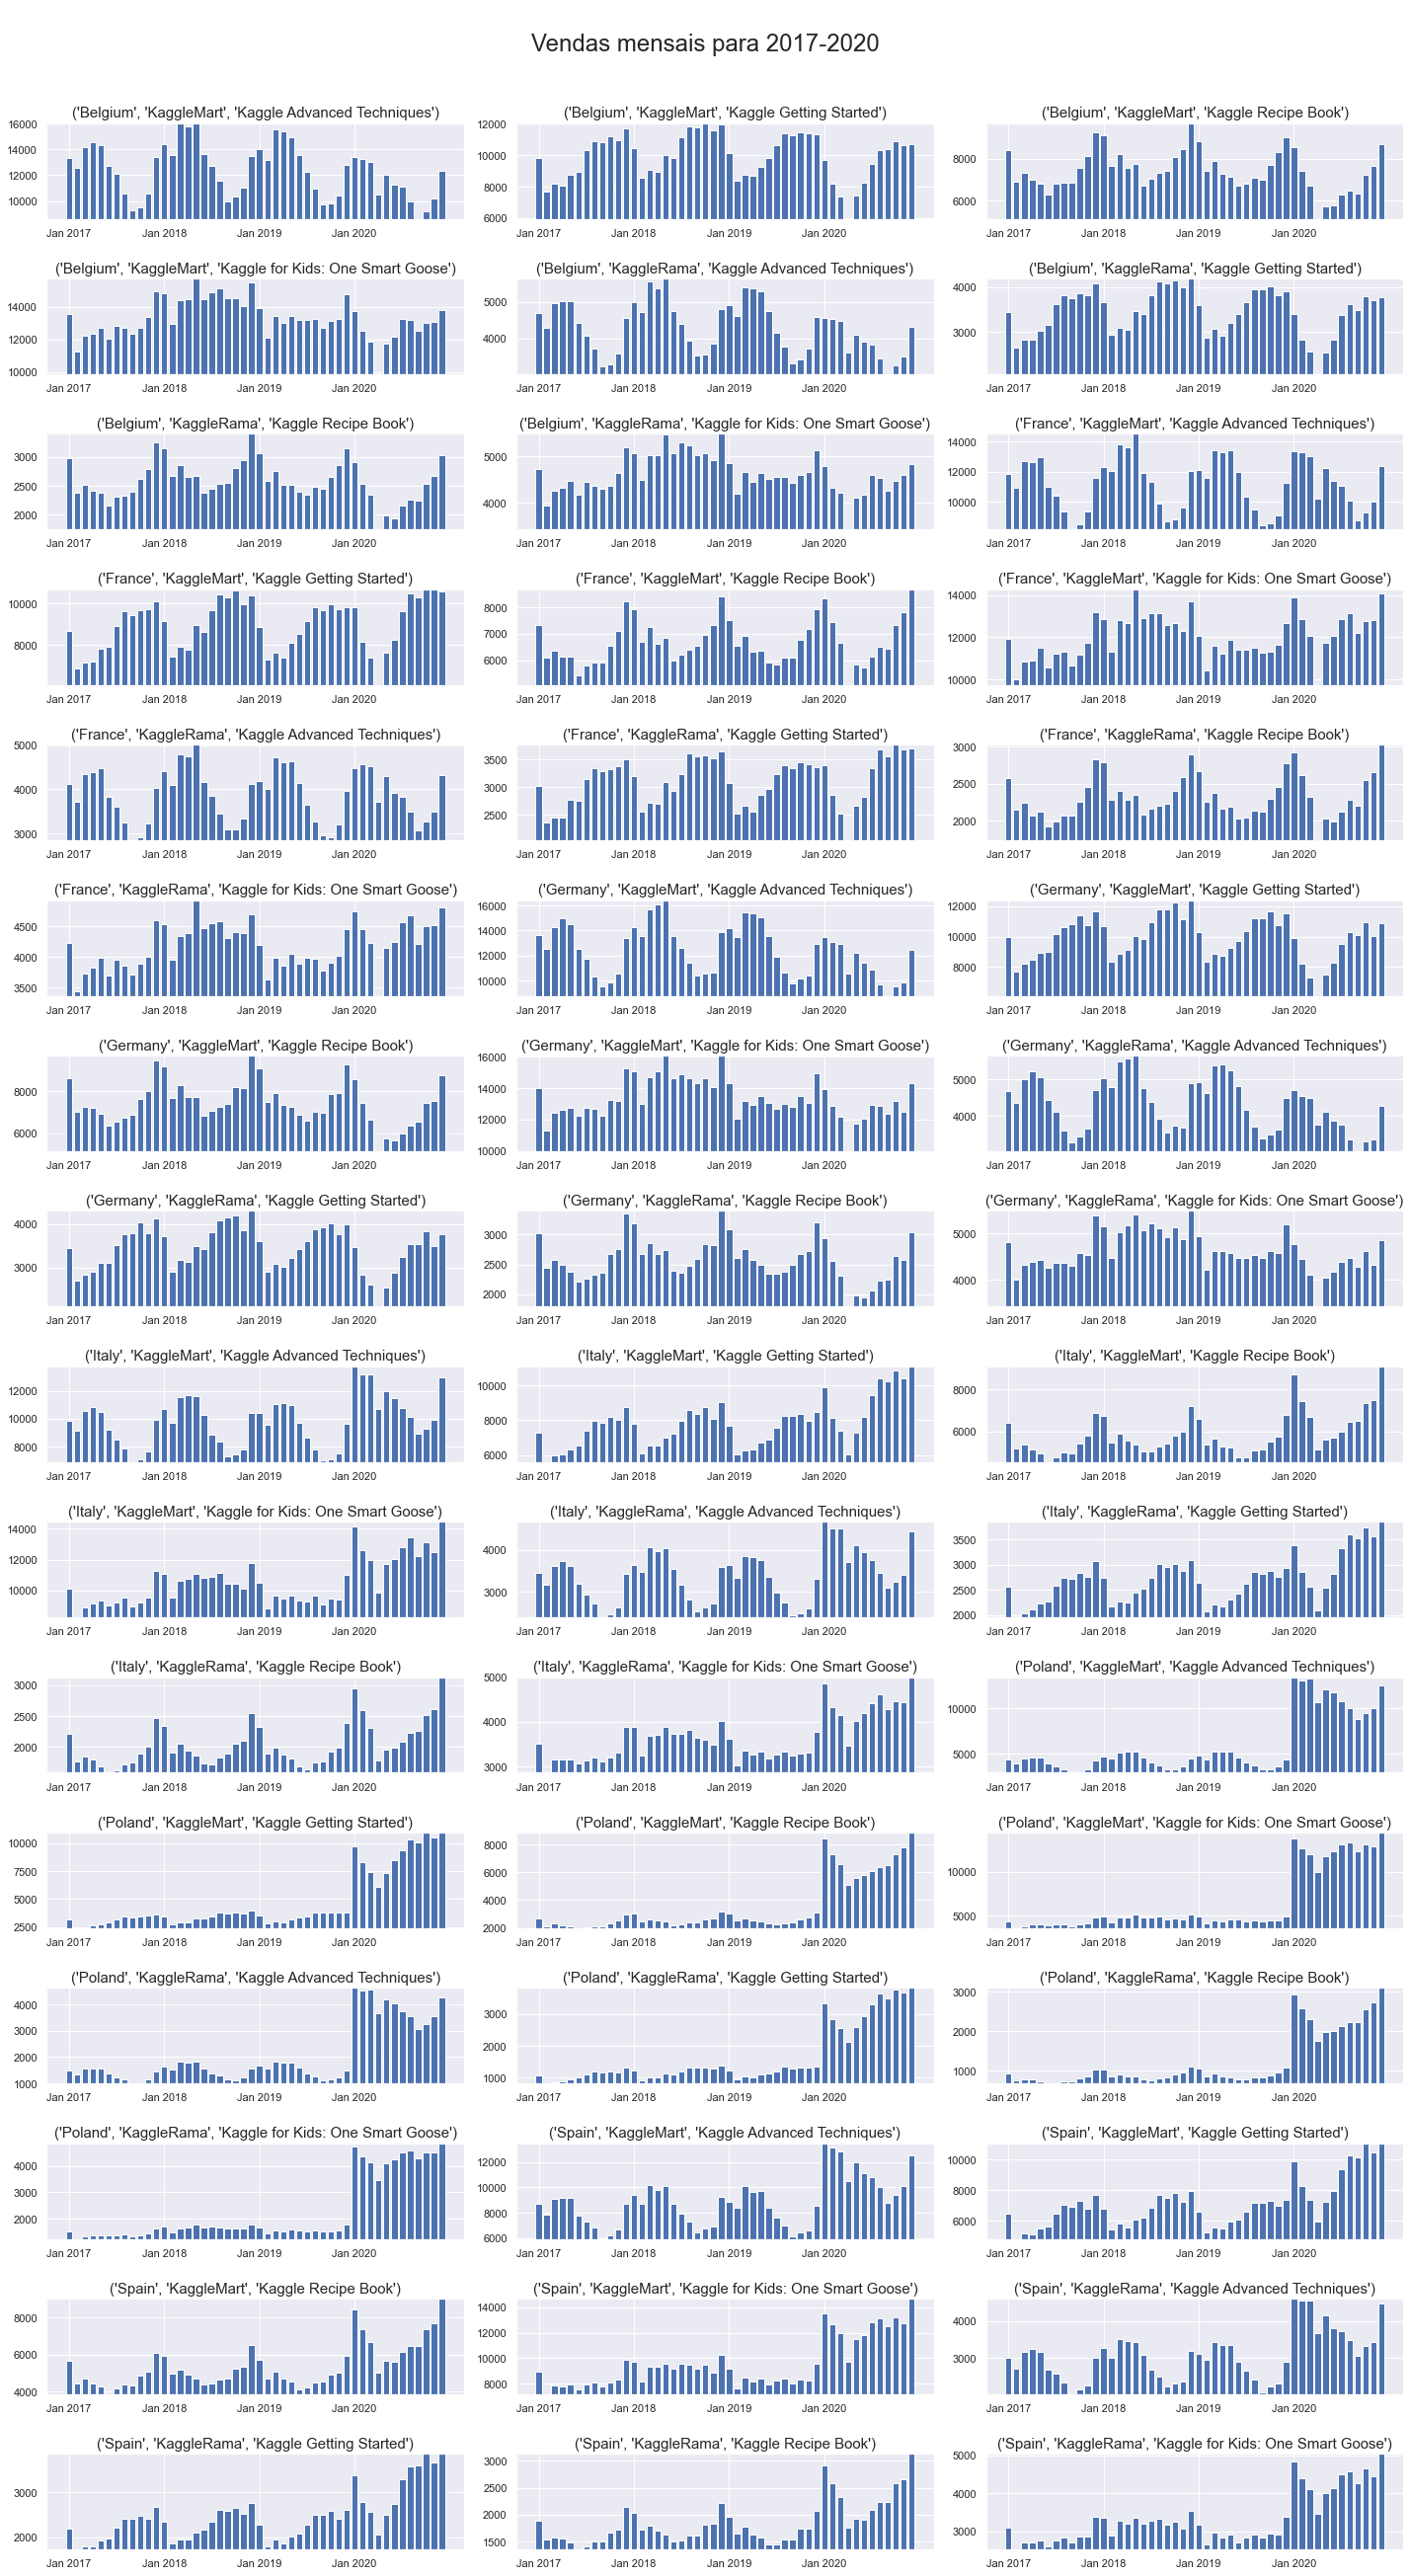

In [515]:
plt.figure(figsize=(20, 35))

for i, (combi, df) in enumerate(df2_train.groupby(['country', 'store', 'product'])):
    ax = plt.subplot(16, 3, i+1, ymargin=0.5)    
    resampled = df.set_index('date').resample('M').num_sold.sum()
    ax.bar(range(len(resampled)), resampled) #, align='edge')
    ax.set_title(combi, loc="center", fontsize=15)
    ax.set_ylim(resampled.min(), resampled.max())   
    ax.set_xticks(range(0, 48, 12)) 
    ax.set_xticklabels([f"Jan {y}" for y in range(2017, 2021)])
    plt.tight_layout(h_pad=2.0)
    
plt.suptitle('\nVendas mensais para 2017-2020', y=1.035, fontsize=24);

<div class="alert alert-block alert-info">
<p style="color: black; font-family: Arial Black">NOTA:</p>

Podemos destacar os seguintes ponto em relação aos gráficos acima:
- Nos gráficos mensais acima mostram a variação sazonal e uma tendência crescente,  o crescimento parece mais pronunciada para alguns produtos como <b>Kaggle Advanced Techniques e Kaggle Getting Started</b>; <p>

- Fica claro que a Poland nos três primeiro anos segue um padrão que não se repete no quarto ano, neste caso temos que modelar esse padrão, o que reforça a modelagem para cada pais. 
        
<b>OBSERVAÇÃO</b>: <br>
- Devemos garantir que nossos modelos possam extrapolar o crescimento para o quinto ano, podemos ver a variação sazonal mais claramente se fizermos a média dos quatro anos e mostrarmos apenas 12 barras para os 12 meses, vamos fazer esses gráficos:
    
</div>

---

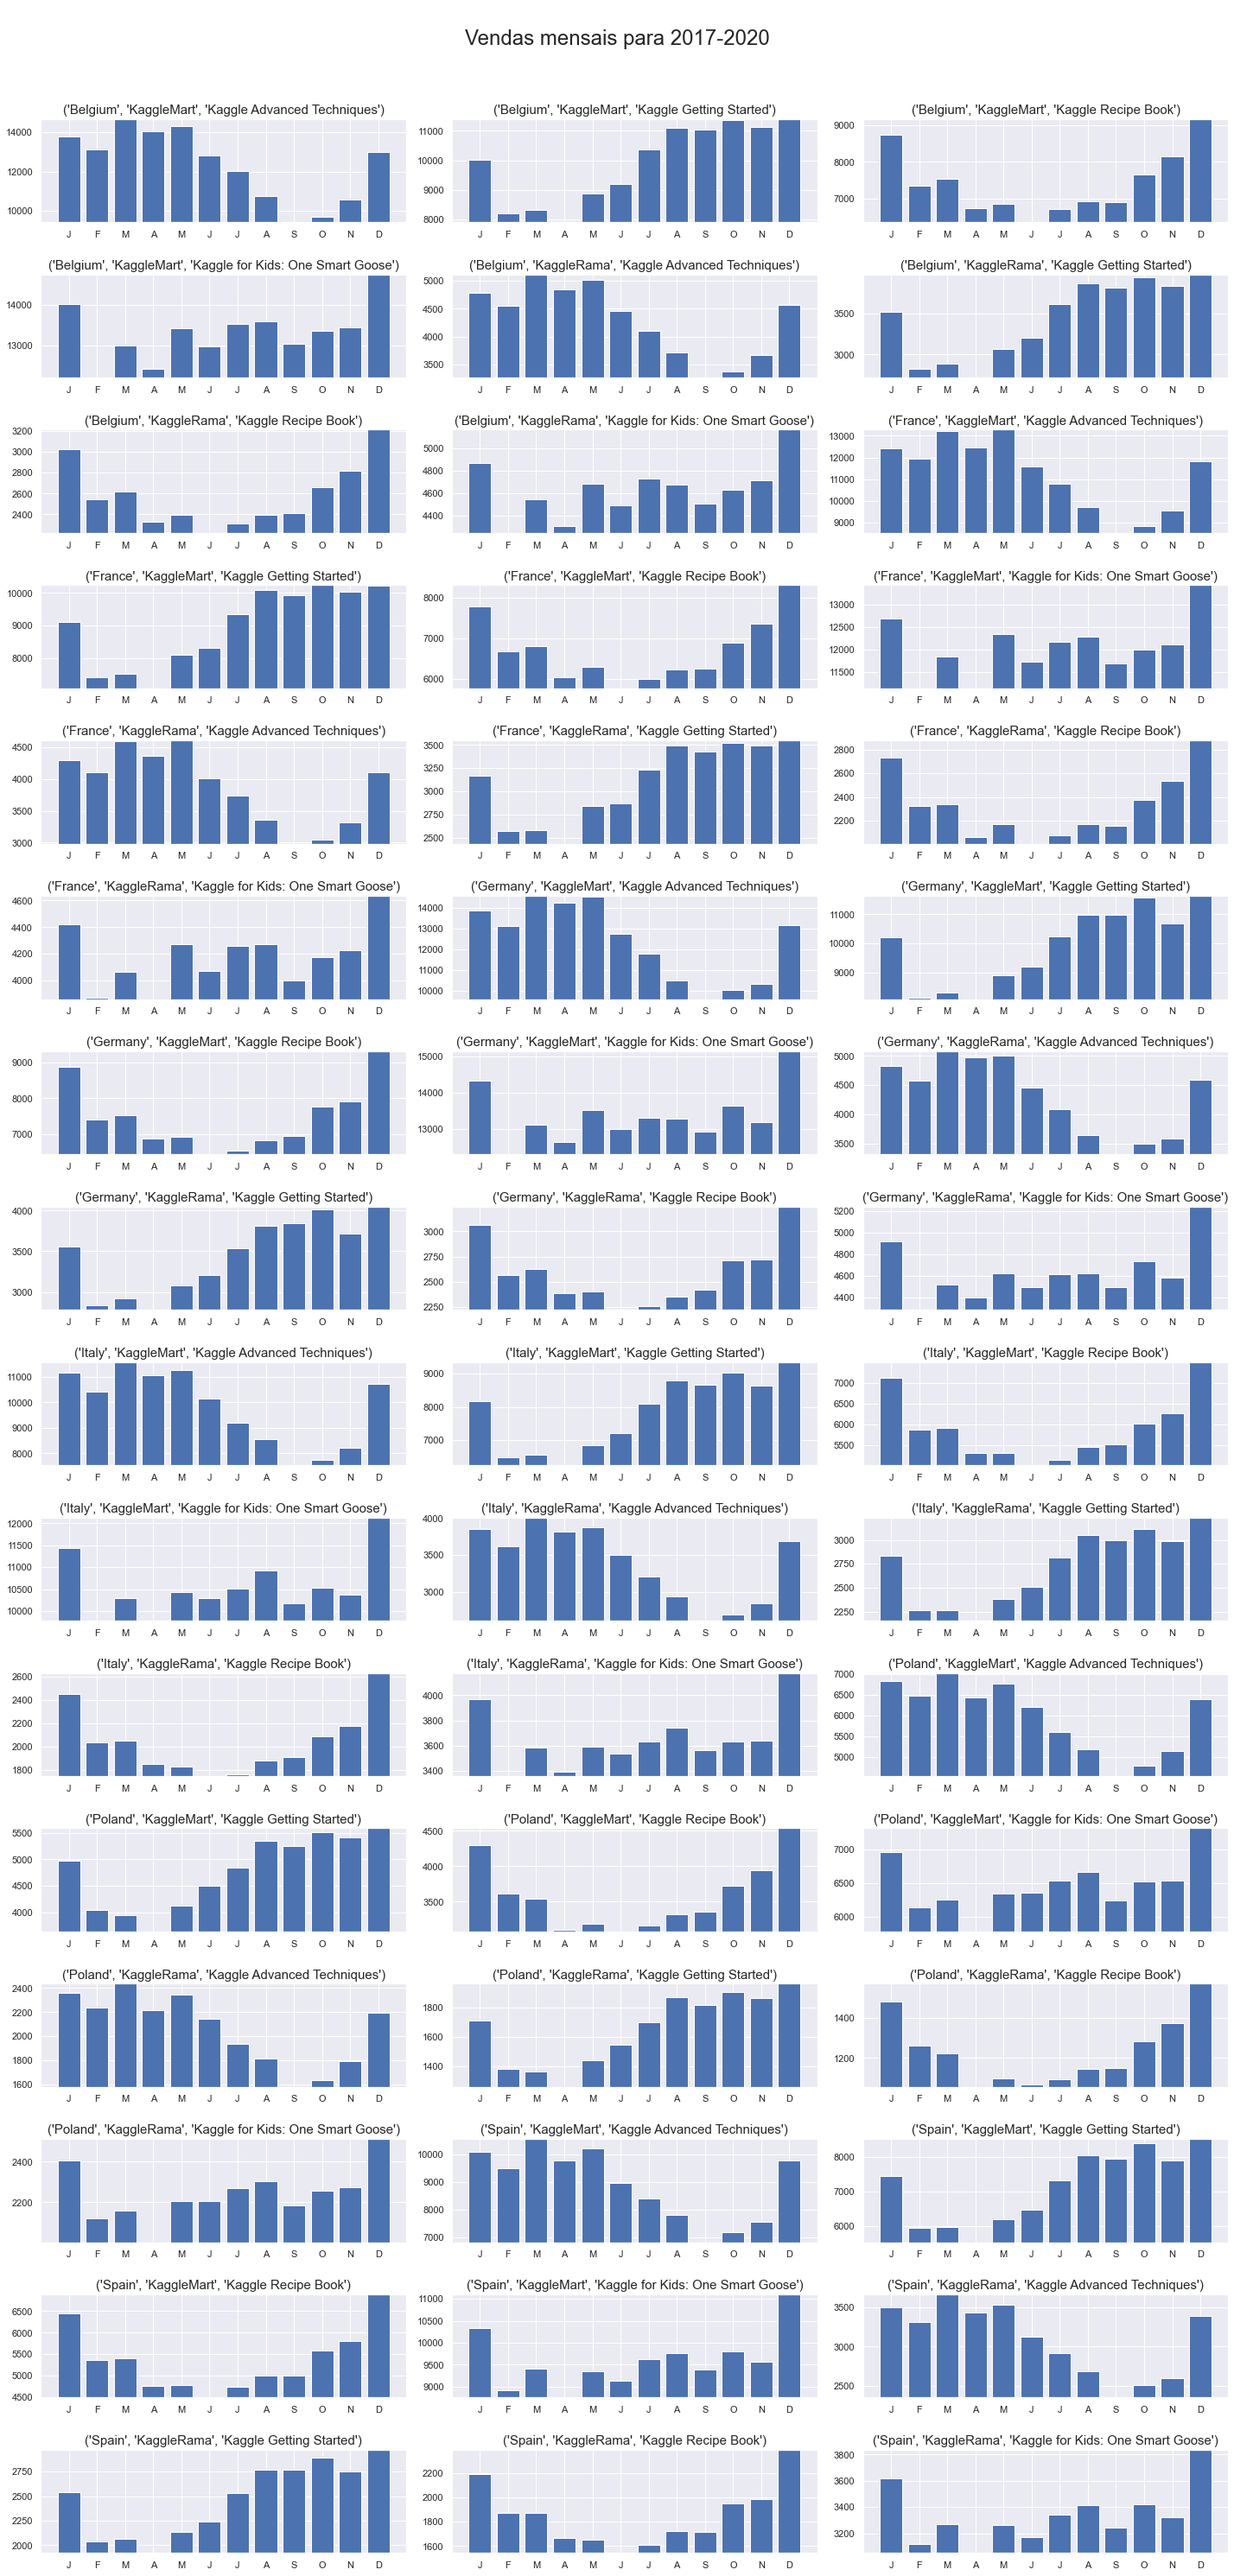

In [516]:
plt.figure(figsize=(20, 40))

for i, (combi, df) in enumerate(df2_train.groupby(['country', 'store', 'product'])):
    ax = plt.subplot(16, 3, i+1, ymargin=0.5)
    resampled = df.set_index('date').resample('MS').sum()
    resampled = resampled.groupby(resampled.index.month).mean()
    ax.bar(range(1, 13), resampled.num_sold, align='center')   
    ax.set_title(combi, loc="center", fontsize=15)
    ax.set_ylim(resampled.num_sold.min(), resampled.num_sold.max())    
    ax.set_xticks(ticks=range(1, 13)) 
    ax.set_xticklabels('JFMAMJJASOND')
    # plt.yscale('log', basey=2)
    plt.tight_layout(h_pad=2.0)
    
plt.suptitle('\nVendas mensais para 2017-2020', y=1.035, fontsize=24);

<div class="alert alert-block alert-info">
<p style="color: black; font-family: Arial Black">NOTA:</p>

Podemos destacar os seguintes ponto em relação aos gráficos acima:   
- Um ponto interessante que podemos destacar é que em um ou dois meses do ano temos uma baixa nas vendas; 
- Todos os produtos tem sazonalidades diferentes durante o ano. <p><br>  
  
    
<b>OBSERVAÇÃO:</b><br>
Como temos diversos padrões nos dados, devemos nos preocupar em modelar esses padrões levando em consideração o mês. <p><br>        
</div>

---

### 2.9.4. Mensal

In [ ]:
plt.figure(figsize=(20, 40))

for i, (combi, df) in enumerate(df2_train.groupby(['country', 'store', 'product'])):
    ax = plt.subplot(16, 3, i+1, ymargin=0.5)
    resampled = df.set_index('date').resample('MS').sum()
    resampled = resampled.groupby(resampled.index.month).mean()
    ax.bar(range(1, 13), resampled.num_sold, align='center')   
    ax.set_title(combi, loc="center", fontsize=15)
    ax.set_ylim(resampled.num_sold.min(), resampled.num_sold.max())    
    ax.set_xticks(ticks=range(1, 13)) 
    ax.set_xticklabels('JFMAMJJASOND')
    # plt.yscale('log', basey=2)
    plt.tight_layout(h_pad=2.0)
    
plt.suptitle('\nVendas mensais para 2017-2020', y=1.035, fontsize=24);

---

### 2.9.5. Dia da semana

In [ ]:
plt.figure(figsize=(20, 40))

for i, (combi, df) in enumerate(df2_train.groupby(['country', 'store', 'product'])):
    ax = plt.subplot(16, 3, i+1, ymargin=0.5)
    resampled = df.groupby(df.date.dt.dayofweek).mean()
    ax.bar(range(7), resampled.num_sold, color=['b']*4+['g']+['orange']*2)    
    ax.set_title(combi, loc="center", fontsize=15)  
    ax.set_ylim(0, resampled.num_sold.max())    
    ax.set_xticks(ticks=range(7)) 
    ax.set_xticklabels(['M', 'T', 'W', 'T', 'F', 'S', 'S'])
    plt.tight_layout(h_pad=2.0);
    
plt.suptitle('\nVendas por dia da semana',  y=1.03, fontsize=24);

del resampled

<div class="alert alert-block alert-info">
<p style="color: black; font-family: Arial Black">NOTA:</p>

Sábados e domingos são os melhores dias (maiores vendas) para todos os produtos, sexta-feira parece ser melhor do que de segunda a quinta-feira. <p> <br>        
    
<b>OBSERVAÇÃO:</b><br>
Nosso modelo precisa distinguir pelo menos três fases da semana: Seg-Qui, Sex, Sáb-Dom. <P><BR>
    
</div>

---

### 2.9.5. Páscoa


In [ ]:
plt.figure(figsize=(18, 12))

for i, (year, df) in enumerate(df2_train.groupby(df2_train.date.dt.year)):
    
    df          = df.reset_index(drop=True)
    ax          = plt.subplot(4, 1, i+1, ymargin=0.5)
    april       = df.num_sold[(df.date.dt.month==4)].groupby(df.date.dt.day).mean()
    date_range  = pd.date_range(start=f'{year}-04-01', end=f'{year}-04-30', freq='D')
    easter_date = easter.easter(year)
    
    color = ['r' 
             if d==easter_date else 'lightblue' 
             if (d.date()-easter_date).days in range(6) else 'b'
             if d.dayofweek<5 else 'orange' 
             for d in date_range]
    
    ax.bar(range(1, 31), april, color=color)    
    ax.set_title(str(year))
    ax.set_xticks(ticks=range(5, 31, 5))
    plt.tight_layout(h_pad=2.0)
    
plt.suptitle('\nVendas diárias de abril', y=1.09, fontsize=24);

<div class="alert alert-block alert-info">
<p style="color: black; font-family: Arial Black">NOTA:</p>

    
Nos gráricos acima mostramos as vendas diárias de abril dos quantro anos, os fins de semana são de cor laranja, o domingo de Páscoa é marcado em vermelho, a semana após a Páscoa é de cor azul clara, observamos que após a semana de  Páscoa as vendas são maiores que o normal até o próximo domingo, voltando ao normal na semana seguinte. <p><br>
    
<b>OBSERVAÇÃO:</b><br>
O modelo deve saber a data da Páscoa e contabilizar maior demanda na semana após a Páscoa. <p><br>

</div>

<div style="color:white;border-radius:8px;background-color:#a7d5ed">    
    <h1 style="padding:12px;color:black;"> 3. Engenharia de recursos simples</h1>    
</div>

Neste modelo simples (baseline), consideramos o seguinte:
- país, loja, produto
- dias úteis
- variações sazonais por produto como uma série de Fourier com comprimentos de onda de 1 ano até 18 dias

Os resíduos desse modelo simples nos permitirão entender o efeito dos feriados.

## 3.1. Feature

In [47]:
def features_lag(df_tr_, df_ts_, target_): 
    
    cols = ['country','store', 'product', 'prev_year', 
            'month', 'day', 'fe_num_sold_lag_1']
        
    trn_data = df_tr_.copy()
    tst_data = df_ts_.copy()

    for df in [trn_data, tst_data]:
        df['year']  = df['date'].dt.year.astype(int)
        df['month'] = df['date'].dt.month.astype(int)
        df['day']   = df['date'].dt.day.astype(int)
        
    trn_data['is_train']  = 1
    tst_data['is_train']  = 0    
    merge_data            = trn_data.append(tst_data)
    
    tmp = merge_data.copy(deep = True)
    
    tmp['prev_year']         = (tmp['year'] + 1).astype('int') 
    tmp['fe_num_sold_lag_1'] = tmp[target_]
    tmp                      = tmp[cols]
    
    merge_data = merge_data.merge(tmp, 
                                  how      = 'left', 
                                  left_on  = ['country','store', 'product', 'year', 'month', 'day'],
                                  right_on = ['country','store', 'product', 'prev_year', 'month', 'day'])
    
    merge_data = merge_data.drop(columns=['prev_year'])
    trn_data   = merge_data[merge_data['is_train'] == 1] 
    tst_data   = merge_data[merge_data['is_train'] == 0].drop(columns = ['num_sold'])

    cols_drop = ['year','month','day','is_train']
    trn_data.drop(cols_drop, axis=1 , inplace=True)
    tst_data.drop(cols_drop, axis=1 , inplace=True)
    
    return trn_data, tst_data

In [48]:
def feature_calc_mean_encoded(trn_df, tst_df, groups=['country'], target='num_sold', 
                              feature_name='mean_enc_country'):

    tmp    = trn_df.groupby(groups)[target].mean().reset_index()
    tmp    = tmp.rename(columns={target: feature_name})
    trn_df = trn_df.merge(tmp, how='left', on=groups)
    tst_df = tst_df.merge(tmp, how='left', on=groups)

    return trn_df, tst_df

In [49]:
def feature_map_holydays(df_, years_list_=[], countries_=[]):

    countries = [('Belgium', 'BE'), ('France', 'FR'), 
                 ('Germany', 'DE'), ('Italy', 'IT'), 
                 ('Poland', 'PL'), ('Spain', 'ES')]

    df_['fe_holiday_name'] = np.nan
    df_['fe_is_holiday']   = np.nan
    df_['fe_holiday_name'] = np.nan

    for country in countries:
        dic_holidays = holidays.CountryHoliday(country[0], years=years_list_)
        df_['fe_holiday_name'][df_['country']==country[0]] = df_['date'].map(dic_holidays)
        df_['fe_is_holiday'][df_['country']==country[0]]   = np.where(df_['fe_holiday_name'].notnull(), 1, 0)
        df_['fe_holiday_name'][df_['country']==country[0]] = df_['fe_holiday_name'].fillna('Not Holiday')

    df_['fe_is_holiday'] = df_['fe_is_holiday'].astype(int)
    df_.drop(['fe_holiday_name'], axis=1, inplace=True)

    return df_

In [50]:
def create_features_(df, target):

    def gpd(df):
        df_temp = pd.DataFrame()
        for col in df_gdp.columns[1:]: 
            df_ = df_gdp[['year',col]]
            df_.columns = ['year', 'gpd']
            df_['country'] = str.replace(col, 'GDP_','')
            df_temp = pd.concat([df_temp, df_], axis=0)
          
        df        = pd.merge(df, df_temp, on=['country', 'year'], how='left') 
        df['gpd'] = np.log(df['gpd'])
        
        return df
    
    df['fe_hour']          = df['date'].dt.hour.astype(int)
    df['fe_day_of_week']   = df['date'].dt.dayofweek.astype(int)
    df['fe_quarter']       = df['date'].dt.quarter.astype(int)
    df['fe_month']         = df['date'].dt.month.astype(int)
    df['fe_year']          = df['date'].dt.year.astype(int)
    df['fe_day_of_year']   = df['date'].dt.dayofyear.astype(int)
    df['fe_day_of_month']  = df['date'].dt.day.astype(int)
    df['fe_week_of_year']  = df['date'].dt.isocalendar().week.astype(int)
    df['fe_week_of_month'] = df['week_of_year'].values // 4.35
    #df                  = gpd(df)
    
    # day labeling features                                                                       
    df['fe_is_mon'] = np.where(df['day_of_week'] == 1, 1, 0)                                                                                            
    df['fe_is_tue'] = np.where(df['day_of_week'] == 2, 1, 0)                                                                                         
    df['fe_is_wed'] = np.where(df['day_of_week'] == 3, 1, 0)                                                                                         
    df['fe_is_thu'] = np.where(df['day_of_week'] == 4, 1, 0)                                                                                         
    df['fe_is_fri'] = np.where(df['day_of_week'] == 5, 1, 0)                                                                                         
    df['fe_is_sat'] = np.where(df['day_of_week'] == 6, 1, 0)                                                                                         
    df['fe_is_sun'] = np.where(df['day_of_week'] == 7, 1, 0)   
    
    df['fe_is_wknd']        = df['date'].dt.weekday // 4
    df['fe_is_month_start'] = df['date'].dt.is_month_start.astype(int)
    df['fe_is_month_end']   = df['date'].dt.is_month_end.astype(int)
    
    
    df['fe_amount_time']  = df['fe_month']*100 + df_tmp['day']
    df['fe_special_days'] = df['fe_amount_time'].isin([101,1228,1229,1230,1231]).astype(int)
    
    '''
    df['lag_6_hrs']   = df[target].shift(6)
    df['lag_12_hrs']  = df[target].shift(12)
    df['lag_24_hrs']  = df[target].shift(24)
    
    df['mean_6_hrs']  = df[target].rolling(window = 6).mean()
    df['mean_12_hrs'] = df[target].rolling(window = 12).mean()
    df['mean_24_hrs'] = df[target].rolling(window = 24).mean()
    df['std_6_hrs']   = df[target].rolling(window = 6).std()
    df['std_12_hrs']  = df[target].rolling(window = 12).std()
    df['std_24_hrs']  = df[target].rolling(window = 24).std()
    df['max_6_hrs']   = df[target].rolling(window = 6).max()
    df['max_12_hrs']  = df[target].rolling(window = 12).max()
    df['max_24_hrs']  = df[target].rolling(window = 24).max()
    df['min_6_hrs']   = df[target].rolling(window = 6).min()
    df['min_12_hrs']  = df[target].rolling(window = 12).min()
    df['min_24_hrs']  = df[target].rolling(window = 24).min()
    '''
        
    # generating some new features from aggregation of sales within different time frames
    # https://www.kaggle.com/hikmetsezen/base-model-with-lightgbm-on-demand-forecasting
    shift_values = [0, 0, 0, 0, 0, 0, 12, 12]
    feat_list    = ['day_of_week', 'week_of_month', 'week_of_year', 'month', 
                    'quarter', 'is_wknd', 'day_of_week', 'week_of_month']
    

    #for time_item, shift_val in zip(feat_list, shift_values):
        #print(shift_val)
        # 'country','store','product'
        
        #grouped_df = df.groupby(['store', 'item', time_item])['sales'].expanding().mean().shift(shift_val).bfill().reset_index()
        #grouped_df.columns = ['store', 'item', time_item, 'date', time_item + f'_ex_avg_sale{str(shift_val)}']
        #grouped_df = grouped_df.sort_values(by=['item', 'store', 'date'])
        #df[time_item + f'_ex_avg_sale{str(shift_val)}'] = grouped_df[time_item + f'_ex_avg_sale{str(shift_val)}'].values
    
    # Easter
    easter_date = df.date.apply(lambda date: pd.Timestamp(easter.easter(date.year)))
    df['fe_days_from_easter'] = (df.date - easter_date).dt.days.clip(-3, 59)
    df.loc[df['fe_days_from_easter'].isin(range(12, 39)), 'fe_days_from_easter'] = 12 # reduce overfitting
   
    '''
    # 
    wed_june_date = df.date.dt.year.map({2015: pd.Timestamp(('2015-06-24')),
                                         2016: pd.Timestamp(('2016-06-29')),
                                         2017: pd.Timestamp(('2017-06-28')),
                                         2018: pd.Timestamp(('2018-06-27')),
                                         2019: pd.Timestamp(('2019-06-26'))})

    df['days_from_wed_jun'] = (df.date - wed_june_date).dt.days.clip(-5, 5)
    
    
    # First Sunday of November (second Sunday is Father's Day)
    sun_nov_date = df.date.dt.year.map({2015: pd.Timestamp(('2015-11-1')),
                                         2016: pd.Timestamp(('2016-11-6')),
                                         2017: pd.Timestamp(('2017-11-5')),
                                         2018: pd.Timestamp(('2018-11-4')),
                                         2019: pd.Timestamp(('2019-11-3'))})
     '''
    #df['days_from_sun_nov'] = (df.date - sun_nov_date).dt.days.clip(-1, 9)

    day  = 24*60*60
    year = (365.2425)*day

    timestamp_s       = pd.to_datetime(df['date'], format='%d.%m.%Y %H:%M:%S')
    timestamp_s       = timestamp_s.map(pd.Timestamp.timestamp)
    df['fe_day_sin']  = np.sin(timestamp_s*(2*np.pi/day))
    df['fe_day_cos']  = np.cos(timestamp_s*(2*np.pi/day))
    df['fe_year_sin'] = np.sin(timestamp_s*(2*np.pi/year))
    df['fe_year_cos'] = np.cos(timestamp_s*(2*np.pi/year))

    # Realizando os limitadores de marcação de outlier
    superior         = df[target].quantile(0.95)
    inferior         = df[target].quantile(0.05)
    df['fe_outlier'] = np.where(df[target]>superior,1,np.where(df[target]<inferior,-1,0))
        
    # season:
    # - Winter -> December (12), January (01) and February (02);
    # - Spring -> March (03), April (04) and May (05);
    # - Summer -> Jun (06), July (07) and August (08);
    # - Autumn -> September (09), October (10) and November (11).
    df['fe_season'] = df['date'].apply(lambda x: 'fe_winter' 
                                              if 
                                                  x.month == 12 or x.month == 1 or 
                                                  x.month == 2 else 'fe_spring' 
                                              if  
                                                  x.month == 3 or x.month == 4 or 
                                                  x.month == 5 else 'fe_summer' 
                                              if  
                                                  x.month == 6 or x.month == 7 or 
                                                  x.month == 8 else 'fe_autumn' 
                                              if  
                                                  x.month == 9 or x.month == 10 or 
                                                  x.month == 11 else 'fe_others')


    # Feriado:
    # Usarei a biblioteca "feriados" para identificar se a data representa um feriado. Uma ideia para um próximo ciclo no projeto é diferenciar, de acordo com alguma regra, as diferentes datas dos feriados.
    # A documentação desta biblioteca está neste link: https://pypi.org/project/holidays/
    # Outra regra que vou usar é considerar a véspera das datas como um "feriado".
    # 
    # Bélgica		SER
    # França		FR
    # Alemanha	DE
    # Itália		ISTO
    # Polônia		PL
    # Espanha		ES
    
    '''
    df['holidays'] = df['date'].apply(lambda x: 1 
                                      if x in holidays.US() else 1 
                                      if x + datetime.timedelta(days=1) 
                                      in holidays.US() else 0)

    '''
    col_dammy = ['season', 'country', 'store', 'product']
    
    df = pd.concat([df, pd.get_dummies(df[col_dammy],  prefix='', prefix_sep='')], axis=1) 
    
    df = df.dropna()
    #y = X[target]

    # Seasonal variations (Fourier series)
    # The three products have different seasonal patterns
    dayofyear = df.date.dt.dayofyear
    for k in range(1, 3):
        df[f'sin{k}'] = np.sin(dayofyear / 365 * 2 * np.math.pi * k)
        df[f'cos{k}'] = np.cos(dayofyear / 365 * 2 * np.math.pi * k)
        df[f'mug_sin{k}'] = df[f'sin{k}'] * df['Kaggle Mug']
        df[f'mug_cos{k}'] = df[f'cos{k}'] * df['Kaggle Mug']
        df[f'hat_sin{k}'] = df[f'sin{k}'] * df['Kaggle Hat']
        df[f'hat_cos{k}'] = df[f'cos{k}'] * df['Kaggle Hat']
        
    col_dammy.append('date')
    #col_dammy.append(target)
    df.drop(col_dammy, axis=1 , inplace=True)
    
    df = reduce_memory_usage(df)
    
    return df

In [51]:
def get_fourier_features(df):
    # Time period = 2 years
    dayofbiyear = df['date'].dt.dayofyear + 365*(1-(df['date'].dt.year%2))  # 1 to 730
    
    # k=1 -> 2 years, k=2 -> 1 year, k=4 -> 6 months
    for k in [1, 2, 4]:
        df[f'sin{k}'] = np.sin(2 * np.pi * k * dayofbiyear / (2* 365))
        df[f'cos{k}'] = np.cos(2 * np.pi * k * dayofbiyear / (2* 365))
        
        # Different products have different seasonality patterns
        for product in df['product'].unique():
            df[f'sin_{k}_{product}'] = df[f'sin{k}'] * (df['product']==product)
            df[f'cos_{k}_{product}'] = df[f'cos{k}'] * (df['product']==product)
        
        df=df.drop([f'sin_{k}', f'cos_{k}'], axis=1)
    
    return df

In [507]:
def create_features(df_tr_, df_ts_, feature_lencoder_=[], feature_dammy_=[], target_=target):
         
    def dammy(df_):    
        
        for col in df_.select_dtypes(object).columns[:]:        
            for col_ in df_[col].unique()[:-1]:
                df_[col_] = (df_[col]==col_).astype(int)  
            df_.drop(col, axis=1, inplace=True)
            
        return df_
       
    def fourier_series(df_):
        
        # Variações sazonais (série Fourier)        
        df_['date'] = df_['date'].astype(np.datetime64) 
        
        # Time period = 2 years
        dayofyear = df_['date'].dt.dayofyear + 365*(1-(df_['date'].dt.year%2))  # 1 to 730
            
        # k=1 -> 2 years, k=2 -> 1 year, k=4 -> 6 months
        for k in [1, 2, 4]:
            
            df_[f'fe_sin_{k}'] = np.sin(2*np.pi*k*dayofyear/(2*365))
            df_[f'fe_cos_{k}'] = np.cos(2*np.pi*k*dayofyear/(2*365))
            
            # Os produtos têm padrões sazonais diferentes                        
            for product in df_['product'].unique():
                df_[f'fe_sin_{k}_{product}']=df_[f'fe_sin_{k}']*(df_['product']==product)
                df_[f'fe_cos_{k}_{product}']=df_[f'fe_cos_{k}']*(df_['product']==product)

            df_.drop([f'fe_sin_{k}', f'fe_cos_{k}'], axis=1, inplace=True)
        
        return df_

    def label_encoder(df_, col_): 
        le = LabelEncoder()   
        for col in col_:
            df_[col] = le.fit_transform(df_[col])        
        return df_, 
    
    def feature_label_encoder(df_tr_, df_ts_, feture_):        
        for c in feture_:
            le = LabelEncoder()            
            le.fit(df_tr_[c])
            df_tr_[c] = le.transform(df_tr_[c])
            df_ts_[c] = le.transform(df_ts_[c])            
        return df_tr_, df_ts_
    
    def feature_time(df_):         
        
        df_['fe_quarter']        = df_['date'].dt.quarter.astype(int)
        df_['fe_day_of_year']    = df_['date'].dt.dayofyear.astype(int)        
        df_['fe_day_of_week']    = df_['date'].dt.dayofweek.astype(int)        
        df_['fe_month']          = df_['date'].dt.month.astype(int)
        df_['fe_year']           = df_['date'].dt.year.astype(int)        
        df_['fe_day_of_month']   = df_['date'].dt.day.astype(int)
        df_['fe_week_of_year']   = df_['date'].dt.isocalendar().week.astype(int)
        df_['fe_week_of_month']  = (df_['fe_week_of_year'].values//4.35).astype(int)        
        df_['fe_is_month_start'] = df_['date'].dt.is_month_start.astype(int)
        df_['fe_is_month_end']   = df_['date'].dt.is_month_end.astype(int) 
        #df_['fe_is_end_of_year'] = (df_['date'].dt.dayofyear.astype(int)>=359).astype(int)      

        # Marca o dia da semana
        df_['fe_is_mon']     = np.where(df_['fe_day_of_week'] == 1, 1, 0)                                                                                            
        df_['fe_is_tue']     = np.where(df_['fe_day_of_week'] == 2, 1, 0)                                                                                         
        df_['fe_is_wed']     = np.where(df_['fe_day_of_week'] == 3, 1, 0)                                                                                         
        df_['fe_is_thu']     = np.where(df_['fe_day_of_week'] == 4, 1, 0)                                                                                         
        df_['fe_is_fri']     = np.where(df_['fe_day_of_week'] == 5, 1, 0)                                                                                         
        df_['fe_is_sat']     = np.where(df_['fe_day_of_week'] == 6, 1, 0)  
        df_['fe_is_fri_sat'] = (df_['date'].dt.weekday >= 5).astype(int)  # Saturday and Sunday
        
        # Seno e Coseno 5.78276 sem 5.64171
        #df_['fe_month_sin'] = np.sin(df_['fe_month'] * (2 * np.pi / 12))
        #df_['fe_month_cos'] = np.cos(df_['fe_month'] * (2 * np.pi / 12))

        dt_impo = [1,2,3,4,5,6,7,8,125,126,360,361,362,363,364,365]
        df_["fe_important_dates"] = df_["fe_day_of_year"].apply(lambda x: x if x in dt_impo else 0)
        
        #df_ = pd.get_dummies(df_, columns=["fe_important_dates","fe_day_of_week"], drop_first=True)
    
        return df_
    
    df_tr_['date'] = df_tr_['date'].astype(np.datetime64)
    df_ts_['date'] = df_ts_['date'].astype(np.datetime64)

    # --------------------------------------------
    # Feriado 
    # --------------------------------------------
    countries  = ['BE', 'FR', 'DE', 'IT', 'PL', 'ES' ]   
    years_list = [2017, 2018, 2019, 2020, 2021] 

    df_tr_ = feature_map_holydays(df_tr_.copy(), years_list, countries)
    df_ts_ = feature_map_holydays(df_ts_.copy(), years_list, countries)

    # * df_tr_, df_ts_ = features_lag(df_tr_, df_ts_, target_)
    
    # --------------------------------------------
    # Conversão da data em variáveis temporais
    # --------------------------------------------
    df_tr_ = feature_time(df_tr_) 
    df_ts_ = feature_time(df_ts_)
    
    for feture in feature_lencoder_: 
        df_tr_, df_ts_ = feature_label_encoder(df_tr_, df_ts_, feature_lencoder_)
    
    # --------------------------------------------
    # Fourier 
    # --------------------------------------------
    #df_tr_ = fourier_series(df_tr_)
    #df_ts_ = fourier_series(df_ts_)
        
    # --------------------------------------------
    # Target encoding 
    # --------------------------------------------
    feature_gr_encoder = [(['country'], 'fe_mean_enc_country'), 
                          #(['store'], 'fe_mean_enc_store'), 
                          (['product'], 'fe_mean_enc_product'), 
                          (['fe_month'], 'fe_mean_enc_month'), 
                         # (['fe_day_of_week'], 'fe_mean_enc_dayofweek'), 
                         # (['country', 'store', 'product'], 'fe_mean_enc_csp')
                         ]

    # for fe in feature_gr_encoder:
    #     df_tr_, df_ts_ = feature_calc_mean_encoded(df_tr_,
    #                                                df_ts_, 
    #                                                groups       = fe[0], 
    #                                                target       = target, 
    #                                                feature_name = fe[1])

    y = df_tr_[target]
    
    df_tr_.drop(target, axis=1, inplace=True)
    df_tr_[target] = y
    
    df_tr_ = df_tr_.dropna()
    df_ts_ = df_ts_.dropna() 
    df_tr_ = df_tr_.reset_index()
    df_tr_.drop('index', axis=1, inplace=True)

    df_tr_.drop('date', axis=1 , inplace=True)
    df_ts_.drop('date', axis=1 , inplace=True)
    
    feature_drop_corr = ['fe_day_of_year', 'fe_week_of_month', 'fe_week_of_year'                        
                        ] # 'fe_day_of_year', 
        
    df_tr_.drop(feature_drop_corr, axis=1, inplace=True) 
    df_ts_.drop(feature_drop_corr, axis=1, inplace=True) 
    
    #df_tr_ = utility.reduce_memory_usage(df, verbose=False)
        
    #df = gpd(df.copy())
    #df = dammy(df.copy())
    #df = fourier_series(df.copy())
    
    return df_tr_, df_ts_

In [508]:
df3_train = df2_train.copy()
df3_test  = df2_test.copy()

feature_lencoder = ['country', 'store', 'product']

df3_train, df3_test = \
    create_features(df_tr_            = df3_train, 
                    df_ts_            = df3_test, 
                    feature_lencoder_ = feature_lencoder, 
                    feature_dammy_    = [], 
                    target_           = target)
    
display(df3_train.shape , df3_test.shape) 
display(df3_train.info())

display(df3_train.head())
# ((52560, 25), (17520, 24))

(70128, 20)

(17520, 19)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70128 entries, 0 to 70127
Data columns (total 20 columns):
 #   Column              Non-Null Count  Dtype
---  ------              --------------  -----
 0   country             70128 non-null  int64
 1   store               70128 non-null  int64
 2   product             70128 non-null  int64
 3   fe_is_holiday       70128 non-null  int32
 4   fe_quarter          70128 non-null  int32
 5   fe_day_of_week      70128 non-null  int32
 6   fe_month            70128 non-null  int32
 7   fe_year             70128 non-null  int32
 8   fe_day_of_month     70128 non-null  int32
 9   fe_is_month_start   70128 non-null  int32
 10  fe_is_month_end     70128 non-null  int32
 11  fe_is_mon           70128 non-null  int32
 12  fe_is_tue           70128 non-null  int32
 13  fe_is_wed           70128 non-null  int32
 14  fe_is_thu           70128 non-null  int32
 15  fe_is_fri           70128 non-null  int32
 16  fe_is_sat           70128 non-null  int3

None

country  store  product  fe_is_holiday  fe_quarter  fe_day_of_week  \
0        0      0        0              1           1               6   
1        0      0        1              1           1               6   
2        0      0        2              1           1               6   
3        0      0        3              1           1               6   
4        0      1        0              1           1               6   

   fe_month  fe_year  fe_day_of_month  fe_is_month_start  fe_is_month_end  \
0         1     2017                1                  1                0   
1         1     2017                1                  1                0   
2         1     2017                1                  1                0   
3         1     2017                1                  1                0   
4         1     2017                1                  1                0   

   fe_is_mon  fe_is_tue  fe_is_wed  fe_is_thu  fe_is_fri  fe_is_sat  \
0          0          0          0          0          0          1   
1          0          0          0          0          0          1   
2          0          0          0          0          0          1   
3          0          0          0          0          0          1   
4          0          0          0          0          0          1   

   fe_is_fri_sat  fe_important_dates  num_sold  
0              1                   1       663  
1              1                   1       615  
2              1                   1       480  
3              1                   1       710  
4              1                   1       240

---

## 3.1. Gráfico de correlação

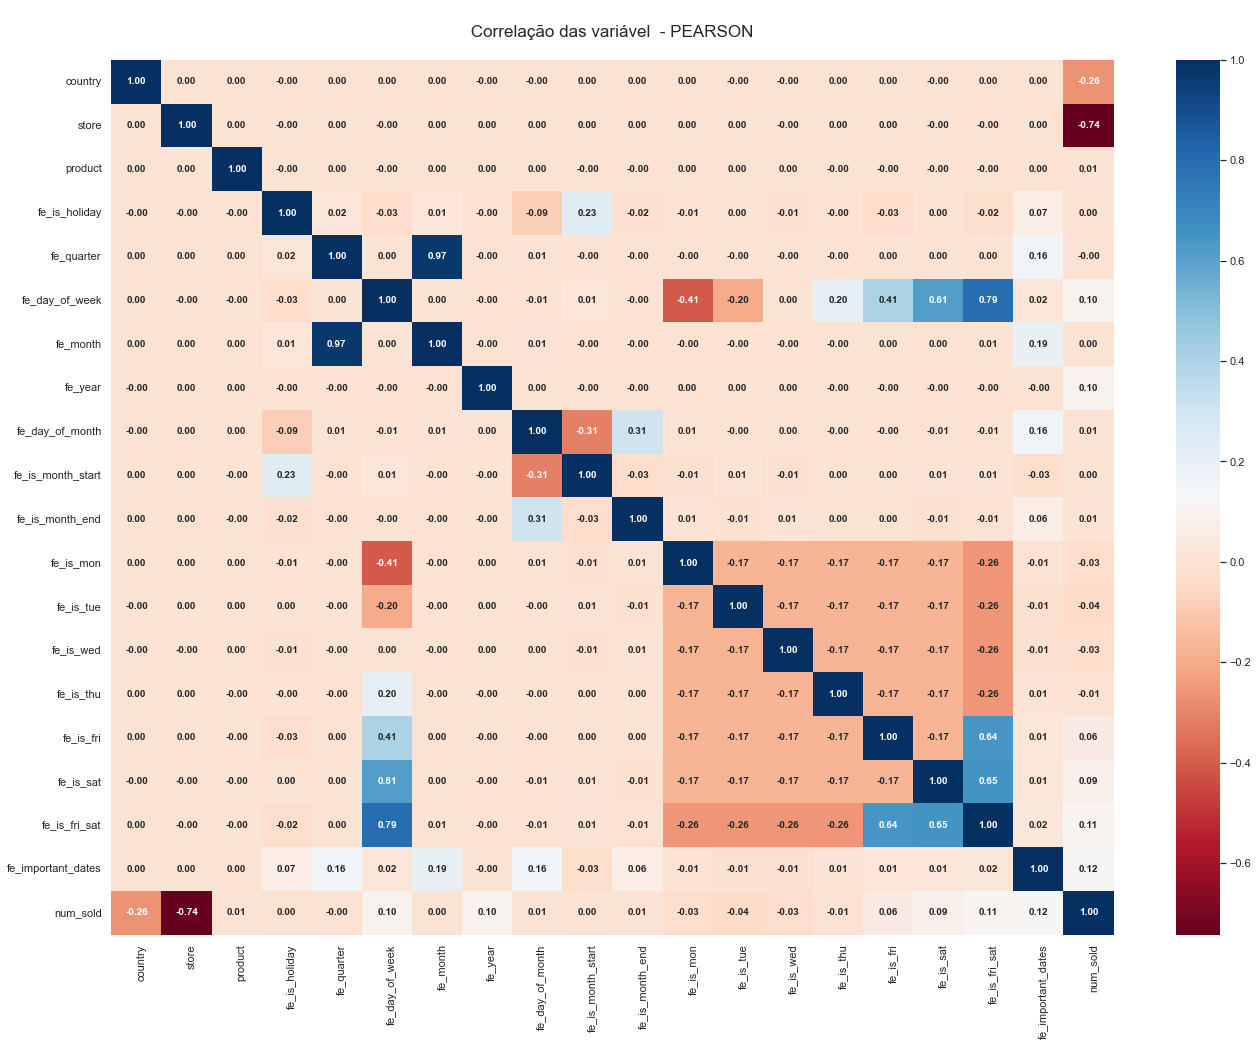

{'fe_month'}

In [509]:
plt.figure(figsize=(20,15))

utility.graf_feature_corr(df3_train,
                          annot_      = True,
                          threshold_  = 0.8,
                          print_var_  = False,
                          print_graf_ = True,
                          mask_       = False)

<div class="alert alert-block alert-info">
<p style="color: black; font-family: Arial Black">NOTA:</p>

Observamos acima que temos variáveis autocorrelacionadas, neste primeiro momento não vamos removê-las.   
    
</div>

___

<div style="color:white;border-radius:8px;background-color:#a7d5ed">    
    <h1 style="padding:12px;color:black;"> 4. Modelagem (baseline)</h1>    
</div>

Como baseline vamos fazer um modelo com poucas variáveis transformadas em relação ao tempo, no próximo notebook(Feature engineering) vamos criar novas variáveis, com base nos insights desta EDA, abaixo foi criado um um função para gerar as nova variáveis.

## 3.2. Treinar o modelo

Vamos treinar o modelo nos dados de treinamento completo, a validação crzuzada virá mais tarde, neste momento vamos definir uma baseline. 


In [505]:
seed       = 12359
params_xgb = {# 'objective'        : 'reg:squarederror', 
          # 'eval_metric'      : 'rmse', 
          # 'n_estimators'     : 1000,         
          # 'max_depth'        : 4, 
          # 'learning_rate'    : .01, 
          # 'subsample'        : 0.7, 
          # 'colsample_bytree' : 0.8, 
          # 'reg_alpha'        : 0.9,           
          'random_state'     : seed}

if torch.cuda.is_available():           
    params_xgb.update({'tree_method': 'gpu_hist','predictor': 'gpu_predictor'})
    
model_xgb = xgb.XGBRegressor(**params_xgb)

params_ctb = {'depth': 6,
          'learning_rate': 0.02,
          'l2_leaf_reg': 20.0,
          'random_strength': 2.0,
          'min_data_in_leaf': 2}
    
model_catboost = CatBoostRegressor(**params_ctb,
                                      iterations=5000,
                                      bootstrap_type='Bayesian',
    #                                   boosting_type='Plain',
                                      loss_function='MAE',
                                      eval_metric='SMAPE',
                                      random_state=seed)    
    
param_lgb = {"objective": "regression",
             "n_estimators": 99999, 
             'random_state': seed
            }    

model_lgbm = lgb.LGBMRegressor(**param_lgb)

param_rf   = {
    'n_estimators'      : 500, 
    'criterion'         : 'squared_error', 
    'min_samples_split' : 10, 
    'max_features'      : .8,      
    'max_samples'       : .7, 
    #'max_depth'         : 7,              
    'random_state'      : seed, 
    'n_jobs'            : -1}

model_rf   = RandomForestRegressor(**param_rf)

model_ridge =  Ridge(alpha=0.1, solver='sag')

model_hgb = HistGradientBoostingRegressor(random_state=seed)

In [462]:
def delete_files(namefile):

        path = ['model/train', 'model/test', 'model/valid', 'model/params', 'model/score',
                'model/test_f', 'model/cv_model', 'model/preds', 'model/optuna', 
                'model/preds/train', 'model/preds/test', 'model/preds/test/n1', 
                'model/preds/test/n2', 'model/preds/test/n3', 'model/preds/train/n1', 
                'model/preds/train/n2', 'model/preds/train/n3','model/preds/param', 
                'Data/submission/tunning', 'Data/submission', 'model/mdl'
                
               ]

        for path_ in path:
            for raiz, diretorios, arquivos in os.walk(path_):
                for arquivo in arquivos:
                    if arquivo.startswith(namefile):                    
                        os.remove(os.path.join(raiz, arquivo))

In [463]:
def save_data_model(model_, model_name_, path_, y_pred_train_prob_, y_pred_test_prob_, y_pred_test_, score_, 
                    seed_, level_='1', target_='target', cutoff_value_=.6, gera_submission_=True):    
    
    level = 'n' + level_ + '/'

    if score_>cutoff_value_:    
        
        path_name_param = path_ + 'model/preds/param/' + model_name_.format(score_, seed_) + '.pkl.z'
        path_name_train = path_ + 'model/preds/train/' + level + model_name_.format(score_, seed_)  + '.pkl.z'
        path_name_test  = path_ + 'model/preds/test/'  + level + model_name_.format(score_, seed_)  + '.pkl.z'   
        path_name_model = path_ + 'model/mdl/'         + model_name_.format(score_, seed_)  + '.pkl.z'   
        
        delete_files(model_name_)
        
        jb.dump(y_pred_train_prob_, path_name_train)
        jb.dump(y_pred_test_prob_, path_name_test)
        jb.dump(model_, path_name_model)
                
        if gera_submission_:
            df_submission[target] = y_pred_test_
            df_submission.to_csv(path_ + 'Data/submission/' + model_name_+ '.csv', index=False)

In [464]:
def kfold_create(df_, year_=2020, folds_=[(4,6), (6,8), (8,10),(10,12)],seed_=0):
    
    df_['fold']=np.inf
    df_['fold'][df_['fe_year']<=year_]=-1
    
    for i , f in enumerate(folds_): 
        fold = list(df_[(df_['fe_year'] ==year_) & \
                        (df_['fe_month']> f[0]-seed_) & \
                        (df_['fe_month']<=f[1]+seed_)].index)

        df_.loc[fold,"fold"] = i+1   
        
    return df_, len(folds_)

In [465]:
def model_train(models_, X_tr_, X_ts_, target_, scaler_=None, gera_submission_=True, path_=path, 
                seeds_= [1], year_=2020):
    
    X_tr_          = X_tr_.copy() 
    X_ts_          = X_ts_.copy()    
    
    df_feature_imp = pd.DataFrame()
    df_pred_test   = pd.DataFrame()
    df_pred_train  = pd.DataFrame()
    model_best     = ''
    scaler_best    = ''
    score_best     = np.inf
    seed_best      = 0 
    model_best_fit = ''
    
    for seed_ in seeds_:

        X_tr_, n_folds = kfold_create(X_tr_, year_, folds_=[(4,6), (6,8), (8,10),(10,12)], seed_=seed_)

        for mdl in models_: 

            name_submission_ = mdl[0]
            model_           = mdl[1]
            model_type       = mdl[2]
            model_name       = model_.__class__.__name__
            second_level     = np.zeros((X_tr_.shape[0], 7))
            cols_level       = ['fold', 'idx_fold', 'y', 'y_pred', 'residuo']
            mae_list         = []        
            rmse_list        = []
            r2_list          = []
            mape_list        = []
            smape_list       = []
            mse_list         = []
            y_pred_test      = 0

            print('=> {} - seed: {}'.format(model_name, seed_))
            print('='*80)

            name_submission_ = name_submission_ + '_seed_' + str(seed_)

            delete_files(name_submission_)

            if scaler_!=None:            
                string_scaler = str(scaler_)        
                string_scaler = string_scaler[:string_scaler.index('(')]
            else:
                string_scaler = None 

            for fold in range(1, n_folds+1):    

                cols = X_tr_.columns.to_list() 
                cols.remove(target_)
                cols.remove('fold')

                # ---------------------------------------------------- 
                # Processamento
                # ----------------------------------------------------    

                X_train = X_tr_[X_tr_.fold < fold].copy()
                X_valid = X_tr_[X_tr_.fold == fold].copy()

                y_train = X_train[target_]
                y_valid = X_valid[target_]

                if scaler_ is not None: 
                    X_train = pd.DataFrame(scaler_.fit_transform(X_train[cols]), columns=cols)
                    X_valid = pd.DataFrame(scaler_.fit_transform(X_valid[cols]), columns=cols)
                else:
                    X_train.drop([target_, 'fold'], axis=1, inplace=True)
                    X_valid.drop([target_, 'fold'], axis=1, inplace=True)
                    
                    
                # ---------------------------------------------------- 
                # Treinamento 
                # ----------------------------------------------------    
                
                if model_type==1: 
                    model_.fit(X_train, 
                               y_train,              
                               eval_set              = [(X_train, y_train), (X_valid, y_valid)], 
                               early_stopping_rounds = 50,
                               verbose               = False )
                    
                if model_type==2:
                    model_.fit(X_train, y_train)
                    

                # ---------------------------------------------------- 
                # Predição 
                # ----------------------------------------------------    

                y_pred_val   = model_.predict(X_valid)
                y_pred_trn   = model_.predict(X_train) 
                y_pred_test += model_.predict(X_ts_)/n_folds

                # ---------------------------------------------------- 
                # Score 
                # ----------------------------------------------------                         

                rmse, mae, mse, mape, r_squared, smape = \
                    utility.evaluation(y_valid, y_pred_val, smape_base_=200)  

                rmse_list.append(rmse)     
                mae_list.append(mae)      
                mse_list.append(mse)   
                r2_list.append(r_squared)
                mape_list.append(mape)
                smape_list.append(smape)

                # ---------------------------------------------------- 
                # Feature Importance
                # ----------------------------------------------------             
                feat_imp = pd.DataFrame(index   = X_train.columns,
                                        #data    = model_.feature_importances_,
                                        columns = ['fold_{}'.format(fold)])

                feat_imp['score_'+str(fold+1)] = mape
                feat_imp['model']              = model_name
                feat_imp['seed']               = seed_
                feat_imp['scaler']             = string_scaler

                df_feature_imp = pd.concat([df_feature_imp, feat_imp], axis=1)

                val_idx = X_valid.index

                second_level[val_idx, 0] = fold 
                second_level[val_idx, 1] = rmse
                second_level[val_idx, 2] = mae
                second_level[val_idx, 3] = mse
                second_level[val_idx, 4] = smape

                second_level[val_idx, 5] = y_valid.values
                second_level[val_idx, 6] = y_pred_val

                msg = '[Fold: {}] RMSE: {:2.5F} - MAE: {:2.5F} - MAPE: {:2.5F} - SMAPE: {:2.5F}'
                print(msg.format(fold, rmse, mae, mape, smape))

            mae_mean   = np.mean(mae_list)        
            rmse_mean  = np.mean(rmse_list)
            r2_mean    = np.mean(r2_list)
            mape_mean  = np.mean(mape_list)
            smape_mean = np.mean(smape_list)
            score_model= smape_mean

            if score_model < score_best:     
                score_best     = score_model           
                model_best     = model_name    
                scaler_best    = scaler_
                seed_best      = seed_  
                model_best_fit = model_

            columns=['fold','rmse', 'mae', 'mse', 'mape','real', 'previsto']

            df_pred_tr             = pd.DataFrame(second_level, columns=columns)
            df_pred_tr['fold']     = df_pred_tr['fold'].astype(int)
            df_pred_tr['real']     = df_pred_tr['real'].astype(int)
            df_pred_tr['previsto'] = df_pred_tr['previsto'].astype(int)
            df_pred_tr['residuo']  = df_pred_tr['real'] - df_pred_tr['previsto']
            df_pred_tr['model']    = model_name
            df_pred_tr['seed']     = seed_
            df_pred_tr['scaler']   = string_scaler

            df_pred_train = pd.concat([df_pred_train, df_pred_tr], axis=0)

            model_name = model_name.lower() + '_seed_' + str(seed_) + '_' + str(string_scaler)
            df_pred_test[model_name] = y_pred_test.astype(int)

            if gera_submission_:
                if target_ is None: target_=target
                name_submission_ = name_submission_ + '_{:2.5f}_folds_{}_oof.csv'.format(smape_mean, n_folds)

                save_data_model(model_             = model_, 
                                model_name_        = name_submission_, 
                                path_              = path_, 
                                y_pred_train_prob_ = df_pred_tr['previsto'].astype(int), 
                                y_pred_test_prob_  = y_pred_test, 
                                y_pred_test_       = y_pred_test.astype(int), 
                                score_             = smape_mean, 
                                seed_              = seed_, 
                                level_             = '1', 
                                target_            = target_, 
                                cutoff_value_      = .0, 
                                gera_submission_   = True)


            msg = '[Mean Fold] RMSE: {:2.5F} - MAE: {:2.5F} - MAPE: {:2.5F} - SMAPE: {:2.5F}'

            print('-'*80)
            print(msg.format(rmse_mean, mae_mean, mape_mean, smape_mean))
            print('='*80)
            print()

    print()
    print('='*40)
    print('BEST')
    print('='*40)
    print('Model : {}'.format(model_best))
    print('Score : {:2.5F}'.format(score_best))
    print('Scaler: {}'.format(scaler_best))
    print('Seed  : {}'.format(seed_best))
    print('-'*40)

    return df_pred_train, df_pred_test, df_feature_imp, model_best_fit 

In [466]:
(7.19865 + 6.83079 + 9.94972 + 7.27794) /4

7.814275

In [510]:
models = [('xgb', model_xgb, 1), 
          ('catboost', model_catboost, 1), 
          ('RForest', model_rf, 2),
          #('HistGBoosting', model_hgb, 2),
          ('lgbm', model_lgbm, 1)
         ]

df_pred_train, df_pred_test, df_feature_imp, model_best = \
    model_train(models_          = models, 
                target_          = target,
                X_tr_            = df3_train,
                X_ts_            = df3_test,
                scaler_          = None,
                gera_submission_ = True,
                path_            = path,
                seeds_           = [3], 
                year_            = 2020)

# XGBRegressor          - 7.19865 => 6,33276 
# CatBoostRegressor     - 6.83079 => 5,99906
# RandomForestRegressor - 9.94972 => 6,29839
# LGBMRegressor         - 7.27794 => 6,05217
# EMSABLE               - 7.81428 => 5.64171

# EMSABLE               - 7.81428 => 5.60641


=> XGBRegressor - seed: 3
[Fold: 1] RMSE: 27.78817 - MAE: 20.14209 - MAPE: 0.09660 - SMAPE: 9.11570
[Fold: 2] RMSE: 26.18655 - MAE: 18.81640 - MAPE: 0.10876 - SMAPE: 10.60625
[Fold: 3] RMSE: 30.74125 - MAE: 22.40404 - MAPE: 0.10443 - SMAPE: 11.22949
[Fold: 4] RMSE: 29.30622 - MAE: 16.82007 - MAPE: 0.07121 - SMAPE: 7.40458
--------------------------------------------------------------------------------
[Mean Fold] RMSE: 28.50555 - MAE: 19.54565 - MAPE: 0.09525 - SMAPE: 9.58901

=> CatBoostRegressor - seed: 3
[Fold: 1] RMSE: 28.89456 - MAE: 21.24304 - MAPE: 0.10332 - SMAPE: 9.66823
[Fold: 2] RMSE: 41.68353 - MAE: 33.89341 - MAPE: 0.23780 - SMAPE: 20.31600
[Fold: 3] RMSE: 38.22100 - MAE: 25.59453 - MAPE: 0.10428 - SMAPE: 11.16891
[Fold: 4] RMSE: 30.09608 - MAE: 17.01821 - MAPE: 0.06814 - SMAPE: 7.16097
--------------------------------------------------------------------------------
[Mean Fold] RMSE: 34.72379 - MAE: 24.43729 - MAPE: 0.12839 - SMAPE: 12.07853

=> RandomForestRegressor - see

In [456]:
X = df3_train[df3_train['fe_year']==2020].drop(target, axis=1)
y = df3_train[df3_train['fe_year']==2020][target]

y_pred = model_best.predict(X) 

rmse, mae, mse, mape, r_squared, smape = \
                    utility.evaluation(y, y_pred, smape_base_=200)  


print('RMSE: {:2.5F} - MAE: {:2.5F} - SMAPE: {:2.5F}'.format(rmse, mae, smape))

# 2017 -> SMAPE: 6.18260  - TR 2018  ->  SMAPE: 4.61863
# 2018 -> SMAPE: 5.64700  - TR 2019  ->  SMAPE: 4.67841
# 2019 -> SMAPE: 5.86623  - TR 2020  ->  SMAPE: 4.10524

RMSE: 19.44742 - MAE: 12.19834 - SMAPE: 5.66369


In [493]:
df_pred_test.mean(axis=1)

0        485.50
1        396.25
2        346.75
3        532.25
4        168.75
          ...  
17515    444.50
17516    146.50
17517    113.25
17518     91.50
17519    162.75
Length: 17520, dtype: float64

In [496]:
y_pred_1

0        485
1        396
2        346
3        532
4        168
        ... 
17515    444
17516    146
17517    113
17518     91
17519    162
Length: 17520, dtype: int32

In [502]:
y_pred_1 = df_pred_test.filter(regex=r'seed_3').mean(axis=1).astype(int) #  
y_pred_1 = df_pred_test.mean(axis=1).astype(int) #  
# seed 1 -> 6.41199
# sedd 2 -> 6.08322
# seed 3 -> 5.64171 melhorou a LB

df_submission[target] = y_pred_1
df_submission.to_csv('Data/submission/ensamble_1020.csv', index=False)

In [ ]:
df_submission[target] = y_pred_test
df_submission.to_csv('Data/submission/xgb_004.csv', index=False)

# 7.48947 - MAPE: 5.16054
# 7,48718 - MAPE: 5.07229
# 7,02541 - MAPE: 3.94213

In [ ]:
 df_feature_imp 

In [ ]:

df_feature_imp['average'] = df_feature_imp.filter(regex=r'fold').mean(axis=1)

plt.figure(figsize=(16, 12))
sns.barplot(data=df_feature_imp.sort_values(by='average', ascending=False).head(20), x='average', y=df_feature_imp.index);
plt.title('20 TOP feature importance over {} folds average'.format(folds));

In [ ]:
df_pred_test.columns

In [ ]:
plt.figure(figsize=(15,5))

for i, mdl in enumerate(df_pred_test.columns):
    plt.subplot(1,3,i+1)
    sns.histplot(df_pred_test[mdl], kde=True, color="blue")
    plt.title("Predictions")
    #plt.show()


## 3.3. Gerar Submission 

In [ ]:
X_test_sc   = sc.fit_transform(df2_test)
df_submission[target] = np.exp(model.predict(X_test_sc)).reshape(-1, 1)
df_submission.to_csv('Data/submission/sub_baseline_01.csv', index=False)

<div class="alert alert-info" role="alert"> 
    
**`NOTA:`** <br>
Na primeira submissão obtivemos um smape de 7.26340. 
    
</div>

## 3.4. Seleção do Scaler

In [ ]:
%%time

X_train = df2_train.drop(target, axis=1) 
y_train = df2_train[target]
X_test  = df2_test

scalers =[None, 
          MaxAbsScaler(),          
          MinMaxScaler(), 
          StandardScaler(),          
          RobustScaler(), 
          QuantileTransformer(output_distribution='normal', random_state=0)] 

smape_best  = 100 
scaler_best = ''

for i, sc in enumerate(scalers):
    
    print(sc)
        
    if sc==None:       
        X_train_sc  = X_train     
        X_test_sc   = X_test
        y_train_sc = np.log(y_train)
    else:        
        X_train_sc  = sc.fit_transform(X_train)   
        X_test_sc   = sc.transform(X_test)
        y_train_sc = np.log(y_train.values)
          
    model = Ridge()
    model.fit(X_train_sc, y_train_log) 
        
    if sc==None:        
        y_pred      = np.exp(model.predict(X_train_sc))
        y_pred_test = np.exp(model.predict(X_test_sc))
    else: 
        y_pred      = np.exp(model.predict(X_train_sc))#.reshape(-1, 1)
        y_pred_test = np.exp(model.predict(X_test_sc))
    
    erro = calc_erro(y_train_sc, y_pred, False, True)
    print(erro , end='\n\n')
    
            
    if smape_best > erro: 
        smape_best  = erro
        scaler_best = sc
        
    
    # Gera arquivo de submissão
    file_name   = 'sub_' + str(i) + '_scaler_' + str(sc)[0:4].lower() + '.csv'       
    df_submission[target] = y_pred_test.reshape(-1, 1)
    df_submission.to_csv('Data//submission/' + file_name, index=False)

                
print('SMAPE  : {:2.5f}'.format(smape_best))
print('Scaler : {}'.format(scaler_best))
print()

<div class="alert alert-info" role="alert"> 
    
**`NOTA:`** <br>
Submissões:    
 
- None: 9.44677
- `MaxAbsScaler: 6.71064`
- MinMaxScaler:  9.14974
- StandardScaler:  8.97770
- RobustScaler: 9.13283
- QuantileTransformer: 22.24053


Vamos fazer uma simples validação cruzada, vamos treinar com 3 anos e fazer a validação no quarto ano. 
</div>

## 3.5. Validação cruzada

In [ ]:
%%time 
X_train = df2_train.drop(target, axis=1) 
y_train = df2_train[target]

oof        = pd.Series(0.0, index=X_train.index)
score_list = []

kf    = GroupKFold(n_splits=4)
kf    = ts_cv = TimeSeriesSplit(n_splits=4) 
sc_mm = MinMaxScaler()
sc_st = StandardScaler()

for fold, (idx_train, idx_valid) in enumerate(kf.split(X_train, groups=X_train.year)): 
    
    X_tr, X_vl = X_train.iloc[idx_train], X_train.iloc[idx_valid]    
    y_tr, y_vl = y_train.iloc[idx_train], y_train.iloc[idx_valid]
   
    y_tr_log = np.log(y_tr)
    y_vl_log = np.log(y_vl)
    
    X_tr = sc_st.fit_transform(sc.fit_transform(X_tr))
    X_vl = sc_st.transform(sc.transform(X_vl))
    
    model = Ridge()
    
    model.fit(X_tr, y_tr_log)
    y_pred_valid = np.exp(model.predict(X_vl))
      
    oof.update(pd.Series(y_pred_valid.ravel(), index=idx_valid))
    
    score = calc_erro(y_vl, y_pred_valid, False, True)
    score_list.append(score)
    
    print('Fold {} - SMAPE: {:2.5f}'.format(fold +1, score)) 

print('Fold mean: {:2.5f}'.format(np.mean(score_list)))
print()   

In [ ]:
def plot_cv_indices(cv, n_splits, X, y, date_col = None):
    """Create a sample plot for indices of a cross-validation object."""
    
    fig, ax = plt.subplots(1, 1, figsize = (11, 7))
    
    # Generate the training/testing visualizations for each CV split
    for ii, (tr, tt) in enumerate(cv.split(X=X, y=y)):
        # Fill in indices with the training/test groups
        indices = np.array([np.nan] * len(X))
        indices[tt] = 1
        indices[tr] = 0

        # Visualize the results
        ax.scatter(range(len(indices)), [ii + .5] * len(indices),
                   c=indices, marker='_', lw=10, cmap=cmap_cv,
                   vmin=-.2, vmax=1.2)


    # Formatting
    yticklabels = list(range(n_splits))
    
    if date_col is not None:
        tick_locations  = ax.get_xticks()
        tick_dates = [" "] + date_col.iloc[list(tick_locations[1:-1])].astype(str).tolist() + [" "]

        tick_locations_str = [str(int(i)) for i in tick_locations]
        new_labels = ['\n\n'.join(x) for x in zip(list(tick_locations_str), tick_dates) ]
        ax.set_xticks(tick_locations)
        ax.set_xticklabels(new_labels)
    
    ax.set(yticks=np.arange(n_splits+2) + .5, yticklabels=yticklabels,
           xlabel='Sample index', ylabel="CV iteration",
           ylim=[n_splits+0.2, -.2])
    ax.legend([Patch(color=cmap_cv(.8)), Patch(color=cmap_cv(.02))],
              ['Testing set', 'Training set'], loc=(1.02, .8))
    ax.set_title('{}'.format(type(cv).__name__), fontsize=15)

In [ ]:
n_splits = 5
tscv = TimeSeriesSplit(n_splits)

for fold, (train_index, test_index) in enumerate(tscv.split(X_train)):
    print("Fold: {}".format(fold))
    print("TRAIN indices:", train_index, "\n", "TEST indices:", test_index)
    print("\n")
    #X_train, X_test = X_train.iloc[train_index], X_train.iloc[test_index]
    #y_train, y_test = y[train_index], y[test_index]
    
plot_cv_indices(tscv,n_splits, X_train, y_train)

In [ ]:
X_train[train_index]

In [ ]:
Fold 1 - SMAPE: 8.56014
Fold 2 - SMAPE: 8.42120
Fold 3 - SMAPE: 7.22264
Fold 4 - SMAPE: 7.90401
Fold mean: 8.02700

In [ ]:
X_test_sc   = sc.transform(X_test)
y_pred_test = np.exp(model.predict(X_test_sc))

# Gera arquivo de submissão
file_name   = 'sub_cv_bsl_' + '_scaler_' + str(sc)[0:4].lower() + '.csv'       
df_submission[target] = y_pred_test.reshape(-1, 1)
df_submission.to_csv('Data//submission/' + file_name, index=False)
# 7.07340
# 7.59399

In [ ]:
Fold: 1
SMAPE: 8.71080

Fold: 2
SMAPE: 8.34530

Fold: 3
SMAPE: 7.21569

Fold: 4
SMAPE: 7.94003

Wall time: 102 ms

In [ ]:
#%%time
RUNS = 1 # should be 1. increase the number of runs only if you want see how the result depends on the random seed
OUTLIERS = True
TRAIN_VAL_CUT = datetime(2018, 1, 1)
LOSS_CORRECTION = 1

# Make the results reproducible
np.random.seed(202100)

total_start_time = datetime.now()
oof = pd.Series(0.0, index=train_df.index)
score_list = []
for run in range(RUNS):
    kf = GroupKFold(n_splits=4)
    for fold, (train_idx, val_idx) in enumerate(kf.split(train_df, groups=train_df.date.dt.year)):
        X_tr = train_df.iloc[train_idx]
        X_va = train_df.iloc[val_idx]
        #print(f"Fold {run}.{fold}")
        preproc, model = fit_model(X_tr, X_va)

print()
print(f"Average SMAPE: {sum(score_list) / len(score_list):.5f}")
with open('oof.pickle', 'wb') as handle: pickle.dump(oof, handle)

In [ ]:
def fit_model(X_tr, X_va=None, outliers=False):
    
    """Scale the data, fit a model, plot the training history and validate the model"""
    start_time = datetime.now()

    # Preprocess the data
    X_tr_f  = X_tr[features]
    preproc = StandardScaler()
    X_tr_f  = preproc.fit_transform(X_tr_f)
    y_tr    = X_tr.num_sold.values.reshape(-1, 1)
    
    # Train the model
    #model = LinearRegression()
    #model = HuberRegressor(epsilon=1.20, max_iter=500)
    model = Ridge()
    model.fit(X_tr_f, np.log(y_tr).ravel())

    if X_va is not None:
        # Preprocess the validation data
        X_va_f = X_va[features]
        X_va_f = preproc.transform(X_va_f)
        y_va = X_va.num_sold.values.reshape(-1, 1)

        # Inference for validation
        y_va_pred = np.exp(model.predict(X_va_f)).reshape(-1, 1)
        oof.update(pd.Series(y_va_pred.ravel(), index=X_va.index))
        
        # Evaluation: Execution time and SMAPE
        smape_before_correction = np.mean(smape_loss(y_va, y_va_pred))
        #y_va_pred *= LOSS_CORRECTION
        smape = np.mean(smape_loss(y_va, y_va_pred))
        print(f"Fold {run}.{fold} | {str(datetime.now() - start_time)[-12:-7]}"
              f" | SMAPE: {smape:.5f}   (before correction: {smape_before_correction:.5f})")
        score_list.append(smape)
        
        # Plot y_true vs. y_pred
        if fold == 0:
            plt.figure(figsize=(10, 10))
            plt.scatter(y_va, y_va_pred, s=1, color='r')
            #plt.scatter(np.log(y_va), np.log(y_va_pred), s=1, color='g')
            plt.plot([plt.xlim()[0], plt.xlim()[1]], [plt.xlim()[0], plt.xlim()[1]], '--', color='k')
            plt.gca().set_aspect('equal')
            plt.xlabel('y_true')
            plt.ylabel('y_pred')
            plt.title('OOF Predictions')
            plt.show()
        
    return preproc, model

In [ ]:
X_train_[X_train_['year']<2015].shape

In [ ]:
#def cross_valid(model, X_train_, y_train_, feature_=None): 


X_train_ =  df2_train.drop('num_sold', axis=1).copy()
y_train_ = df2_train['num_sold'].copy()

for fold, year in enumerate(X_train_['year'].unique()):
    print('Fold: {}'.format(fold+1))
    
    X_tr = X_train_[X_train_['year']<=year]
    X_vl = X_train_[X_train_['year']>year]
    
    y_tr = 
    print(X_tr.shape, X_vl.shape)
    print()


In [ ]:
X_train_ = df2_train.drop(target, axis=1).copy()
y_train_ = df2_train[target].astype(int)
feature_ = None

if feature_!=None:
    X_train_ = X_train_[feature_]
        
kf_ts = TimeSeriesSplit(n_splits       = 4,
                        #gap            = 12,
                        #max_train_size = 10000,
                       # test_size      = 1461
                       )

for fold, (idx_tr, idx_vl) in enumerate(kf_ts.split(X_train_)):
    
    X_tr, X_vl = X_train_.iloc[idx_tr], X_train_.iloc[idx_vl]  
    y_tr, y_vl = y_train_.iloc[idx_tr], y_train_.iloc[idx_vl]  
    
    sc_tr = StandardScaler()
    sc_vl = StandardScaler()
    
    #X_tr = sc_tr.fit_transform(X_tr)
    #X_vl = sc_tr.transform(X_vl)
    
    y_tr = np.log(y_tr)
    y_vl = np.log(y_vl)
    
    model.fit(X_tr,  y_tr) 
      
    y_pred = np.exp(model.predict(X_vl))#.reshape(1, -1)
    
    erro = calc_erro(y_vl, y_pred, False, True)
    

In [ ]:
SMAPE: 8.94295
SMAPE: 7.44540
SMAPE: 7.67690
SMAPE: 6.88091

In [ ]:
X_train_

In [ ]:
residuals = y_valid, y_pred
plt.figure(figsize = (20,7))
plt.scatter(y_valid, y_pred)
plt.title("")
plt.show()

In [ ]:
MaxAbsScaler()
SMAPE: 7.43165

StandardScaler()
SMAPE: 7.43059

MinMaxScaler()
SMAPE: 7.44385

RobustScaler()
SMAPE: 7.43635

QuantileTransformer(output_distribution='normal', random_state=0)
SMAPE: 7.45119

# OLHAR
- https://www.kaggle.com/hiro5299834/tps-jan-2022-blend-stacking-models
- https://goldinlocks.github.io/Time-Series-Cross-Validation/
- https://www.kaggle.com/samuelcortinhas/tps-jan-22-quick-eda-hybrid-model/notebook

- https://github.com/ledmaster/notebooks_tutoriais/blob/master/live12_timeseries_prophet/nb1.ipynb
- https://sigmoidal.ai/series-temporais-time-series-com-python/
- https://romanorac.github.io/2020/05/22/data-science-is-fun.html
- https://romanorac.github.io/

- https://www.kdnuggets.com/2020/04/lstm-time-series-prediction.html
- https://public.bitmex.com/?prefix=data/trade/
- http://localhost:8888/notebooks/Git/Seiries%20Temporais/LSTM/Untitled.ipynb
- https://analyticsindiamag.com/tutorial-on-univariate-single-step-style-lstm-in-time-series-forecasting/

- https://www.tensorflow.org/tutorials/structured_data/time_series
- https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/
- https://towardsdatascience.com/lstm-framework-for-univariate-time-series-prediction-d9e7252699e
- 



# AULA
- https://proeducacional.com/ead/curso-cga-modulo-i/capitulos/capitulo-4/aulas/analise-de-series-temporais/
- https://medium.com/data-hackers/series-temporais-parte-1-a0e75a512e72


In [ ]:
def create_features(df, target):

    def gpd(df):
        df_temp = pd.DataFrame()
        for col in df_gdp.columns[1:]: 
            df_ = df_gdp[['year',col]]
            df_.columns = ['year', 'gpd']
            df_['country'] = str.replace(col, 'GDP_','')
            df_temp = pd.concat([df_temp, df_], axis=0)
          
        df        = pd.merge(df, df_temp, on=['country', 'year'], how='left') 
        df['gpd'] = np.log(df['gpd'])
        
        return df
    
    df['hour']          = df['date'].dt.hour.astype(int)
    df['day_of_week']   = df['date'].dt.dayofweek.astype(int)
    df['quarter']       = df['date'].dt.quarter.astype(int)
    df['month']         = df['date'].dt.month.astype(int)
    df['year']          = df['date'].dt.year.astype(int)
    df['day_of_year']   = df['date'].dt.dayofyear.astype(int)
    df['day_of_month']  = df['date'].dt.day.astype(int)
    df['week_of_year']  = df['date'].dt.isocalendar().week.astype(int)
    df['week_of_month'] = df['week_of_year'].values // 4.35
    df                  = gpd(df)
    
    col_dammy = ['country', 'store', 'product']
    
    df = pd.concat([df, pd.get_dummies(df[col_dammy],  prefix='', prefix_sep='')], axis=1) 
    
    df.drop(col_dammy, axis=1 , inplace=True)
    df.drop('date', axis=1 , inplace=True)
    
    return df

In [ ]:
# Feature engineering
def engineer(df):
    """Return a new dataframe with the engineered features"""
    
    def get_gdp(row):
        country = 'GDP_' + row.country
        return gdp_df.loc[row.date.year, country]
        
    new_df = pd.DataFrame({#'gdp': np.log(df.apply(get_gdp, axis=1)),
                           'wd4': df.date.dt.weekday == 4, # Friday
                           'wd56': df.date.dt.weekday >= 5, # Saturday and Sunday
                          })

    # One-hot encoding (no need to encode the last categories)
    for country in ['Finland', 'Norway']:
        new_df[country] = df.country == country
    new_df['KaggleRama'] = df.store == 'KaggleRama'
    for product in ['Kaggle Mug', 'Kaggle Hat']:
        new_df[product] = df['product'] == product
        
    # Seasonal variations (Fourier series)
    # The three products have different seasonal patterns
    dayofyear = df.date.dt.dayofyear
    for k in range(1, 3):
        new_df[f'sin{k}'] = np.sin(dayofyear / 365 * 2 * np.math.pi * k)
        new_df[f'cos{k}'] = np.cos(dayofyear / 365 * 2 * np.math.pi * k)
        new_df[f'mug_sin{k}'] = new_df[f'sin{k}'] * new_df['Kaggle Mug']
        new_df[f'mug_cos{k}'] = new_df[f'cos{k}'] * new_df['Kaggle Mug']
        new_df[f'hat_sin{k}'] = new_df[f'sin{k}'] * new_df['Kaggle Hat']
        new_df[f'hat_cos{k}'] = new_df[f'cos{k}'] * new_df['Kaggle Hat']

    return new_df

In [ ]:
# Feature engineering for holidays
def engineer_more(df):
    """Return a new dataframe with more engineered features"""
    new_df = engineer(df)

    # End of year
    new_df = pd.concat([new_df,
                        pd.DataFrame({f"dec{d}":
                                      (df.date.dt.month == 12) & (df.date.dt.day == d)
                                      for d in range(24, 32)}),
                        pd.DataFrame({f"n-dec{d}":
                                      (df.date.dt.month == 12) & (df.date.dt.day == d) & (df.country == 'Norway')
                                      for d in range(24, 32)}),
                        pd.DataFrame({f"f-jan{d}":
                                      (df.date.dt.month == 1) & (df.date.dt.day == d) & (df.country == 'Finland')
                                      for d in range(1, 14)}),
                        pd.DataFrame({f"jan{d}":
                                      (df.date.dt.month == 1) & (df.date.dt.day == d) & (df.country == 'Norway')
                                      for d in range(1, 10)}),
                        pd.DataFrame({f"s-jan{d}":
                                      (df.date.dt.month == 1) & (df.date.dt.day == d) & (df.country == 'Sweden')
                                      for d in range(1, 15)})],
                       axis=1)
    
    # May
    new_df = pd.concat([new_df,
                        pd.DataFrame({f"may{d}":
                                      (df.date.dt.month == 5) & (df.date.dt.day == d) 
                                      for d in list(range(1, 10))}), #  + list(range(17, 25))
                        pd.DataFrame({f"may{d}":
                                      (df.date.dt.month == 5) & (df.date.dt.day == d) & (df.country == 'Norway')
                                      for d in list(range(19, 26))})],
                       axis=1)
    
    # June and July
    new_df = pd.concat([new_df,
                        pd.DataFrame({f"june{d}":
                                      (df.date.dt.month == 6) & (df.date.dt.day == d) & (df.country == 'Sweden')
                                      for d in list(range(8, 14))}),
                        #pd.DataFrame({f"june{d}":
                        #              (df.date.dt.month == 6) & (df.date.dt.day == d) & (df.country == 'Norway')
                        #              for d in list(range(22, 31))}),
                        #pd.DataFrame({f"july{d}":
                        #              (df.date.dt.month == 7) & (df.date.dt.day == d) & (df.country == 'Norway')
                        #              for d in list(range(1, 3))})],
                       ],
                       axis=1)
    
    # Last Wednesday of June
    wed_june_date = df.date.dt.year.map({2015: pd.Timestamp(('2015-06-24')),
                                         2016: pd.Timestamp(('2016-06-29')),
                                         2017: pd.Timestamp(('2017-06-28')),
                                         2018: pd.Timestamp(('2018-06-27')),
                                         2019: pd.Timestamp(('2019-06-26'))})
    new_df = pd.concat([new_df,
                        pd.DataFrame({f"wed_june{d}": 
                                      (df.date - wed_june_date == np.timedelta64(d, "D")) & (df.country != 'Norway')
                                      for d in list(range(-4, 6))})],
                       axis=1)
    
    # First Sunday of November
    sun_nov_date = df.date.dt.year.map({2015: pd.Timestamp(('2015-11-1')),
                                         2016: pd.Timestamp(('2016-11-6')),
                                         2017: pd.Timestamp(('2017-11-5')),
                                         2018: pd.Timestamp(('2018-11-4')),
                                         2019: pd.Timestamp(('2019-11-3'))})
    new_df = pd.concat([new_df,
                        pd.DataFrame({f"sun_nov{d}": 
                                      (df.date - sun_nov_date == np.timedelta64(d, "D")) & (df.country != 'Norway')
                                      for d in list(range(0, 9))})],
                       axis=1)
    
    # First half of December (Independence Day of Finland, 6th of December)
    new_df = pd.concat([new_df,
                        pd.DataFrame({f"dec{d}":
                                      (df.date.dt.month == 12) & (df.date.dt.day == d) & (df.country == 'Finland')
                                      for d in list(range(6, 14))})],
                       axis=1)

    # Easter
    easter_date = df.date.apply(lambda date: pd.Timestamp(easter.easter(date.year)))
    new_df = pd.concat([new_df,
                        pd.DataFrame({f"easter{d}": 
                                      (df.date - easter_date == np.timedelta64(d, "D"))
                                      for d in list(range(-2, 11)) + list(range(40, 48)) + list(range(50, 59))})],
                       axis=1)
    
    return new_df.astype(np.float32)


In [ ]:
X_train = create_features(df1_train.copy(), target='num_sold')
X_test  = create_features(df1_test.copy(), target='num_sold')
X_train.shape , X_test.shape

In [ ]:
gdp_df = df_gdp
X_train = engineer_more(df1_train.copy())
X_test  = engineer_more(df1_test.copy())

In [ ]:
X_train.shape, df1_train.shape

In [ ]:
#from matplotlib.ticker import MaxNLocator, FormatStrFormatter, PercentFormatter
#from datetime import datetime, date, timedelta
#from sklearn.preprocessing import StandardScaler



In [ ]:
def fit_model(X_tr, X_va=None, outliers=False):
    """Scale the data, fit a model, plot the training history and validate the model"""
    start_time = datetime.now()

    # Preprocess the data
    X_tr_f = X_tr[features]
    preproc = StandardScaler()
    X_tr_f = preproc.fit_transform(X_tr_f)
    y_tr = X_tr.num_sold.values.reshape(-1, 1)
    
    # Train the model
    #model = LinearRegression()
    #model = HuberRegressor(epsilon=1.20, max_iter=500)
    model = Ridge()
    model.fit(X_tr_f, np.log(y_tr).ravel())

    if X_va is not None:
        # Preprocess the validation data
        X_va_f = X_va[features]
        X_va_f = preproc.transform(X_va_f)
        y_va = X_va.num_sold.values.reshape(-1, 1)

        # Inference for validation
        y_va_pred = np.exp(model.predict(X_va_f)).reshape(-1, 1)
        oof.update(pd.Series(y_va_pred.ravel(), index=X_va.index))
        
        # Evaluation: Execution time and SMAPE
        smape_before_correction = np.mean(smape_loss(y_va, y_va_pred))
        #y_va_pred *= LOSS_CORRECTION
        smape = np.mean(smape_loss(y_va, y_va_pred))
        print(f"Fold {run}.{fold} | {str(datetime.now() - start_time)[-12:-7]}"
              f" | SMAPE: {smape:.5f}   (before correction: {smape_before_correction:.5f})")
        score_list.append(smape)
        
        # Plot y_true vs. y_pred
        if fold == 0:
            plt.figure(figsize=(10, 10))
            plt.scatter(y_va, y_va_pred, s=1, color='r')
            #plt.scatter(np.log(y_va), np.log(y_va_pred), s=1, color='g')
            plt.plot([plt.xlim()[0], plt.xlim()[1]], [plt.xlim()[0], plt.xlim()[1]], '--', color='k')
            plt.gca().set_aspect('equal')
            plt.xlabel('y_true')
            plt.ylabel('y_pred')
            plt.title('OOF Predictions')
            plt.show()
        
    return preproc, model

features = X_test.columns

preproc, model = fit_model(X_train)


In [ ]:
for df in [X_train, X_test]:
    df[features] = df[features].astype(np.float32)

print(list(features))


In [ ]:
def fit_model(X_tr, X_va=None, outliers=False):
    
    """Scale the data, fit a model, plot the training history and validate the model"""
    start_time = datetime.now()

    # Preprocess the data
    X_tr_f = X_tr[features]
    preproc = StandardScaler()
    X_tr_f = preproc.fit_transform(X_tr_f)
    y_tr = X_tr.num_sold.values.reshape(-1, 1)
    
    # Train the model
    #model = LinearRegression()
    #model = HuberRegressor(epsilon=1.20, max_iter=500)
    model = Ridge()
    model.fit(X_tr_f, np.log(y_tr).ravel())

    if X_va is not None:
        # Preprocess the validation data
        X_va_f = X_va[features]
        X_va_f = preproc.transform(X_va_f)
        y_va = X_va.num_sold.values.reshape(-1, 1)

        # Inference for validation
        y_va_pred = np.exp(model.predict(X_va_f)).reshape(-1, 1)
        oof.update(pd.Series(y_va_pred.ravel(), index=X_va.index))
        
        # Evaluation: Execution time and SMAPE
        smape_before_correction = np.mean(smape_loss(y_va, y_va_pred))
        #y_va_pred *= LOSS_CORRECTION
        smape = np.mean(smape_loss(y_va, y_va_pred))
        print(f"Fold {run}.{fold} | {str(datetime.now() - start_time)[-12:-7]}"
              f" | SMAPE: {smape:.5f}   (before correction: {smape_before_correction:.5f})")
        score_list.append(smape)
        
        # Plot y_true vs. y_pred
        if fold == 0:
            plt.figure(figsize=(10, 10))
            plt.scatter(y_va, y_va_pred, s=1, color='r')
            #plt.scatter(np.log(y_va), np.log(y_va_pred), s=1, color='g')
            plt.plot([plt.xlim()[0], plt.xlim()[1]], [plt.xlim()[0], plt.xlim()[1]], '--', color='k')
            plt.gca().set_aspect('equal')
            plt.xlabel('y_true')
            plt.ylabel('y_pred')
            plt.title('OOF Predictions')
            plt.show()
        
    return preproc, model

preproc, model = fit_model(X_train)


In [ ]:
score_list

In [ ]:
#%%time
# deve ser 1. aumente o número de execuções apenas se quiser ver como o resultado depende da semente aleatória
RUNS            = 1 
OUTLIERS        = True
TRAIN_VAL_CUT   = datetime(2018, 1, 1)
LOSS_CORRECTION = 1

# Make the results reproducible
np.random.seed(202100)

total_start_time = datetime.now()
oof              = pd.Series(0.0, index=X_train.index)
score_list       = []

for run in range(RUNS):
    
    kf = GroupKFold(n_splits=4)
    
    for fold, (train_idx, val_idx) in enumerate(kf.split(X_train, groups=X_train.year)):
        
        X_tr = X_train.iloc[train_idx]
        X_va = X_train.iloc[val_idx]
        
       # print(f"Fold {run}.{fold}")
        preproc, model = fit_model(X_tr, X_va)

print(f"Average SMAPE: {sum(score_list) / len(score_list):.5f}")
#with open('oof.pickle', 'wb') as handle: pickle.dump(oof, handle)
    

In [ ]:
# 
lin_slope_df = df1_train.groupby(['country','store','product'])['num_sold'].apply(linear_fit_slope).reset_index()
lin_slope_df.columns = ['country','store','product', 'lin_slope']
df = df1_train.reset_index().merge(lin_slope_df, how='left', on=['country','store','product']).set_index('date')

df

In [ ]:
df_submission

In [ ]:
plt.figure(figsize=(20,12));

for i, store in enumerate(df1_train['store'].unique()):
    
    for c, product in enumerate(df1_train['product'].unique()):
        
        filtro = (df1_train['store']==store) & (df1_train['product']==product)
        df_aux = df1_train[filtro][['year', 'month', 'date', 'num_sold']]
        df_aux = df_aux.groupby (['year', 'month']).agg({'date': 'min', 'num_sold': 'sum', })

        plt.subplot(2,1,i+1)
        plt.plot(df_aux.date, df_aux.num_sold, label=product)
        #plt.xlabel('data', fontsize = 15)
        plt.ylabel('num_sold',fontsize = 15)
        plt.title(store, fontsize=20)
        plt.legend(loc='best')

# Média Móvel
Um algoritmo clássico para este tipo de problema é o da Média Móvel. Ele consiste em utilizar a média de m dias observados para prever o próximo dia. Vamos utilizar esta técnica na empresa A para um m de 10 e de 20 dias.

In [ ]:
filtro = (df1_train['store']==store) & (df1_train['product']==product) & \
         (df1_train['date']<'2016-02-01')

df_aux = df1_train[filtro][[ 'date', 'num_sold']]
df_aux = df_aux.groupby (['date']).agg({'date': 'min', 'num_sold': 'sum', })


In [ ]:
df_aux['ma_num_sold_10'] = df_aux['num_sold'].rolling(1).mean().shift()
df_aux['ma_num_sold_20'] = df_aux['num_sold'].rolling(3).mean().shift()

plt.figure(figsize=(20,5))
plt.plot(df_aux.date, df_aux.num_sold, label=product)
plt.plot(df_aux.date, df_aux.ma_num_sold_10, label='1')
plt.plot(df_aux.date, df_aux.ma_num_sold_20, label='3');
plt.legend(loc='best');

In [ ]:
df1_train

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [ ]:
result = seasonal_decompose(df_aux)
# plotar os 4 gr</em>áficos
fig, (ax1,ax2,ax3, ax4) = plt.subplots(4,1, figsize=(12,8))
result.observed.plot(ax=ax1)
result.trend.plot(ax=ax2)
result.seasonal.plot(ax=ax3)
result.resid.plot(ax=ax4)
plt.tight_layout()


https://www.kaggle.com/c/store-sales-time-series-forecasting/overview
https://www.kaggle.com/karan842/store-sales-forecasting-eda-lstm
https://www.kaggle.com/andrej0marinchenko/hyperparamaters
    
# https://www.vooo.pro/insights/guia-completo-para-criar-time-series-com-codigo-em-python/
# https://acervolima.com/como-fazer-um-grafico-de-serie-temporal-com-media-movel-em-python/
# https://sigmoidal.ai/series-temporais-time-series-com-python/
# https://www.letscode.com.br/blog/python-para-financas-analise-de-series-temporais
# https://www.delftstack.com/pt/howto/matplotlib/matplotlib-plot-time-series/
# https://www.alura.com.br/conteudo/customizacao-matplot

In [ ]:
df_aux

In [ ]:
le = LabelEncoder()
cat_cols = ['country','store','product','type','Name']

for c in cat_cols:
    df[c] = le.fit_transform(df[c])

# <div class="alert alert-success"> 3. Modelagem (baseline) </div> 

In [ ]:
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
X = np.array([[1, 2], [3, 4], [1, 2], [3, 4], [1, 2], [3, 4]])
y = np.array([1, 2, 3, 4, 5, 6])
tscv = TimeSeriesSplit()
print(tscv)

In [ ]:
for train_index, test_index in tscv.split(X):
...     print("TRAIN:", train_index, "TEST:", test_index)
...     X_train, X_test = X[train_index], X[test_index]
...     y_train, y_test = y[train_index], y[test_index]

In [ ]:
df1_train

In [ ]:
df2_train.year.unique()

In [ ]:
4 * 12

In [ ]:
X      = df1_train.drop([target], axis=1)
y      = df1_train[target].astype(int)

kf_ts = TimeSeriesSplit(n_splits       = 36,
                        gap            = 12,
                        #max_train_size = 10000,
                       # test_size      = 1461
                       )
    
#kf_ts = TimeSeriesSplit()

for fold, (idx_tr, idx_vl) in enumerate(kf_ts.split(X)):
    
    tr, vl = X.iloc[idx_tr], X.iloc[idx_vl]  
    
    date_stat_tr = tr['date'].min()
    date_end_tr  = tr['date'].max()
    date_stat_vl = vl['date'].min()
    date_end_vl  = vl['date'].max()
      
    print('='*20)
    print('Fold: {}'.format(fold+1))
    print('='*20)
    print('Train')
    print('Date start: {:%d-%m-%Y}'.format(date_stat_tr))
    print('Date end  : {:%d-%m-%Y}'.format(date_end_tr))
    print()
    
    print('Valid')
    print('Date start: {:%d-%m-%Y}'.format(date_stat_vl))
    print('Date end  : {:%d-%m-%Y}'.format(date_end_vl))
    print()
    

In [ ]:
df1_train[target].value_counts()

In [ ]:
df1_train.drop(df1_train[df1_train[target]==5].index, inplace=True)

In [ ]:
%%time

X      = df1_train.drop([target], axis=1)
y      = df1_train[target].astype(int)
X_test = df1_test

X_train, X_valid, y_train, y_valid = train_test_split(X, y, 
                                                      test_size    = 0.3,
                                                      shuffle      = True, 
                                                      stratify     = y, 
                                                      random_state = 12359)

#del df1_train,df1_test

X_train.shape, y_train.shape, X_valid.shape, y_valid.shape , X_test.shape

## 3.2. Seleção de Scaler

In [ ]:
%%time 

model_baseline = xgb.XGBClassifier(**params)

scalers = [None, 
           StandardScaler(), 
           RobustScaler(), 
           MinMaxScaler(), 
           MaxAbsScaler(), 
           QuantileTransformer(output_distribution='normal', random_state=0)
           ]

for scaler in scalers: 
    
    if scaler!=None:
        X_train_s = scaler.fit_transform(X_train)
        X_valid_s = scaler.fit_transform(X_valid)
    else:
        X_train_s = X_train
        X_valid_s = X_valid
                
    model_baseline.fit(X_train_s, y_train, verbose=False)

    y_pred = model_baseline.predict(X_valid_s)  
    acc    = metrics.accuracy_score(y_valid, y_pred)    
        
    print('Validaçao ACC: {:2.5f} => {}'.format(acc, scaler))

    free_gpu_cache()

print()

<div class="alert alert-info" role="alert"> 
 
**`NOTA:`** <br>
    
Com scaler  RobustScaler obtivemos uma ACC de 0.92970, como estamos fazer apenas uma validação simples, neste caso a pontuação do score pode ser afetada por aleatoriedade dos dados, sendo assim, vamos fazer uma validação cruzada para termos uma estimativa robusta.  <br>
    
</div>

In [ ]:
def cross_val_model(model_, model_name_, X_, y_, X_test_, target_, scalers_, fold_=5, path_='', 
                    seed_=12359, feature_scaler_=None, print_report_=False):
    
    n_estimators = model_.get_params()['n_estimators']
         
    
    valid_preds  = {}
    taco         = 76 
    acc_best     = 0
    col_prob     = y_.unique()    
    df_proba     = pd.DataFrame()
    test_preds   = []
    test_pred_proba = np.zeros((1, 1))

    for scaler_ in scalers_: 

        time_start   = datetime.now()
        score        = []
        
                
        if scaler_!=None:
            string_scaler = str(scaler_)        
            string_scaler = string_scaler[:string_scaler.index('(')]
            if feature_scaler_!=None:
                X_tst = X_test_.copy()
                X_tst[feature_scaler_] = scaler_.fit_transform(X_tst[feature_scaler_].copy())
            else: 
                X_tst = scaler_.fit_transform(X_test_.copy())
        else:
            string_scaler = None 
            X_tst = X_test_.copy()
            
        y_pred_test = np.zeros(len(X_test_))

        folds = KFold(n_splits=fold_, shuffle=True, random_state=seed_)
        folds = StratifiedKFold(n_splits=fold_, shuffle=True, random_state=seed_)
        #folds = StratifiedShuffleSplit(n_splits=fold_, test_size=0.5, random_state=seed_)
                
        print('='*taco)
        print('Scaler: {} - n_estimators: {}'.format(string_scaler, n_estimators))
        print('='*taco)

        for fold, (trn_idx, val_idx) in enumerate(folds.split(X_, y_, groups=y_)): 

            time_fold_start = datetime.now()

            # ---------------------------------------------------- 
            # Separar dados para treino 
            # ----------------------------------------------------     
            X_trn, X_val = X_.iloc[trn_idx], X_.iloc[val_idx]
            y_trn, y_val = y_.iloc[trn_idx], y_.iloc[val_idx] 
            
            # ---------------------------------------------------- 
            # Processamento 
            # ----------------------------------------------------     
            if scaler_!=None: 
                if feature_scaler_!=None: 
                    X_trn[feature_scaler_] = scaler_.fit_transform(X_trn[feature_scaler_])
                    X_val[feature_scaler_] = scaler_.fit_transform(X_val[feature_scaler_])  
                else:            
                    X_trn = scaler_.fit_transform(X_trn)
                    X_val = scaler_.fit_transform(X_val)
            
            # ---------------------------------------------------- 
            # Treinar o modelo 
            # ----------------------------------------------------            
            model_.fit(X_trn, y_trn,
                       eval_set              = [(X_trn, y_trn), (X_val, y_val)],          
                       early_stopping_rounds = int(n_estimators*.1),
                       verbose               = False)
            
            # ---------------------------------------------------- 
            # Predição 
            # ----------------------------------------------------     
            y_pred_val      = model_.predict(X_val, ntree_limit=model_.best_ntree_limit)    
            y_pred_val_prob = model_.predict_proba(X_val, ntree_limit=model_.best_ntree_limit)    
            y_pred_test    += model_.predict(X_tst) / folds.n_splits

            test_preds.append(model_.predict(X_tst))
            
            df_prob_temp    = pd.DataFrame(y_pred_val_prob, columns=col_prob)
            y_pred_pbro_max = df_prob_temp.max(axis=1)

            df_prob_temp['fold']    = fold+1
            df_prob_temp['id']      = val_idx
            df_prob_temp['y_val']   = y_val.values
            df_prob_temp['y_pred']  = y_pred_val            
            df_prob_temp['y_proba'] = np.max(y_pred_val_prob, axis=1)
            df_prob_temp['scaler']  = str(string_scaler)
                        
            # ---------------------------------------------------- 
            # Score 
            # ---------------------------------------------------- 
            acc   = metrics.accuracy_score(y_val, y_pred_val)
            f1    = metrics.f1_score(y_val, y_pred_val, average='weighted')
            prec  = metrics.precision_score(y_val, y_pred_val, average='macro')
            
            score.append(acc)            

            # ---------------------------------------------------- 
            # Print resultado  
            # ---------------------------------------------------- 
            time_fold_end = diff(time_fold_start, datetime.now())
            msg = '[Fold {}] ACC: {:2.5f} - F1-macro: {:2.5f} - Precision: {:2.5f}  - {}'
            print(msg.format(fold+1, acc, f1, prec, time_fold_end))

        acc_mean = np.mean(score) 
        acc_std  = np.std(score)

        if acc_mean > acc_best:     
            acc_best    = acc_mean           
            model_best  = model_    
            scaler_best = scaler_

        time_end = diff(time_start, datetime.now())   

        print('-'*taco)
        print('[Mean Fold] ACC: {:2.5f} std: {:2.5f} - {}'.format(acc_mean, acc_std, time_end))
        print('='*taco)
        print()

        df_submission[target_] = y_pred_test.astype('int')
        name_file_sub = 'Data/submission/' + model_name_ + '_' + str(scaler_).lower()[:4] + '.csv'
        df_submission.to_csv(path_ + name_file_sub.format(acc_mean), index = False)

        if print_report_:
            y_pred = df_prob_temp[df_prob_temp['scaler']==str(string_scaler)]['y_pred']
            y_vl   = df_prob_temp[df_prob_temp['scaler']==str(string_scaler)]['y_val']
            print(metrics.classification_report(y_vl,y_pred))

    print('-'*taco)
    print('Scaler Best: {}'.format(scaler_best))
    print('Score      : {:2.5f}'.format(acc_best))
    print('-'*taco)
    print()

    return model_ , df_prob_temp.sort_values(by=['scaler','id'])

In [ ]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
sampling_strategy =  {1: 1468136, 
                      2: 2262087, 
                      3: 195712, 
                      4: 377    + 10000, 
                      6: 11426  + 7000, 
                      7: 62261  + 10000
                      
                      }

oversample = RandomOverSampler(sampling_strategy=sampling_strategy,  random_state=12359)

X_over, y_over = oversample.fit_resample(X, y)

# 1	1468136	0,38565
# 2	2262087	0,51259
# 3	 195712	0,07817

y_over.value_counts()

In [ ]:
%%time 
scalers = [None,
           StandardScaler(), 
           RobustScaler(), 
           MinMaxScaler(), 
           MaxAbsScaler(), 
           QuantileTransformer(output_distribution='normal', random_state=0)
          ] 

seed     = 12359
y_unique = y.unique()

sample_weights = compute_sample_weight(class_weight='balanced', y=y)
                 
eval_metric = ['mlogloss','merror']
        
params = {"objective"        : 'multi:softmax', # multi:softprob', #,    
          'eval_metric'      : eval_metric, 
          'learning_rate'    : 0.4,  
          'sample_weight'    : sample_weights, 
          'num_class'        : len(y.unique()),
          'random_state'     : seed, 
          'n_jobs'           : -1}

if torch.cuda.is_available():           
    params.update({'tree_method' : 'gpu_hist',                    
                   'predictor'   : 'gpu_predictor'})

model, df_proba = cross_val_model(model_         = xgb.XGBClassifier(**params),
                                  model_name_    = 'xgb_baseline_score_{:2.5f}',
                                  X_             = X,
                                  y_             = y,
                                  X_test_        = X_test,
                                  target_        = target,
                                  scalers_       = scalers,
                                  fold_          = 5, 
                                  path_          = path,
                                  seed_          = seed, 
                                  feature_scaler_= feature_float_test, 
                                  print_report_  = True
                                  )

#graf_eval()
print()

In [ ]:
from xgboost import plot_importance
fig, ax = plt.subplots(1,1,figsize=(20,12))
plot_importance(model,ax=ax, xlabel=None)
plt.show()

<div class="alert alert-info" role="alert"> 
 
**`CONCLUSÃO:`** <br>
    
1. Verificar os valores negativos identificados na análise descritiva dos dados; 
2. Transformação das variáveis `Wilderness_Area` em dammy;
3. Tratamento de outliers; 
4. Exclusão das variáveis `Soil_Type_7` e `Soil_Type_15` sem informações para modelagem. 
    
    
</div>

- https://www.kaggle.com/yamqwe/purged-time-series-cv-xgboost-gpu-optuna
- https://www.kaggle.com/pathanamjadkhan/eda-hyperparameters-xgboost-92
- https://www.kaggle.com/yamqwe/tutorial-let-s-talk-time-series-validation
- https://www.kaggle.com/yamqwe/feature-engineering-lgb-blend
- https://www.kaggle.com/yamqwe/tutorial-time-series-transformer-time2vec
- https://www.kaggle.com/yamqwe/crypto-prediction-volatility-features


- https://www.kaggle.com/esratmaria/future-sales-prediction-eda


In [ ]:
import featuretools as ft


In [ ]:
es = ft.demo.load_mock_customer(return_entityset=True)
es

In [ ]:
es['sessions']

In [ ]:
es['customers']


In [ ]:
feature_matrix, feature_defs = ft.dfs(
    entityset=es,
    target_dataframe_name="customers",
    agg_primitives=["mean", "sum", "mode"],
    trans_primitives=["month", "hour"],
    max_depth=2,
)
feature_matrix

In [ ]:
feature_defs.dataframes[0]

In [ ]:
feature_matrix, feature_defs = ft.dfs(
    entityset=es,
    target_dataframe_name="customers",
    agg_primitives=["mean", "max", "min", "std", "skew"],
    trans_primitives=["time_since_previous"],
)

feature_matrix[
    [
        "MEAN(sessions.TIME_SINCE_PREVIOUS(session_start))",
        "MAX(sessions.TIME_SINCE_PREVIOUS(session_start))",
        "MIN(sessions.TIME_SINCE_PREVIOUS(session_start))",
        "STD(sessions.TIME_SINCE_PREVIOUS(session_start))",
        "SKEW(sessions.TIME_SINCE_PREVIOUS(session_start))",
    ]
]

In [ ]:
ft.list_primitives().head(5)
https://featuretools.alteryx.com/en/stable/getting_started/handling_time.html

In [ ]:
Um apelo: mesmos dados, mais ciência
no fórum Tabular Playground Series - setembro de 2022
Provavelmente receberei votos negativos neste já que estou criticando "o jeito Kaggle". Também vou esclarecer que (intencionalmente) não olhei para nenhum caderno de submissão ainda, então não estou destacando nenhum indivíduo ou submissão.

Veremos muitos kernels que assumem a forma geral de "usei 20 truques bacanas e obtive uma pontuação alta, então esses truques devem funcionar". Eu já vi muitos deles no passado, e periodicamente trabalho com um deles, recriando os "truques" e realmente analisando o efeito que esses truques têm. Eles podem ser divididos em várias categorias:

Aqueles que melhoram substancialmente as pontuações em relação a um currículo com princípios. Estes são o padrão ouro, e também muito raros.
Aqueles que produzem melhorias estatisticamente fracas em relação a um currículo baseado em princípios. Isso é frustrante, porque muitas vezes temos uma grande margem de erro, mas ainda podemos suspeitar que as melhorias são válidas.
Aqueles que produzem melhorias no ranking público sem o apoio de um currículo de princípios. Estes são incrivelmente comuns, e os notebooks correspondentes tendem a subir ao topo. As pessoas adoram uma pontuação alta na tabela de classificação.
Aqueles que não têm nenhum efeito, mas de alguma forma parecem promissores.
Aqueles que realmente diminuem a qualidade, tanto em um currículo de princípios quanto na tabela de classificação pública. Estes são mais comuns do que você pensa. Como eles nunca são mostrados isoladamente, é fácil ignorar seus efeitos negativos.
Agora, as pessoas têm todo o direito de incluir as categorias 3-5 em seus kernels compartilhados, mas o resultado principal é perda de tempo. Não apenas para os leitores, que acabarão tentando muitas coisas que não funcionarão, mas também para os criadores que provavelmente continuarão gastando tempo correndo por avenidas improdutivas e, assim, se punindo.

Então, o que eu recomendo em vez disso? 1. Descubra a melhor estratégia de validação possível. Para a competição de agosto, as "melhores práticas" foram estabelecidas antecipadamente. Para este, ainda não começamos, e será difícil chegar a uma estratégia perfeita. E, no entanto, seus resultados finais dependerão muito de quão boa é sua validação. 2. Reveja periodicamente sua estratégia de validação. Como mencionado acima, este não será óbvio, e nenhum de nós acertará na primeira tentativa. 3. Execute experimentos isolados e reproduzíveis. Você deve ser capaz de declarar com confiança quanto efeito qualquer truque tem em seu conjunto de validação, tanto isoladamente quanto em combinação com outros truques. Você ficará desapontado com o fato de poucos deles realmente produzirem melhorias estatisticamente válidas, mas será melhor saber de fato. 4. Compreender a "validade estatística". Se você tiver a sorte de ter um CV com bons princípios e muitas dobras - o que pode não ser possível para esta competição - você pode acompanhar a variação junto com a pontuação e ver se as melhorias estão próximas de um único desvio padrão . Existem muitas outras técnicas que você pode usar, mas há pessoas mais qualificadas do que eu para apresentá-las. 5. Não se distraia com algoritmos, técnicas ou imagens bonitas. Por si só, PCA, TSNE ou MetaFribble não são ciência. Algumas delas são ferramentas que podem ser usadas para a ciência, mas muitas vezes são usadas para desenhar imagens bonitas e depois dizer "essa forma estranha deve significar alguma coisa". Qualquer resultado de tais ferramentas deve ser um ponto de partida para sugerir novos experimentos, ou para ser validado por meio de experimentos, e não um fim em si mesmo.

Até certo ponto, você terá um passe para esta competição. A validação não será cortada e seca, então haverá espaço para um debate vigoroso (educado). Pior ainda, há fortes indícios de que a sondagem da tabela de classificação pública será uma estratégia válida e útil para esta competição. (Isso me deixa triste, e eu sei que as pessoas vão - como sempre - exagerar.)

Finalmente, aqui está um segundo fundamento. Prove-me errado. Deslumbre-me com sua ciência. Surpreenda-me quando seu kernel de alta pontuação realmente se levantar após o shakeup. Ensina-me novas técnicas que realmente fazem a diferença em nosso entendimento. (Por favor! Estou aqui para aprender, e é por isso que li todos esses kernels compartilhados.)


In [ ]:
#from sklearn.model_selection import TimeSeriesSplit
#kfold = TimeSeriesSplit(n_splits=12, max_train_size=None, test_size=None, gap=0)
#
#for fold, (train_id, test_id) in enumerate(kfold.split(train2)):
#    print('<------- fold', fold+1, '------->')
#    
#    x_train, y_train = train2.iloc[train_id], y.iloc[train_id]
#    x_valid, y_valid = train2.iloc[test_id], y.iloc[test_id]
#    
#    data_ini = x_train['date'].min()
#    data_fim = x_train['date'].max()
#
#    print('TR incial: {} - Data Final:{}'.format(data_ini, data_fim))
#    
#    data_ini = x_valid['date'].min()
#    data_fim = x_valid['date'].max()
#    print('VL incial: {} - Data Final:{}'.format(data_ini, data_fim))
#    


#    print()

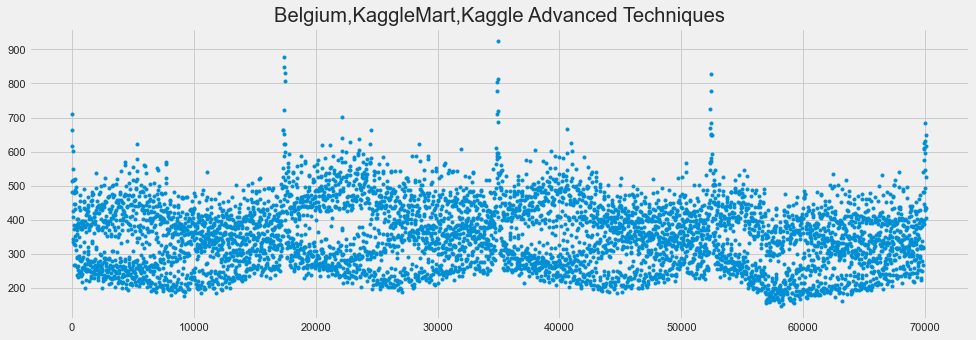

In [83]:
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

first = df2_train.query('country=="Belgium" and store=="KaggleMart" and product=="Kaggle Advanced Techniques"')

first['num_sold'].plot(style='.',
                       figsize=(15,5),
                       #color=color_pal[0],
                       title='Belgium,KaggleMart,Kaggle Advanced Techniques');

In [79]:
train

date country       store                           product  \
47    2017-01-01   Spain  KaggleRama  Kaggle for Kids: One Smart Goose   
95    2017-01-02   Spain  KaggleRama  Kaggle for Kids: One Smart Goose   
143   2017-01-03   Spain  KaggleRama  Kaggle for Kids: One Smart Goose   
191   2017-01-04   Spain  KaggleRama  Kaggle for Kids: One Smart Goose   
239   2017-01-05   Spain  KaggleRama  Kaggle for Kids: One Smart Goose   
...          ...     ...         ...                               ...   
52415 2019-12-28   Spain  KaggleRama  Kaggle for Kids: One Smart Goose   
52463 2019-12-29   Spain  KaggleRama  Kaggle for Kids: One Smart Goose   
52511 2019-12-30   Spain  KaggleRama  Kaggle for Kids: One Smart Goose   
52559 2019-12-31   Spain  KaggleRama  Kaggle for Kids: One Smart Goose   
52607 2020-01-01   Spain  KaggleRama  Kaggle for Kids: One Smart Goose   

       num_sold  
47          181  
95          123  
143         125  
191         110  
239         104  
...         ...  
52415       185  
52463       184  
52511       168  
52559       135  
52607       117  

[1096 rows x 5 columns]

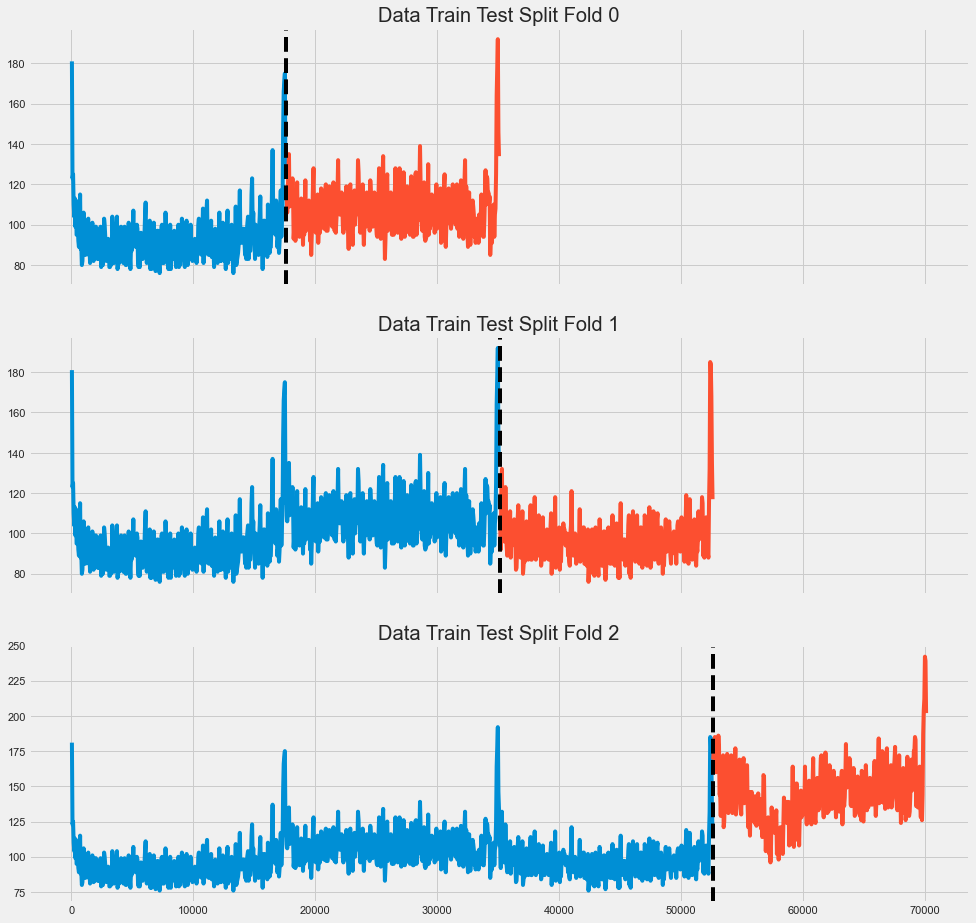

In [78]:
tss = TimeSeriesSplit(n_splits=3, test_size=365)

fig, axs = plt.subplots(3,1, figsize=(15,15),sharex=True)

fold= 0
for train_idx, val_idx in tss.split(first[first['num_sold'].isna()==False]):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    train['num_sold'].plot(ax= axs[fold],
                           label='Training Set',
                           title = f"Data Train Test Split Fold {fold}")
    test['num_sold'].plot(ax=axs[fold],
                          label='Test Set')
    axs[fold].axvline(test.index.min(),color='black',ls='--')
    fold +=1
plt.show()


Introdução
Este tópico de discussão destina-se a acumular ideias valiosas quanto à engenharia de recursos adicionais para esta competição.

Notas:

Este tópico é útil se sua estratégia para este concurso for transformar o problema clássico de TS em problema de regressão (e, assim, usar os algoritmos populares de regressão ML). Se você preferir usar as técnicas clássicas de modelagem TS, então não seria de seu interesse.
Vou atualizá-lo de tempos em tempos, para agregar as novas ideias que provaram funcionar nos modelos especialistas
Recursos adicionais para este concurso
O seguinte 'corpo de conhecimento' contém as informações sobre os recursos úteis sugeridos/experimentados pelos especialistas que participam da competição.

Dados do PIB 2017-2021: conforme sugerido por @hasanbasriakcay em Recursos Adicionais para a Competição, Dados do PIB 2017-2021, certamente melhorará a pontuação do modelo na tabela de classificação.

Índice de educação: conforme demonstrado no concurso com o conjunto de dados semelhante ( TPS-Jan-2022 ), o Índice de educação foi útil. Portanto, @desalegngeb recomendou usá-lo neste concurso também (por este tópico)

Índice de Confiança do Consumidor: como mencionado por @xclimx neste tópico, esse recurso provou funcionar para esta competição, assim como para o TPS-Jan-2022. Este segmento de discussão refere-se ao conjunto de dados e notebook relevantes para demonstrá-lo no trabalho.

Índice de Confiança de Negócios: como mencionado por @xclimx neste tópico, esse recurso provou adicionar vantagem à precisão de previsão do modelo nesta competição.

Datas de bloqueio do Covid: como 2021 (o intervalo de tempo para prever as vendas de livros) caiu na pandemia do COVID-19, a sugestão natural (por @xclimx em Engenharia de recursos - datas de bloqueio do Covid) é adicionar as datas críticas de bloqueio por país como recursos no conjunto de dados. O conjunto de dados externo por Stay At Home COVID 2020-2021 contém os detalhes relevantes para ele. Além disso, o mini-EDA por bloqueio afeta as vendas de livros Kaggle na Itália, Polônia e Espanha? fornece a visualização adicional em apoio a ele.

Feriados: Feriados por país provam funcionar para este concurso (como na maioria dos concursos do tipo TS). Você pode verificar Feriados por país e ano para mais detalhes. Também se justifica pela pesquisa mini-EDA de @hasanbasriakcay apresentada em Holiday and The Target Relationship

Referências
https://www.kaggle.com/competitions/tabular-playground-series-sep-2022/discussion/349371
https://www.kaggle.com/competitions/tabular-playground-series-sep-2022/discussion/349377
https://www.kaggle.com/competitions/tabular-playground-series-sep-2022/discussion/349513
https://www.kaggle.com/competitions/tabular-playground-series-sep-2022/discussion/349426
https://www.kaggle.com/competitions/tabular-playground-series-sep-2022/discussion/349908
https://www.kaggle.com/competitions/tabular-playground-series-sep-2022/discussion/349549
https://www.kaggle.com/competitions/tabular-playground-series-sep-2022/discussion/349703
https://www.kaggle.com/competitions/tabular-playground-series-sep-2022/discussion/349799
https://www.kaggle.com/competitions/tabular-playground-series-sep-2022/discussion/351280
Histórico de Revisão
7 de setembro de 2022 - versão original da página publicada
10 de setembro de 2022 - detalhes adicionados sobre o Índice de Confiança nos Negócios